##### Copyright 2019 The TensorFlow Authors and Geoffrey Fox 2020


In [2]:
!python --version

Python 3.8.12


In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
# Set Runname
# RunName = 'CovidA21-TFTTestA'  # Use to access old fit
RunName = 'CovidA21-TFT2Extended-JulyCutoff-TFTJupyter'
RunComment = ''' 
              This is the TFT model fit for group number 2 in the rurality based stratification. The data is from beginning until July 2021.
              Feature importance is included in this modeling.
              '''

In [5]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'

startpurple = '\033[35m'
startyellowbkg = '\033[43m'

### VERY IMPORTANT LINE -> Set to 1 if TRAINING and 0 if VISUALIZING

In [6]:
TFTMode = 1

# Initial System Code

# Transformer model for science data based on original for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Science Data Parameters and Sizes

-------
Here is structure of science time series module. We will need several arrays that will need to be flattened at times. Note Python defaults to row major i.e. final index describes contiguous positions in memory


At highest level data is labeled by Time and Location

*   Ttot is total number of time steps
*   Tseq is length of each sequence in time steps
*   Num_Seq is number of sequences in time: Num_Seq = Ttot-Tseq + 1
*   Nloc is Number of locations. The locations could be a 1D list or have array structure such as an image.
*   Nsample is number of data samples Nloc * Num_Seq




Input data is at each location
*   Nprop time independent properties describing the location
*   Nforcing is number of time dependent forcing features INPUT at each time value


Output (predicted) data at each location and for each time sequence is
*   Npred predicted time dependent values defined at every time step
*   Recorded at Nforecast time values measured wrt final time value of sequence
*   ForecastDay is an array of length Nforecast defining how many days into future prediction is. Typically ForecastDay[0] = 1 and Nforecast is often 1
*   There is also a class of science problems that are more similar to classic Seq2Seq. Here Nforecast = Tseq and ForecastDay = [-Tseq+1 ... 0]
*   We also support Nwishful predictions of events in future such probability of an earthquake of magnitude 6 in next 3 years. These are defined by araays EventType and Timestart, TimeInterval of length Nwishful. EventType is user defined and Timestart, TimeInterval is measured in time steps
*   Any missing output values should be set to NaN and Loss function must ensure that these points are ignored in derivative calculation and value calculation

We have an input module that supports either LSTM or Transformer (multi-head attention) models

Example Problem AICov

*   Ttot = 114
*   Tseq = 9
*   Num_Seq = 106
*   Nloc = 110


*   Nprop = 35
*   Nforcing = 5 including infections, fatalities, plus 3 temporal position variables (last 3 not in current version)
 
 
*   Npred = 2 (predicted infections and fatalities). Could be 5 if predicted temporal position of output)
*   Nforecast= 15
*   ForecastDay = [1, 2, .......14, 15]
*   Nwishful = 0




















## Science Data Arrays

Typical Arrays


[ time, Location ] as Pandas array with label [name of time-dependent variable] as an array or just name of Pandas array

time labels rows indexed by datetime or the difference datetime - start

Non windowed data is stored with propert name as row index and location as column index
[ static property, Location]

Covid Input is
[Sequence number 0..Num_Seq-1 ] [ Location 0..Nloc-1 ] [position in time sequence Tseq]  [ Input Features]

Covid Output is 
[Sequence number Num_Seq ] [ Location Nloc ]  [ Output Features] 

Output Features are [ ipred = 0 ..Npred-1 ] [ iforecast = 0 ..Nforecast-1 ]

Input Features are static fields followed by if present by dynamic system fields (cos-theta sin-theta linear) chosen followed by cases, deaths. In fact this is user chosen as they set static and dynamic system properties to use

We will have various numpy and pandas arrays where we designate label

[Ttot] is all time values 

[Num_Seq]  is all sequences of window size ***Tseq***

We can select time values or sequences [Ttot-reason] [Num_Seq-reason] for a given "reason"

[Num_Seq][Tseq] is all time values in all sequences

[Nloc] is all locations while [Nloc-reason] is subset of locations for given "reason"

[Model1] is initial embedding of each data point

[Model1+TrPosEnc] is initial embedding of each data point with Transformer style positional encoding

[Nforcing] is time dependent input parameters and [Nprop] static properties while [ExPosEnc] are explicit positional (temporal) encoding.

[Nforcing+ExPosEnc+Nprop] are all possible inputs

[Npred] is predicted values with [Npred+ExPosEnc] as predictions plus encodings with actually used [Predvals] = [Npred+ExPosEnc-Selout] 

[Predtimes] = [Forecast time range] are times forecasted with "time range" separately defined



In [7]:
from numpy.core.numeric import True_
AgeDist = (True, ['Age Distribution.csv'])
AirPollution = (True, ['Air Pollution.csv'])
Comorbidites = (True, ['Comorbidities.csv'])
Demographics = (False , ['Demographics.csv'])
HealthDisp = (True, ['Health Disparities.csv'])
HospitalBed = (False, ['Hospital Beds.csv'])
Mobility = (True, ['Mobility.csv'])
ResidentialDense = (True , ['Residential Density.csv'])
Voting = (False, ['2020votes.csv', 'Alaskavoting2016.csv'])
DiseaseSpread = (True , ['Disease Spread.csv'])
SocialDist = (True, ['Social Distancing.csv'])
Testing = (True, ['Testing.csv'])
Transmission = (True, ['Transmissible Cases.csv'])
VaccinationOne = (True, ['VaccinationOneDose.csv'])
VaccinationFull = (True, ['Vaccination.csv'])

Features = [AgeDist, AirPollution, Comorbidites, Demographics, HealthDisp,
            HospitalBed, Mobility, ResidentialDense, Voting, DiseaseSpread,
            SocialDist, Testing, Transmission, VaccinationOne, VaccinationFull]


FeatureFiles = [i[1] if i[0] else None for i in Features]
FeatureFiles = list(filter(None.__ne__, FeatureFiles))
FeatureFiles = [i[0] if i[0] else None for i in FeatureFiles]

UseVoting = True if '2020votes.csv' in FeatureFiles else False

In [8]:
FeatLen = len(FeatureFiles)

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tnrange, notebook, tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
import gc
from csv import reader
from csv import writer
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta,date,datetime

!pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch



/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Define Basic Control parameters

In [10]:
def wraptotext(textinput,size=None):
  if size is None:
    size = 120
  textlist = wrap(textinput,size)
  textresult = textlist[0]
  for itext in range(1,len(textlist)):
    textresult += '\n'+textlist[itext]
  return textresult

def timenow():
  now = datetime.now()
  return now.strftime("%m/%d/%Y, %H:%M:%S") + " UTC"

def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

NaN = np.float32("NaN")

ReadJuly2020Covid = False
ReadAugust2020Covid = False
ReadJan2021Covid = False
ReadApril2021Covid = False
ScaleProperties = False
ConvertDynamicPredictedQuantity = False
ConvertDynamicProperties = True
GenerateFutures = False
GenerateSequences = False
PredictionsfromInputs = False
RereadMay2020 = False
UseOLDCovariates = False
Dropearlydata = 0
NIHCovariates = False 
UseFutures = True
Usedaystart = False 
PopulationNorm = False
SymbolicWindows = False
Hydrology = False
Earthquake = False
EarthquakeImagePlots = False
AddSpecialstoSummedplots = False
UseRealDatesonplots = False
Dumpoutkeyplotsaspics = False
OutputNetworkPictures = False
CDSpecial = False
NumpredbasicperTime = 2
NumpredFuturedperTime = 2
NumTimeSeriesCalculated = 0
Dailyunit = 1
TimeIntervalUnitName = 'Day'
InitialDate = datetime(2000,1,1)
NumberofTimeunits = 0
Num_Time =0
FinalDate = datetime(2000,1,1)
GlobalTrainingLoss = 0.0
GlobalValidationLoss = 0.0

# Type of Testing
LocationBasedValidation = False
LocationValidationFraction = 0.0
LocationTrainingfraction = 1.0
RestartLocationBasedValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
Plotsplitsize = -1 # if > 1 split time in plots

GarbageCollect = True
GarbageCollectionLimit = 0

current_time = timenow()

SubName = RunName[0:6]



if SubName == 'BEST14' or SubName == 'BEST15' or SubName == 'BEST16':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 37
  CDSpecial = True

if SubName == 'CovidA':
  UseOLDCovariates = False
  if 'Extended' in RunName[6:]:
    ReadDecember2021 = True
    ReadApril2021Covid = False
  else:
    ReadApril2021Covid = True
    ReadDecember2021 = False
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  UseFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  CDSpecial = True

if SubName == 'C2021A' or SubName == 'C2021B':
  UseOLDCovariates = False
  ReadJan2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 0
  CDSpecial = True

if SubName == 'Hydrol':
  Hydrology = True

if SubName == 'EARTHQ':
  Earthquake = True

if RunName == 'BEST10' or RunName == 'BEST13-10D' or RunName == 'BEST12-10' or RunName == 'BEST12-Test' or RunName == 'BEST13' or RunName == 'BEST13-10' or RunName == 'BEST13-10A' or RunName == 'BEST13-10C':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST11' or RunName == 'BEST11A':
  UseOLDCovariates = True
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST12':
  UseOLDCovariates = True
  RereadMay2020 = True
  ReadAugust2020Covid = False
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST8' or RunName == 'BEST8A' or RunName == 'BEST12-LSTM-8':
  ReadJuly2020Covid = True


## Define input structure

Read in data and set it up for Tensorflow with training and validation


Set train_examples, val_examples as science training and validatioon set.

The shuffling of Science Data needs some care. We have ***Tseq*** * size of {[Num_Seq][Nloc]} locations in each sample. In simplease case the last is just a decomposition over location; not over time. Let's Nloc-sel be number of locations per sample. It will be helpful if Nloc-sel is divisable by 2. 

Perhaps Nloc-sel = 2 6 or 10 is reasonable.

Then you shuffle locations every epoch and divide them into groups of size Nloc-sel with 50% overlap so you get locations

0 1 2 3 4 5; 

3 4 5 6 7 8; 

6 7 8 9 10 11 etc.

Every locations appears twice in an epoch (for each time value). You need to randomly add locations at end of sequence so it is divisiuble by Nloc-sel e.g add 4 random positions to the end if Nloc=110 and Nloc-sel = 6. Note last group of 6 has members 112 113 114 0 1 2

After spatial structure set up, randomly shuffle in Num_Seq where there is an argument to do all locations for a partcular time value together.

For validation, it is probably best to select validation location before chopping them into groups of size Nloc-sel

How one groups locations for inference is not clear. One idea is to take trained network and use it to find for each location which other locations have the most attention with it. Use those locations in  prediction

More general input. 
NaN allowed value

* Number time values
* Number locations
* Number driving values
* Number predicted values

For COVID driving same as predicted

* a) Clean up >=0 daily
* b) Normalize
* c) Add Futures
* d) Add time/location encoding


### Setup File Systems

In [13]:
# read in science data 
COLABROOTDIR="./"
os.environ["COLABROOTDIR"] = COLABROOTDIR

if Hydrology:
  APPLDIR=os.path.join(COLABROOTDIR, "Hydrology")
elif Earthquake:
  APPLDIR=os.path.join(COLABROOTDIR, "EarthquakeDec2020")
else:
  APPLDIR=os.path.join(COLABROOTDIR, "COVIDJuly2020")

# Set up Checkpoints
CHECKPOINTDIR = APPLDIR + "/checkpoints/" + RunName + "dir/"
try: 
    if not os.path.exists(CHECKPOINTDIR):
      os.mkdir(CHECKPOINTDIR) 
except OSError as error: 
    print(error)
print('Checkpoint set up in directory ' + CHECKPOINTDIR)

Checkpoint set up in directory ./COVIDJuly2020/checkpoints/CovidA21-TFT2Extended-JulyCutoff-TFTJupyterdir/


### Read April 2021 Covid Data

In [14]:
if ReadDecember2021:
  Dropearlydata = 0 # 3 more than needed by covariates so as to get "round number of days"
  NIHCovariates = True
  UseOLDCovariates = False
  LengthFutures = 0

  InitialDate = datetime(2020,2,29) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,6,30)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of days December 2021 Dataset " + str(NumberofTimeunits) + ' dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/CovidDecember12-2021'

  CasesFile = DATASETDIR + '/US_daily_cumulative_cases_Dec12.csv'
  DeathsFile = DATASETDIR + '/US_daily_cumulative_deaths_Dec12.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'
  LocationruralityFile = DATASETDIR + '/Rurality.csv'
  VotingdataFile = DATASETDIR + '/2020votes.csv'
  AlaskaVotingdataFile = DATASETDIR + '/Alaskavoting2016.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

  DemVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  RepVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  with open(VotingdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'state_name':
        printexit('EXIT: Wrong file type Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips > 2900 and localfips < 2941: # Alaska not useful
          continue
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = nextrow[8]
          RepVoting[jloc] = nextrow[7]
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  

  with open(AlaskaVotingdataFile, 'r',encoding='utf-8-sig') as read_obj: # remove ufeff
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'SpecialAlaska':
        printexit('EXIT: Wrong file type Alaska Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = float(nextrow[2]) * 42.77/36.5
          RepVoting[jloc] = float(nextrow[3]) * 52.83/51.3
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))

  for iloc in range(0,NFIPS):
    if DemVoting[iloc] >= 0.0:
      continue
    print(str(iloc) + ' Missing Votes ' + str(Locationfips[iloc]) + ' ' + Locationname[iloc] + ' ' + Locationstate[iloc] + ' pop ' + str( Locationpopulation[iloc]))
    DemVoting[iloc] = 0.5
    RepVoting[iloc] = 0.5

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
# Voting added as 13th covariate
  NpropperTimeDynamic = FeatLen
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

Total number of days December 2021 Dataset 488 dropping at start 0
Read Cases data locations 3142 Time Steps 488
Read Deaths data locations 3142 Time Steps 488
548 Missing Votes 15005 Kalawao County Hawaii pop 86


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/3483247979.py:171: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)


### Cut by Median Rurality Score

In [15]:
RuralityFile = DATASETDIR + '/' + 'Rurality.csv'
RuralityRange = [4.501,5]
RuralityCut=True

Locationrurality = np.empty(NFIPS)
Locationmad = np.empty(NFIPS)

skips = []

with open(RuralityFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)
      
      iloc = 0
      for row in csv_reader:
        localfips = int(row[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationrurality[jloc] = row[1]
          Locationmad[jloc] = row[2]
          iloc +=1
        else:
          print('FIPS not in lookup table ' +str(iloc) + ' ' + str(localfips))  
          skips.append(iloc)


Locationrurality[81] = None
Locationrurality[2412] = None 
Locationmad[81] = None 
Locationmad[2412] = None

FIPS not in lookup table 92 2270
FIPS not in lookup table 2416 46113
FIPS not in lookup table 2914 51515
FIPS not in lookup table 3140 72001
FIPS not in lookup table 3140 72003
FIPS not in lookup table 3140 72005
FIPS not in lookup table 3140 72007
FIPS not in lookup table 3140 72009
FIPS not in lookup table 3140 72011
FIPS not in lookup table 3140 72013
FIPS not in lookup table 3140 72015
FIPS not in lookup table 3140 72017
FIPS not in lookup table 3140 72019
FIPS not in lookup table 3140 72021
FIPS not in lookup table 3140 72023
FIPS not in lookup table 3140 72025
FIPS not in lookup table 3140 72027
FIPS not in lookup table 3140 72029
FIPS not in lookup table 3140 72031
FIPS not in lookup table 3140 72033
FIPS not in lookup table 3140 72035
FIPS not in lookup table 3140 72037
FIPS not in lookup table 3140 72039
FIPS not in lookup table 3140 72041
FIPS not in lookup table 3140 72043
FIPS not in lookup table 3140 72045
FIPS not in lookup table 3140 72047
FIPS not in lookup table 3140 7

In [16]:
if NIHCovariates:
  if ReadJan2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Intervention Testing.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv",  "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds", "Intervention Testing", "Mobility", "Residential Density", 
                 "Social Distancing", "Transmissible Cases"]
  
  elif ReadApril2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv","NOFILE"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds",  "Mobility", "Residential Density", 
                 "Social Distancing", "Testing","Transmissible Cases","voting"]
  elif ReadDecember2021:

    Propfilenames = FeatureFiles
    Propnames = [i[:-4] for i in Propfilenames]

    if UseVoting:
      Propfilenames.append("NOFILE")
      Propnames.append("voting")

  else:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Co-morbidities.csv", "Health Disparities.csv", "Hospital Beds.csv", "Pop Demographics.csv", "Pop Mobility.csv", "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities", "Health Disparities", "Hospital Beds", "Pop Demographics", "Pop Mobility", "Residential Density", "Social Distancing", "Testing", "Transmissible Cases"]
  
  NIHDATADIR = DATASETDIR + '/' 
  numberfiles = len(Propnames)
  NpropperTimeStatic = 0
  if NpropperTimeDynamic != numberfiles:
    printexit('EXIT: Dynamic Properties set wrong ' + str(numberfiles) + ' ' + str(NpropperTimeDynamic))
  DynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,numberfiles],dtype = np.float32)
  enddifference = NaN

  for ifiles in range(0,numberfiles):
    InputPropertyNames.append(Propnames[ifiles])
    if Propfilenames[ifiles] == 'NOFILE': # Special case of Voting Data
      for iloc in range(0,Nloc):
        Demsize = DemVoting[iloc]
        RepSize = RepVoting[iloc]
        Votingcovariate = Demsize/(RepSize+Demsize)
        DynamicPropertyTimeSeries[:,iloc,ifiles] = Votingcovariate
      continue # over ifile loop

    DynamicPropFile = NIHDATADIR + Propfilenames[ifiles]
    if not (ReadJan2021Covid or ReadApril2021Covid or ReadDecember2021):
      DynamicPropFile = DATASETDIR + '/ThirdCovariates/' + Propfilenames[ifiles]

    # Read in  Covariate Data into DynamicPropertyTimeSeries
    print(DynamicPropFile)
    with open(DynamicPropFile, 'r') as read_obj:
        csv_reader = reader(read_obj)
        header = next(csv_reader)
        skip = 1
        if ReadJan2021Covid or ReadApril2021Covid or ReadDecember2021:
          skip = 2
          Ftype = header[0]
          if Ftype != 'Name':
            printexit('EXIT: Wrong file type ' + Ftype)
        Ftype = header[skip-1]
        if Ftype != 'FIPS':
          printexit('EXIT: Wrong file type ' + Ftype)
        # Check Date
        hformat = '%m-%d-%Y'
        if ReadJan2021Covid or ReadApril2021Covid or ReadDecember2021:
          hformat = '%Y-%m-%d'
        firstdate = datetime.strptime(header[skip], hformat)
        tdelta = (firstdate-InitialDate).days 
        if tdelta > 0:
          printexit('Missing Covariate Data start -- adjust Dropearlydata ' + str(tdelta))
        lastdate = datetime.strptime(header[len(header)-1], hformat)
        enddifference1 = (FinalDate-lastdate).days
        if math.isnan(enddifference):
          enddifference = enddifference1
          print('Missing days at the end ' + str(enddifference))
        else:
          if enddifference != enddifference1:
            printexit('EXIT: Incorrect time length ' + Propnames[ifiles] + ' expected ' + str(enddifference) + ' actual ' +str(enddifference1))
        iloc = 0
        
        #Test
        if lastdate > FinalDate:
          tempInt = NumberofTimeunits
        else:
          tempInt = NumberofTimeunits - enddifference

        for nextrow in csv_reader:
          if iloc == 0:
            print(len(nextrow)!=NumberofTimeunits + skip -enddifference-tdelta)
          if (len(nextrow)!=NumberofTimeunits + skip -enddifference-tdelta):
            printexit('EXIT: Incorrect row length ' + Propnames[ifiles] + ' Location ' + str(iloc) + ' ' +str(len(nextrow)))
          localfips = nextrow[skip-1]
          jloc = FIPSstringlookup[localfips] 
          for itime in range(0, tempInt): #NumberofTimeunits - enddifference
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = nextrow[itime + skip - tdelta]
        # Use previous week value for missing data at the end
          if tempInt != NumberofTimeunits:  
            for itime in range(tempInt, NumberofTimeunits):# NumberofTimeunits - enddifference
              DynamicPropertyTimeSeries[itime,jloc,ifiles] = DynamicPropertyTimeSeries[itime-7,jloc,ifiles]
          iloc += 1
# End Reading in dynamic property data

    if iloc != Nloc:
            printexit('EXIT Inconsistent location lengths ' + Propnames[ifiles] + str(iloc) + ' ' + str(Nloc))
    print('Read ' + Propnames[ifiles] + ' data for locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time) + ' Days dropped at start ' + str(-tdelta))

  if ReadApril2021Covid or ReadDecember2021:

    if RuralityCut:
      uselocation=np.full(Nloc,False,dtype=np.bool)
      if len(RuralityRange) > 0:
        for jloc in range(0,Nloc):
          if Locationrurality[jloc] >= RuralityRange[0] and Locationrurality[jloc] <= RuralityRange[1]:
            uselocation[jloc] = True
        TotRuralityCut = uselocation.sum()
        NumberCut = Nloc - TotRuralityCut
        print(' Rurality Cut ' + str(RuralityRange) + ' removes ' + str(Nloc - TotRuralityCut) + ' of ' + str(Nloc))

      else: 
        printexit('EXIT There are no rurality criteria')
      
      if TotRuralityCut > 0:
        NewNloc = Nloc - NumberCut
        NewNFIPS = NewNloc
        NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
        NewLocationcolumns = [] # String version of FIPS
        NewFIPSintegerlookup = {}
        NewFIPSstringlookup = {}
        NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
        NewLocationname = ['Empty'] * NewNFIPS
        NewLocationstate = ['Empty'] * NewNFIPS
        NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
        NewLocationrurality = np.empty(NewNFIPS)
        NewLocationmad = np.empty(NewNFIPS)
        NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

        Newiloc = 0
        for iloc in range(0,Nloc):
          if not uselocation[iloc]:
            continue
          NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
          NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
          localfips = Locationcolumns[iloc]
          NewLocationcolumns.append(localfips)
          NewLocationfips[Newiloc] = int(localfips)
          NewFIPSintegerlookup[int(localfips)] = Newiloc
          NewFIPSstringlookup[localfips] = Newiloc 
          NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
          NewLocationstate[Newiloc] = Locationstate[iloc]
          NewLocationname[Newiloc] = Locationname[iloc]
          NewLocationrurality[Newiloc] = Locationrurality[iloc]
          NewLocationmad[Newiloc] = Locationmad[iloc]
          Newiloc +=1

        BasicInputTimeSeries = NewBasicInputTimeSeries
        DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
        Locationname = NewLocationname
        Locationstate = NewLocationstate
        Locationpopulation = NewLocationpopulation
        FIPSstringlookup = NewFIPSstringlookup
        FIPSintegerlookup = NewFIPSintegerlookup
        Locationcolumns = NewLocationcolumns
        Locationfips = NewLocationfips
        Locationrurality = NewLocationrurality
        Locationmad = NewLocationmad
        NFIPS = NewNFIPS
        Nloc = NewNloc


    else:
      uselocation = np.full(Nloc, True, dtype = np.bool)
      if (CovidPopulationCut > 0) or (NumberCut > 0):
        if NumberCut >0:
          smalllocations = np.argsort(Locationpopulation)
          for jloc in range(0,NumberCut):
            uselocation[smalllocations[jloc]] = False
          CovidPopulationCut = Locationpopulation[smalllocations[NumberCut]]
        else:
          NumberCut =0
          for iloc in range(0,Nloc):
            if Locationpopulation[iloc] < CovidPopulationCut:
              uselocation[iloc] = False
              NumberCut += 1
        print(' Population Cut ' + str(CovidPopulationCut) + ' removes ' + str(NumberCut) + ' of ' + str(Nloc))
      if(NumberCut > 0):
        NewNloc = Nloc - NumberCut
        NewNFIPS = NewNloc
        NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
        NewLocationcolumns = [] # String version of FIPS
        NewFIPSintegerlookup = {}
        NewFIPSstringlookup = {}
        NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
        NewLocationname = ['Empty'] * NewNFIPS
        NewLocationstate = ['Empty'] * NewNFIPS
        NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
        NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

        Newiloc = 0
        for iloc in range(0,Nloc):
          if not uselocation[iloc]:
            continue
          NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
          NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
          localfips = Locationcolumns[iloc]
          NewLocationcolumns.append(localfips)
          NewLocationfips[Newiloc] = int(localfips)
          NewFIPSintegerlookup[int(localfips)] = Newiloc
          NewFIPSstringlookup[localfips] = Newiloc 
          NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
          NewLocationstate[Newiloc] = Locationstate[iloc]
          NewLocationname[Newiloc] = Locationname[iloc]
          Newiloc +=1

        BasicInputTimeSeries = NewBasicInputTimeSeries
        DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
        Locationname = NewLocationname
        Locationstate = NewLocationstate
        Locationpopulation = NewLocationpopulation
        FIPSstringlookup = NewFIPSstringlookup
        FIPSintegerlookup = NewFIPSintegerlookup
        Locationcolumns = NewLocationcolumns
        Locationfips = NewLocationfips
        NFIPS = NewNFIPS
        Nloc = NewNloc

      

./COVIDJuly2020/CovidDecember12-2021/Age Distribution.csv
Missing days at the end -145
False
Read Age Distribution data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Air Pollution.csv
False
Read Air Pollution data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Comorbidities.csv
False
Read Comorbidities data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Health Disparities.csv
False
Read Health Disparities data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Mobility.csv
False
Read Mobility data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Residential Density.csv
False
Read Residential Density data for locations 3142 Time Steps 488 Days dropped at start 1
./COVIDJuly2020/CovidDecember12-2021/Disease Spread.csv
False
Read Disease Spread data for loca

/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/1353694957.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uselocation=np.full(Nloc,False,dtype=np.bool)


### Apply Second filter to data to stratify based on MAD

In [17]:
RuralityMADStrataGroups = [0,1,2,3] # Select one group for model training, make sure to update in checkpointing
RuralityMADIter = RuralityMADStrataGroups[1]

if RuralityMADIter == 0:
  MADRange = [0,1]
elif RuralityMADIter == 1:
  MADRange = [1,2]
elif RuralityMADIter == 2:
  MADRange = [2,3]
elif RuralityMADIter == 3:
  MADRange = [3,4]
else:
  printexit('EXIT Not a valid Rurality MAD Grouping')


if RuralityCut:
    uselocation=np.full(Nloc,False,dtype=np.bool)
    if len(MADRange) > 0:
      for jloc in range(0,Nloc):
        if (Locationmad[jloc] >= MADRange[0])&(Locationmad[jloc] < MADRange[1]):
          uselocation[jloc] = True
      TotMADCut = uselocation.sum()
      NumberCut = Nloc - TotMADCut
      print(' MAD Cut ' + str(MADRange) + ' removes ' + str(Nloc - TotMADCut) + ' of ' + str(Nloc))

    else: 
      printexit('EXIT There are no rurality criteria')
    
    if TotRuralityCut > 0:
      NewNloc = Nloc - NumberCut
      NewNFIPS = NewNloc
      NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
      NewLocationcolumns = [] # String version of FIPS
      NewFIPSintegerlookup = {}
      NewFIPSstringlookup = {}
      NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
      NewLocationname = ['Empty'] * NewNFIPS
      NewLocationstate = ['Empty'] * NewNFIPS
      NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
      NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

      Newiloc = 0
      for iloc in range(0,Nloc):
        if not uselocation[iloc]:
          continue
        NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
        NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
        localfips = Locationcolumns[iloc]
        NewLocationcolumns.append(localfips)
        NewLocationfips[Newiloc] = int(localfips)
        NewFIPSintegerlookup[int(localfips)] = Newiloc
        NewFIPSstringlookup[localfips] = Newiloc 
        NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
        NewLocationstate[Newiloc] = Locationstate[iloc]
        NewLocationname[Newiloc] = Locationname[iloc]
        Newiloc +=1

      BasicInputTimeSeries = NewBasicInputTimeSeries
      DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
      Locationname = NewLocationname
      Locationstate = NewLocationstate
      Locationpopulation = NewLocationpopulation
      FIPSstringlookup = NewFIPSstringlookup
      FIPSintegerlookup = NewFIPSintegerlookup
      Locationcolumns = NewLocationcolumns
      Locationfips = NewLocationfips
      NFIPS = NewNFIPS
      Nloc = NewNloc




 MAD Cut [1, 2] removes 103 of 182


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/569544285.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uselocation=np.full(Nloc,False,dtype=np.bool)


### Read and setup NIH Covariates August 2020 and January, April 2021 Data

new collection of time dependent covariates (even if constant).

cases and deaths and location property from previous data


## Process Input Data  in various ways



###Set TFT Mode

In [18]:
TFTConversion = True

### Convert Cumulative to Daily

In [19]:
# Convert  cumulative to Daily. 
# Replace negative daily values by zero
# remove daily to sqrt(daily)  and Then normalize maximum to 1
if ConvertDynamicPredictedQuantity:
  NewBasicInputTimeSeries = np.empty_like(BasicInputTimeSeries, dtype=np.float32)
  Zeroversion = np.zeros_like(BasicInputTimeSeries, dtype=np.float32)
  Rolleddata = np.roll(BasicInputTimeSeries, 1, axis=0)
  Rolleddata[0,:,:] = Zeroversion[0,:,:]
  NewBasicInputTimeSeries = np.maximum(np.subtract(BasicInputTimeSeries,Rolleddata),Zeroversion)
  originalnumber = np.sum(BasicInputTimeSeries[NumberofTimeunits-1,:,:],axis=0)
  newnumber = np.sum(NewBasicInputTimeSeries,axis=(0,1))
  print('Original summed counts ' + str(originalnumber) + ' become ' + str(newnumber)+ ' Cases, Deaths')

  BasicInputTimeSeries = NewBasicInputTimeSeries


Original summed counts [344652.   6729.] become [349361.   6849.] Cases, Deaths


### Static and Dynamic specials for COVID

except case where Romeo data read

In [20]:
# Remove special status of Cases and Deaths
if CDSpecial:
    
  NewNpropperTimeDynamic = NpropperTimeDynamic + 2
  NewNpropperTime = NpropperTimeStatic + NewNpropperTimeDynamic   

  NewProperty_is_Intensive = np.full(NewNpropperTime, True, dtype = np.bool)
  NewInputPropertyNames = []
  NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,NewNpropperTimeDynamic],dtype = np.float32)

  for casesdeaths in range(0,2):
    NewDynamicPropertyTimeSeries[:,:,casesdeaths] = BasicInputTimeSeries[:,:,casesdeaths]
  BasicInputTimeSeries = None

  for iprop in range(0,NpropperTimeStatic):
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[iprop] = Property_is_Intensive[iprop]
  NewProperty_is_Intensive[NpropperTimeStatic] = False
  NewProperty_is_Intensive[NpropperTimeStatic+1] = False
  NewInputPropertyNames.append('Cases')
  NewInputPropertyNames.append('Deaths')
  for ipropdynamic in range(0,NpropperTimeDynamic):
    Newiprop = NpropperTimeStatic+2+ipropdynamic
    iprop = NpropperTimeStatic+ipropdynamic
    NewDynamicPropertyTimeSeries[:,:,Newiprop] = DynamicPropertyTimeSeries[:,:,iprop]
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[Newiprop] = Property_is_Intensive[iprop]
  
  NpropperTimeDynamic = NewNpropperTimeDynamic
  NpropperTime = NewNpropperTime
  DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
  InputPropertyNames = NewInputPropertyNames
  Property_is_Intensive = NewProperty_is_Intensive

/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2891211563.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  NewProperty_is_Intensive = np.full(NewNpropperTime, True, dtype = np.bool)


### Static Property Manipulations for Covid Case

In [21]:
# Execute under all COVID circumstances properties generated here
if CDSpecial:
  if NpropperTimeStatic > 0:
    Num_Extensive = 0
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        Num_Extensive +=1
    print(startbold + startred + ' Number of Extensive parameters ' + str(Num_Extensive) + resetfonts)
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        print(InputPropertyNames[iprop])

    # Convert Extensive covariates to SQRT(Population normed)
    # Replace negatives by mean of positives and zeroes
    positivemean = np.zeros(NpropperTimeStatic, dtype = np.float32)
    countvalidentries = np.zeros(NpropperTimeStatic, dtype = np.float32)
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if not Property_is_Intensive[iprop]:
          BasicInputStaticProps[iloc,iprop] = np.sqrt(BasicInputStaticProps[iloc,iprop]/Locationpopulation[iloc])
        else:
          if BasicInputStaticProps[iloc,iprop] >= 0:
            positivemean[iprop] += BasicInputStaticProps[iloc,iprop]
            countvalidentries[iprop] += 1.0

    for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          positivemean[iprop] /= countvalidentries[iprop]

    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          if BasicInputStaticProps[iloc,iprop] < 0:
            BasicInputStaticProps[iloc,iprop] = positivemean[iprop]


###Normalize All Static and Dynamic Properties

for Static Properties BasicInputStaticProps[Nloc,NpropperTimeStatic] converts to NormedInputStaticProps[Nloc,NpropperTimeStatic]

In [22]:
def SetTakeroot(x,n):
    if np.isnan(x):
      return NaN   
    if n == 3:
      return np.cbrt(x)
    elif n == 2:
      if x <= 0.0:
        return 0.0
      return np.sqrt(x) 
    return x 

def DynamicPropertyScaling(InputTimeSeries):
    Results = np.full(7, 0.0,dtype=np.float32)
    Results[1] = np.nanmax(InputTimeSeries, axis = (0,1))
    Results[0] = np.nanmin(InputTimeSeries, axis = (0,1))
    Results[3] = np.nanmean(InputTimeSeries, axis = (0,1))
    Results[4] = np.nanstd(InputTimeSeries, axis = (0,1))
    Results[2] = np.reciprocal(np.subtract(Results[1],Results[0]))
    Results[5] = np.multiply(Results[2],np.subtract(Results[3],Results[0]))
    Results[6] = np.multiply(Results[2],Results[4])
    return Results

NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated  
if ScaleProperties:
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=np.int)
  if Hydrology:
    QuantityTakeroot[27] = 3
    QuantityTakeroot[32] = 3
  if CDSpecial:
    QuantityTakeroot[NpropperTimeStatic] =2
    QuantityTakeroot[NpropperTimeStatic+1] =2

# Scale data by roots if requested
  for iprop in range(0, NpropperTimeMAX):
    if QuantityTakeroot[iprop] >= 2:
      if iprop < NpropperTimeStatic:
        for iloc in range(0,Nloc):
          BasicInputStaticProps[iloc,iprop] = SetTakeroot(BasicInputStaticProps[iloc,iprop],QuantityTakeroot[iprop])
      elif iprop < NpropperTime:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic] = SetTakeroot(
                DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic],QuantityTakeroot[iprop])
      else:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            CalculatedTimeSeries[itime,iloc,iprop-NpropperTime] =SetTakeroot(
                CalculatedTimeSeries[itime,iloc,iprop-NpropperTime],QuantityTakeroot[iprop])

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  QuantityStatistics = np.zeros([NpropperTimeMAX,7], dtype=np.float32)
  if NpropperTimeStatic > 0:  
    print(BasicInputStaticProps.shape)
    max_value = np.amax(BasicInputStaticProps, axis = 0)
    min_value = np.amin(BasicInputStaticProps, axis = 0)
    mean_value = np.mean(BasicInputStaticProps, axis = 0)
    std_value = np.std(BasicInputStaticProps, axis = 0)
    normval = np.reciprocal(np.subtract(max_value,min_value))
    normed_mean = np.multiply(normval,np.subtract(mean_value,min_value))
    normed_std = np.multiply(normval,std_value)
    QuantityStatistics[0:NpropperTimeStatic,0] = min_value
    QuantityStatistics[0:NpropperTimeStatic,1] = max_value
    QuantityStatistics[0:NpropperTimeStatic,2] = normval
    QuantityStatistics[0:NpropperTimeStatic,3] = mean_value
    QuantityStatistics[0:NpropperTimeStatic,4] = std_value
    QuantityStatistics[0:NpropperTimeStatic,5] = normed_mean
    QuantityStatistics[0:NpropperTimeStatic,6] = normed_std

    NormedInputStaticProps =np.empty_like(BasicInputStaticProps)
    for iloc in range(0,Nloc):
      NormedInputStaticProps[iloc,:] = np.multiply((BasicInputStaticProps[iloc,:] - min_value[:]),normval[:])

  if (NpropperTimeDynamic > 0) or (NumTimeSeriesCalculated>0):
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      QuantityStatistics[iprop,:] = DynamicPropertyScaling(DynamicPropertyTimeSeries[:,:,iprop-NpropperTimeStatic])
    for iprop in range(0,NumTimeSeriesCalculated):
      QuantityStatistics[iprop+NpropperTime,:] = DynamicPropertyScaling(CalculatedTimeSeries[:,:,iprop]) 

    NormedDynamicPropertyTimeSeries = np.empty_like(DynamicPropertyTimeSeries)
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      NormedDynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic] = np.multiply((DynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
    
    if NumTimeSeriesCalculated > 0:
      NormedCalculatedTimeSeries = np.empty_like(CalculatedTimeSeries)
      for iprop in range(NpropperTime,NpropperTimeMAX):
        NormedCalculatedTimeSeries[:,:,iprop - NpropperTime] = np.multiply((CalculatedTimeSeries[:,:,iprop - NpropperTime]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
      CalculatedTimeSeries = None
  
    BasicInputStaticProps = None
    DynamicPropertyTimeSeries = None
    print(startbold + "Properties scaled" +resetfonts)

  line = 'Name   '
  for propval in range (0,7):
    line += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold +startpurple + line + resetfonts)
  for iprop in range(0,NpropperTimeMAX):
    if iprop == NpropperTimeStatic:
      print('\n')
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[iprop] + resetfonts  + ' Root ' + str(QuantityTakeroot[iprop])
    for propval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[iprop,propval],3))
    print(line)


Properties scaled

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    


0 Cases Root 2 0.0 36.263 0.028 2.035 2.218 0.056 0.061
1 Deaths Root 2 0.0 6.557 0.152 0.132 0.4 0.02 0.061
2 Age Distribution Root 1 0.4 0.696 3.372 0.578 0.061 0.601 0.206
3 Air Pollution Root 1 0.0 0.587 1.704 0.383 0.121 0.653 0.206
4 Comorbidities Root 1 0.15 0.721 1.751 0.393 0.122 0.425 0.213
5 Health Disparities Root 1 0.063 0.77 1.413 0.383 0.188 0.452 0.265
6 Mobility Root 1 0.399 0.642 4.114 0.544 0.043 0.596 0.178
7 Residential Density Root 1 0.037 0.985 1.055 0.602 0.252 0.596 0.266
8 Disease Spread Root 1 0.0 1.0 1.0 0.196 0.226 0.196 0.226
9 Social Distancing Root 1 0.0 1.0 1.0 0.823 0.169 0.823 0.169
10 Testing Root 1 0.0 1.0 1.0 0.535 0.222 0.535 0.222
11 Transmissible Cases Root 1 0.0 0.957 1.044 0.468 0.2 0.488 0.209
12 VaccinationOneDose Root 1 0.0 93.6 0.011 7.757 14.064 0.083 0.15
13 Vaccination Root 1 0.0 85.5 0.012 5.877 11.725 0.069 0.137


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/3832495392.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=np.int)


###Set up Futures 

-- currently at daily level 

In [23]:
class Future:
    def __init__(self, name, daystart = 0, days =[], wgt=1.0, classweight = 1.0):
        self.name = name
        self.days = np.array(days)
        self.daystart = daystart
        self.wgts = np.full_like(self.days,wgt,dtype=float)
        self.size = len(self.days)
        self.classweight = classweight

LengthFutures = 0
if GenerateFutures: # daystart overwritten
  Secondday = Future('day2',daystart = 23, days=[2],classweight=1./14.)
  Thirdday = Future('day3', daystart = 24, days=[3],classweight=1./14.)
  Fourthday = Future('day4', daystart = 25, days=[4],classweight=1./14.)
  Fifthday = Future('day5', daystart = 26, days=[5],classweight=1./14.)
  Sixthday = Future('day6', daystart = 27, days=[6],classweight=1./14.)
  Seventhday = Future('day7', daystart = 27, days=[7],classweight=1./14.)
  day8 = Future('day8', daystart = 28, days=[8],classweight=1./14.)
  day9 =  Future('day9', daystart = 29, days=[9],classweight=1./14.)
  day10 =  Future('day10', daystart = 30, days=[10],classweight=1./14.)
  day11 =  Future('day11', daystart = 31, days=[11],classweight=1./14.)
  day12 =  Future('day12', daystart = 32, days=[12],classweight=1./14.)
  day13 =  Future('day13', daystart = 33, days=[13],classweight=1./14.)
  day14 =  Future('day14', daystart = 34, days=[14],classweight=1./14.)
  day15 =  Future('day15', daystart = 35, days=[15],classweight=1./14.)
  # Secondweek = Future('week2', daystart= 19, days=[9,10,11,12,13,14,15],wgt=1./7.,classweight=0.25)
  # Thirdweek = Future('week3', daystart= 26, days=[16,17,18,19,20,21,22],wgt=1./7.,classweight=0.25)
  # Fourthweek = Future('week4', daystart = 33, days=[23,24,25,26,27,28,29],wgt=1./7.,classweight=0.25)
  # Fifthweek = Future('week5', daystart = 40, days=[30,31,32,33,34,35,36],wgt=1./7.,classweight=0.25)
  
  Futures = [ Secondday,Thirdday,Fourthday,Fifthday,Sixthday,Seventhday,day8,day9,day10,day11,day12,day13,day14,day15]
  Futures =[]
  for ifuture in range(0,14):
    xx = Future(str(ifuture+1), days=[ifuture+2])
    Futures.append(xx)
  LengthFutures = len(Futures)
  Futuresmaxday = 0
  Futuresmaxweek = 0
  for i in range(0,LengthFutures):
      j = len(Futures[i].days)
      if j == 1:
          Futuresmaxday = max(Futuresmaxday, Futures[i].days[0])
      else:
          Futuresmaxweek = max(Futuresmaxweek, Futures[i].days[j-1])
      Futures[i].daystart -= Dropearlydata
      if Futures[i].daystart < 0: Futures[i].daystart = 0
      if Earthquake:
        Futures[i].daystart = 0





### Set up mappings of locations

In next cell, we map locations for BEFORE location etc added

In cell after that we do same for sequences

In [24]:
OriginalNloc = Nloc

MappedLocations = np.arange(0,Nloc, dtype=np.int)
LookupLocations = np.arange(0,Nloc, dtype=np.int)
MappedNloc = Nloc


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/1070767286.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MappedLocations = np.arange(0,Nloc, dtype=np.int)
/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/1070767286.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

###Property and Prediction  Data Structures

Two important Lists Properties and Predictions that are related

 * Data stored in series is for properties, the calculated value occuring at or ending that day
 * For predictions, the data is the calculated value from that date or later. 

 * We store data labelled by time so that
  * for inputs we use time 0 upto last value - 1 i.e. position [length of array - 1]
  * for outputs (predictions) with sequence Tseq, we use array locations [Tseq] to [length of array -1]
  * This implies Num_Seq = Num_Time - Tseq


**Properties**

Everything appears in Property list -- both input and output (predicted)
DynamicPropertyTimeSeries holds input property time series where value is value at that time using data before this time for aggregations
  * NpropperTimeStatic is the number of static properties -- typically read in or calculated from input information
  * NpropperTimeDynamicInput is total number of input time series
  * NpropperTimeDynamicCalculated is total number of calculated dynamic quantities  used in Time series analysis as input properties and/or output predictions
  * NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated ONLY includes input properties
  * NpropperTime = NpropperTimeStatic + NpropperTimeDynamic will not include futures and NOT include calculated predictions
  * InputPropertyNames is a list of size NpropperTime holding names
  * NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated has calculated predictions following input properties ignoring futures 
  * QuantityStatistics has 7 statistics used in normalizing for NpropperTimeMAX properties
  * Normalization takes NpropperTimeStatic static features in BasicInputStaticProps and stores in NormedInputStaticProps
  * Normalization takes NpropperTimeDynamicInput dynamic features in BasicInputTimeSeries and stores in NormedInputTimeSeries
  * Normalization takes NpropperTimeDynamicCalculated dynamic features in DynamicPropertyTimeSeries and stores in NormedDynamicPropertyTimeSeries

**Predictions**

 * NumpredbasicperTime can be 1 upto NpropperTimeDynamic and are part of dynamic input series. It includes input values that are to be predicted (these MUST be at start) plus NumTimeSeriesCalculated calculated series
 * NumpredFuturedperTime is <= NumpredbasicperTime and is the number of input dynamic series that are futured
 * NumTimeSeriesCalculated is number of calculated (not as futures) time series stored in CalculatedTimeSeries and names in NamespredCalculated
 * Typically NumpredbasicperTime = NumTimeSeriesCalculated + NumpredFuturedperTime (**Currently this is assumed**)
 * Normalization takes NumTimeSeriesCalculated calculated series in CalculatedTimeSeries and stores in NormedCalculatedTimeSeries
 * Predictions per Time are  NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
 * Predictions per sequence Npredperseq = NpredperTime



### Set Requested Properties Predictions Encodings

In [25]:
# BASIC EARTHQUAKE SET JUST LOG ENERGY AND MULTIPLICITY
if Earthquake:
  InputSource = ['Static','Static','Static','Static','Dynamic','Dynamic','Dynamic','Dynamic'
    ,'Dynamic','Dynamic','Dynamic','Dynamic','Dynamic']
  InputSourceNumber = [0,1,2,3,0,1,2,3,4,5,6,7,8]

  PredSource = ['Dynamic','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc']
  PredSourceNumber = [0,0,1,2,3,4,5,6,7,8]

  FuturedPred = [-1]*len(PredSource)

  # Encodings

  # Earthquake Space-Time
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PropValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PredValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

if ReadApril2021Covid:
  InputSource = ['Dynamic']*15
  InputSourceNumber = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

  PredSource = ['Dynamic','Dynamic']
  PredSourceNumber = [0,1]
  FuturedPred = [1,1]

  # Encodings
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PropValues = [0, 0, 1, 2, 3,4, 0]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PredValues = [0, 0, 1, 2, 3,4, 0]
  if TFTConversion:
    PredTypes =[]
    PredValues = []

if ReadDecember2021:
  InputSource = ['Dynamic'] * 14
  InputSourceNumber = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

  PredSource = ['Dynamic','Dynamic']
  PredSourceNumber = [0,1]
  FuturedPred = [1,1]

  # Encodings
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PropValues = [0, 0, 1, 2, 3,4, 0]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PredValues = [0, 0, 1, 2, 3,4, 0]
  if TFTConversion:
    PredTypes =[]
    PredValues = []


### Choose Input and Predicted Quantities

In [26]:
if len(InputSource) != len(InputSourceNumber):
  printexit(' Inconsistent Source Lengths ' + str(len(InputSource)) + str(len(InputSourceNumber)) )
if len(PredSource) != len(PredSourceNumber):
  printexit(' Inconsistent Rediction Lengths ' + str(len(PredSource)) + str(len(PredSourceNumber)) )

# Executed by all even if GenerateFutures false except for direct Romeo data
if (not ReadJuly2020Covid) and not (ReadJan2021Covid) and not (ReadApril2021Covid) and not (ReadDecember2021):
  if not UseFutures:
      LengthFutures = 0
  print(startbold + "Number of Futures -- separate for each regular prediction " +str(LengthFutures) + resetfonts)
  Usedaystart = False

if len(PredSource) > 0: # set up Predictions
  NumpredbasicperTime = len(PredSource)
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  NumpredFuturedperTime = 0
  NumpredfromInputsperTime = 0
  for ipred in range(0,len(PredSource)):
    if PredSource[ipred] == 'Dynamic':
      NumpredfromInputsperTime += 1
  countinputs = 0
  countcalcs = 0
  for ipred in range(0,len(PredSource)):
    if not(PredSource[ipred] == 'Dynamic' or PredSource[ipred] == 'Calc'):
      printexit('Illegal Prediction ' + str(ipred) + ' ' + PredSource[ipred])
    if PredSource[ipred] == 'Dynamic':
      countinputs += 1 
    else:
      countcalcs += 1
    if FuturedPred[ipred] >= 0:
      if LengthFutures > 0:
        FuturedPred[ipred] = NumpredFuturedperTime
        FuturedPointer[ipred] = NumpredFuturedperTime
        NumpredFuturedperTime += 1
      else:
        FuturedPred[ipred] = -1

else: # Set defaults
  NumpredfromInputsperTime = NumpredFuturedperTime
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  PredSource =[]
  PredSourceNumber = []
  FuturedPred =[]
  futurepos = 0
  for ipred in range(0,NumpredFuturedperTime): 
    PredSource.append('Dynamic')
    PredSourceNumber.append(ipred)
    futured = -1
    if LengthFutures > 0:
      futured = futurepos
      FuturedPointer[ipred] = futurepos
      futurepos += 1
    FuturedPred.append(futured)
  for ipred in range(0,NumTimeSeriesCalculated):
    PredSource.append('Calc')
    PredSourceNumber.append(ipred)
    FuturedPred.append(-1) 
  print('Number of Predictions ' + str(len(PredSource)))   


PropertyNameIndex = np.empty(NpropperTime, dtype = np.int32)
PropertyAverageValuesPointer = np.empty(NpropperTime, dtype = np.int32)
for iprop in range(0,NpropperTime):
  PropertyNameIndex[iprop] = iprop # names
  PropertyAverageValuesPointer[iprop] = iprop # normalizations

# Reset Source -- if OK as read don't set InputSource InputSourceNumber
# Reset NormedDynamicPropertyTimeSeries and NormedInputStaticProps
# Reset NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
if len(InputSource) > 0: # Reset Input Source
  NewNpropperTimeStatic = 0
  NewNpropperTimeDynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      NewNpropperTimeStatic += 1
    if InputSource[isource] == 'Dynamic':
      NewNpropperTimeDynamic += 1
  NewNormedDynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,NewNpropperTimeDynamic],dtype = np.float32)  
  NewNormedInputStaticProps = np.empty([Nloc,NewNpropperTimeStatic],dtype = np.float32)
  NewNpropperTime = NewNpropperTimeStatic + NewNpropperTimeDynamic
  NewPropertyNameIndex = np.empty(NewNpropperTime, dtype = np.int32)
  NewPropertyAverageValuesPointer = np.empty(NewNpropperTime, dtype = np.int32)
  countstatic = 0
  countdynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      OldstaticNumber = InputSourceNumber[isource]
      NewNormedInputStaticProps[:,countstatic] = NormedInputStaticProps[:,OldstaticNumber]
      NewPropertyNameIndex[countstatic] = PropertyNameIndex[OldstaticNumber]
      NewPropertyAverageValuesPointer[countstatic] = PropertyAverageValuesPointer[OldstaticNumber]
      countstatic += 1

    elif InputSource[isource] == 'Dynamic':
      OlddynamicNumber =InputSourceNumber[isource]
      NewNormedDynamicPropertyTimeSeries[:,:,countdynamic] = NormedDynamicPropertyTimeSeries[:,:,OlddynamicNumber]
      NewPropertyNameIndex[countdynamic+NewNpropperTimeStatic] = PropertyNameIndex[OlddynamicNumber+NpropperTimeStatic]
      NewPropertyAverageValuesPointer[countdynamic+NewNpropperTimeStatic] = PropertyAverageValuesPointer[OlddynamicNumber+NpropperTimeStatic]
      countdynamic += 1
    
    else:
     printexit('Illegal Property ' + str(isource) + ' ' + InputSource[isource]) 

else: # pretend data altered
  NewPropertyNameIndex = PropertyNameIndex
  NewPropertyAverageValuesPointer = PropertyAverageValuesPointer
  NewNpropperTime = NpropperTime
  NewNpropperTimeStatic = NpropperTimeStatic
  NewNpropperTimeDynamic = NpropperTimeDynamic

  NewNormedInputStaticProps = NormedInputStaticProps
  NewNormedDynamicPropertyTimeSeries = NormedDynamicPropertyTimeSeries



/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/939742535.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)


### Calculate Futures

Start Predictions

In [27]:
# Order of Predictions *****************************
# Basic "futured" Predictions from property dynamic arrays
# Additional predictions without futures and NOT in property arrays including Calculated time series
# LengthFutures predictions for first NumpredFuturedperTime predictions
# Special predictions (temporal, positional) added later
NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
Npredperseq = NpredperTime
Predictionbasicname = [' '] * NumpredbasicperTime
for ipred in range(0,NumpredbasicperTime):
  if PredSource[ipred] == 'Dynamic':
    Predictionbasicname[ipred] = InputPropertyNames[PredSourceNumber[ipred]+NpropperTimeStatic]
  else:
    Predictionbasicname[ipred]= NamespredCalculated[PredSourceNumber[ipred]]

TotalFutures = 0
if NumpredFuturedperTime <= 0:
  GenerateFutures = False
if GenerateFutures:
  TotalFutures = NumpredFuturedperTime * LengthFutures
print(startbold + 'Predictions Total ' + str(Npredperseq) + ' Basic ' + str(NumpredbasicperTime) + ' Of which futured are '
  + str(NumpredFuturedperTime) + ' Giving number explicit futures ' + str(TotalFutures) + resetfonts )
Predictionname = [' '] * Npredperseq
Predictionnametype = [' '] * Npredperseq
Predictionoldvalue = np.empty(Npredperseq, dtype=int)
Predictionnewvalue = np.empty(Npredperseq, dtype=int)
Predictionday = np.empty(Npredperseq, dtype=int)
PredictionAverageValuesPointer = np.empty(Npredperseq, dtype=int)
Predictionwgt = [1.0] * Npredperseq
for ipred in range(0,NumpredbasicperTime):
  Predictionnametype[ipred] = PredSource[ipred]
  Predictionoldvalue[ipred] = PredSourceNumber[ipred]
  Predictionnewvalue[ipred] = ipred
  if PredSource[ipred] == 'Dynamic':
    PredictionAverageValuesPointer[ipred] = NpropperTimeStatic + Predictionoldvalue[ipred]
  else:
    PredictionAverageValuesPointer[ipred] = NpropperTime + PredSourceNumber[ipred]
  Predictionwgt[ipred] = 1.0
  Predictionday[ipred] = 1
  extrastring =''
  Predictionname[ipred] = 'Next ' + Predictionbasicname[ipred]
  if FuturedPred[ipred] >= 0:
    extrastring = ' Explicit Futures Added '   
  print(str(ipred)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[ipred]) + ' ' + Predictionname[ipred]
      + ' Weight ' + str(round(Predictionwgt[ipred],3)) + ' Day ' + str(Predictionday[ipred]) + extrastring )

for ifuture in range(0,LengthFutures):
  for ipred in range(0,NumpredbasicperTime):
    if FuturedPred[ipred] >= 0:
      FuturedPosition = NumpredbasicperTime + NumpredFuturedperTime*ifuture + FuturedPred[ipred]
      Predictionname[FuturedPosition] = Predictionbasicname[ipred] + Futures[ifuture].name
      Predictionday[FuturedPosition] = Futures[ifuture].days[0]
      Predictionwgt[FuturedPosition] = Futures[ifuture].classweight
      Predictionnametype[FuturedPosition] = Predictionnametype[ipred]
      Predictionoldvalue[FuturedPosition] = Predictionoldvalue[ipred]
      Predictionnewvalue[FuturedPosition] = Predictionnewvalue[ipred]
      PredictionAverageValuesPointer[FuturedPosition] = NpropperTimeStatic + PredictionAverageValuesPointer[ipred]
      print(str(iprop)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[FuturedPosition]) + ' ' + 
        Predictionname[FuturedPosition] + ' Weight ' + str(round(Predictionwgt[FuturedPosition],3))
         + ' Day ' + str(Predictionday[FuturedPosition]) + ' This is Explicit Future' )

Predictionnamelookup = {}
print(startbold + '\nBasic Predicted Quantities' + resetfonts)
for i in range(0,Npredperseq):
  Predictionnamelookup[Predictionname[i]] = i

  iprop = Predictionnewvalue[i]
  line = Predictionbasicname[iprop]
  line += ' Weight ' + str(round(Predictionwgt[i],4))
  if (iprop < NumpredFuturedperTime) or (iprop >= NumpredbasicperTime):
    line += ' Day= ' + str(Predictionday[i])
    line += ' Name ' + Predictionname[i]
  print(line)

  # Note that only Predictionwgt and Predictionname defined for later addons

Predictions Total 30 Basic 2 Of which futured are 2 Giving number explicit futures 28
0 Internal Property # 0 Next Cases Weight 1.0 Day 1 Explicit Futures Added 
1 Internal Property # 1 Next Deaths Weight 1.0 Day 1 Explicit Futures Added 
13 Internal Property # 0 Cases1 Weight 1.0 Day 2 This is Explicit Future
13 Internal Property # 1 Deaths1 Weight 1.0 Day 2 This is Explicit Future
13 Internal Property # 0 Cases2 Weight 1.0 Day 3 This is Explicit Future
13 Internal Property # 1 Deaths2 Weight 1.0 Day 3 This is Explicit Future
13 Internal Property # 0 Cases3 Weight 1.0 Day 4 This is Explicit Future
13 Internal Property # 1 Deaths3 Weight 1.0 Day 4 This is Explicit Future
13 Internal Property # 0 Cases4 Weight 1.0 Day 5 This is Explicit Future
13 Internal Property # 1 Deaths4 Weight 1.0 Day 5 This is Explicit Future
13 Internal Property # 0 Cases5 Weight 1.0 Day 6 This is Explicit Future
13 Internal Property # 1 Deaths5 Weight 1.0 Day 6 This is Explicit Future
13 Internal Property # 0 C

### Set up Predictions 

first for time arrays; we will extend to sequences next. Sequences include the predictions for final time in sequence.

This is prediction for sequence ending one day before the labelling time index. So sequence must end one unit before last time value

Note this is  "pure forecast" which are of quantities used in driving data allowing us to iitialize prediction to input

NaN represents non existent data

In [28]:
if PredictionsfromInputs:
  InputPredictionsbyTime = np.zeros([Num_Time, Nloc, Npredperseq], dtype = np.float32)
  for ipred in range (0,NumpredbasicperTime):
    if Predictionnametype[ipred] == 'Dynamic':
      InputPredictionsbyTime[:,:,ipred] = NormedDynamicPropertyTimeSeries[:,:,Predictionoldvalue[ipred]]
    else:
      InputPredictionsbyTime[:,:,ipred] = NormedCalculatedTimeSeries[:,:,Predictionoldvalue[ipred]]

  # Add Futures based on Futured properties
  if LengthFutures > 0:
    NaNall = np.full([Nloc],NaN,dtype = np.float32)
    daystartveto = 0
    atendveto = 0
    allok = NumpredbasicperTime 
    for ifuture in range(0,LengthFutures):
      for itime in range(0,Num_Time):
        ActualTime = itime+Futures[ifuture].days[0]-1
        if ActualTime >= Num_Time:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall
          atendveto +=1
        elif Usedaystart and (itime < Futures[ifuture].daystart):
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall 
          daystartveto +=1     
        else:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              if Predictionnametype[ipred] == 'Dynamic':
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedDynamicPropertyTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
              else:
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedCalculatedTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
          allok += NumpredFuturedperTime
    print(startbold + 'Futures Added: Predictions set from inputs OK ' +str(allok) + 
          ' Veto at end ' + str(atendveto) +  ' Veto at start ' + str(daystartveto) + ' Times number of locations' + resetfonts)


 

Futures Added: Predictions set from inputs OK 13456 Veto at end 105 Veto at start 0 Times number of locations


### Clean-up Input quantities

In [29]:
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  ctprt = 0
  if y is None:
    return
  if len(y.shape) == 2:
    for i in range(0,y.shape[0]):
        for j in range(0,y.shape[1]):
            if(np.math.isnan(y[i,j])):
                countNaN += 1
            else:
                countnotNaN += 1
  else:
    for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
        for k in range(0,y.shape[2]):
          if(np.math.isnan(y[i,j,k])):
              countNaN += 1
              ctprt += 1
              print(str(i) + ' ' + str(j) + ' ' + str(k))
              if ctprt > 10:
                sys.exit(0)
          else:
              countnotNaN += 1

  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))

# Clean-up Input Source
if len(InputSource) > 0: 
  PropertyNameIndex = NewPropertyNameIndex
  NewPropertyNameIndex = None
  PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
  NewPropertyAverageValuesPointer = None

  NormedInputStaticProps = NewNormedInputStaticProps
  NewNormedInputStaticProps = None
  NormedDynamicPropertyTimeSeries = NewNormedDynamicPropertyTimeSeries
  NewNormedDynamicPropertyTimeSeries = None

  NpropperTime = NewNpropperTime
  NpropperTimeStatic = NewNpropperTimeStatic
  NpropperTimeDynamic = NewNpropperTimeDynamic

print('Static Properties')
if NpropperTimeStatic > 0 :
  checkNaN(NormedInputStaticProps)
else:
  print(' None Defined')
print('Dynamic Properties')

checkNaN(NormedDynamicPropertyTimeSeries)

Static Properties
 None Defined
Dynamic Properties
 is NaN  0  percent  0.0  not NaN  539728


### Covid Data: Agree on Tseq Sequence Length

In [30]:
if ReadAugust2020Covid or RereadMay2020:
  Tseq = 9
if ReadJan2021Covid or ReadAugust2020Covid or ReadApril2021Covid or ReadDecember2021:
  Tseq = 13

### Setup Sequences and TFTConversion

In [31]:
Num_SeqExtraUsed = Tseq-1
Num_Seq = Num_Time - Tseq
Num_SeqPred = Num_Seq
TSeqPred = Tseq
TFTExtraTimes = 0
Num_TimeTFT = Num_Time
if TFTConversion:
  TFTExtraTimes = 1 + LengthFutures
  SymbolicWindows = True
  Num_SeqExtraUsed = Tseq # as last position needed in input
  Num_TimeTFT = Num_Time +TFTExtraTimes
  Num_SeqPred = Num_Seq
  TseqPred = Tseq

# If SymbolicWindows, sequences are not made but we use same array with that dimension (RawInputSeqDimension) set to 1
# reshape can get rid of this irrelevant dimension
# Predictions and Input Properties are associated with sequence number which is first time value used in sequence
# if SymbolicWindows false then sequences are labelled by sequence # and contain time values from sequence # to sequence# + Tseq-1
# if SymbolicWindows True then sequences are labelled by time # and contain one value. They are displaced by Tseq
# If TFT Inputs and Predictions do NOT differ by Tseq
# Num_SeqExtra extra positions in RawInputSequencesTOT for Symbolic windows True as need to store full window
# TFTExtraTimes are extra times
RawInputSeqDimension = Tseq
Num_SeqExtra = 0
if SymbolicWindows:
  RawInputSeqDimension = 1
  Num_SeqExtra =  Num_SeqExtraUsed


### Generate Sequences from Time labelled data given Tseq set above

In [32]:
if GenerateSequences:
  UseProperties = np.full(NpropperTime, True, dtype=np.bool)
  if Hydrology:
    UseProperties[NpropperTime-1] = False
  Npropperseq = 0
  IndexintoPropertyArrays = np.empty(NpropperTime, dtype = np.int)
  for iprop in range(0,NpropperTime):
    if UseProperties[iprop]:
      IndexintoPropertyArrays[Npropperseq] = iprop
      Npropperseq +=1
  RawInputSequences = np.zeros([Num_Seq + Num_SeqExtra, Nloc, RawInputSeqDimension, Npropperseq], dtype =np.float32)
  RawInputPredictions = np.zeros([Num_SeqPred, Nloc, Npredperseq], dtype =np.float32)

  locationarray = np.empty(Nloc, dtype=np.float32)
  for iseq in range(0,Num_Seq  + Num_SeqExtra):
    for windowposition in range(0,RawInputSeqDimension):
      itime = iseq + windowposition
      for usedproperty  in range (0,Npropperseq):
        iprop = IndexintoPropertyArrays[usedproperty]
        if iprop>=NpropperTimeStatic:
          jprop =iprop-NpropperTimeStatic
          locationarray = NormedDynamicPropertyTimeSeries[itime,:,jprop]
        else:
          locationarray = NormedInputStaticProps[:,iprop]
        RawInputSequences[iseq,:,windowposition,usedproperty] = locationarray
    if iseq < Num_SeqPred:
      RawInputPredictions[iseq,:,:] = InputPredictionsbyTime[iseq+TseqPred,:,:]
  print(startbold + 'Sequences set from Time values Num Seq ' + str(Num_SeqPred) + ' Time ' +str(Num_Time) + resetfonts)  

NormedInputTimeSeries = None
NormedDynamicPropertyTimeSeries = None
if GarbageCollect:
  gc.collect()

GlobalTimeMask = np.empty([1,1,1,Tseq,Tseq],dtype =np.float32)

Sequences set from Time values Num Seq 475 Time 488


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/1337979039.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  UseProperties = np.full(NpropperTime, True, dtype=np.bool)
/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/1337979039.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

### Define Possible Temporal and Spatial Positional Encodings

In [33]:
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def P2TimeEncoding(numtofind):
  P2 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P2[i] = 0.5*(3*x*x-1)
  return P2

def P3TimeEncoding(numtofind):
  P3 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P3[i] = 0.5*(5*x*x-3)*x
  return P3

def P4TimeEncoding(numtofind):
  P4 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P4[i] = 0.125*(35*x*x*x*x - 30*x*x + 3)
  return P4

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def ReturnEncoding(numtofind,Typeindex, Typevalue):
  Dummy = costheta = np.empty(0, dtype=float)
  if Typeindex == 1:
    return LinearoverLocationEncoding, Dummy, ('LinearSpace',0.,1.0,0.5,0.2887), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 2:
    if Dailyunit == 1:
      return CosWeeklytimeEncoding, SinWeeklytimeEncoding, ('CosWeekly',-1.0, 1.0, 0.,0.7071), ('SinWeekly',-1.0, 1.0, 0.,0.7071)
    else:
      return Dummy, Dummy, ('Dummy',0.,0.,0.,0.), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 3:
    return CosAnnualtimeEncoding, SinAnnualtimeEncoding, ('CosAnnual',-1.0, 1.0, 0.,0.7071), ('SinAnnual',-1.0, 1.0, 0.,0.7071)
  if Typeindex == 4:
    if Typevalue == 0:
      ConstArray = np.full(numtofind,0.5, dtype = float)
      return ConstArray, Dummy, ('Constant',0.5,0.5,0.5,0.0), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 1:
      return LinearovertimeEncoding, Dummy, ('LinearTime',0., 1.0, 0.5,0.2887), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 2:
      return P2TimeEncoding(numtofind), Dummy, ('P2-Time',-1.0, 1.0, 0.,0.4472), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 3:
      return P3TimeEncoding(numtofind), Dummy, ('P3-Time',-1.0, 1.0, 0.,0.3780), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 4:
      return P4TimeEncoding(numtofind), Dummy, ('P4-Time',-1.0, 1.0, 0.,0.3333), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 5:
      costheta = np.empty(numtofind, dtype=float)
      sintheta = np.empty(numtofind, dtype=float)
      j = 0
      for i in range(0,numtofind):
        theta = float(j)*2.0*math.pi/Typevalue
        costheta[i] = math.cos(theta)
        sintheta[i] = math.sin(theta)
        j += 1
        if j >= Typevalue:
          j = 0
      return costheta, sintheta,('Cos '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071), ('Sin '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071)

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
print("Total number of Time Units " + str(NumberofTimeunits) + ' ' + TimeIntervalUnitName)
if NumberofTimeunits != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of Time Units " + str(Num_Seq + Tseq))

Dateslist = []
for i in range(0,NumberofTimeunits + TFTExtraTimes):
  Dateslist.append(InitialDate+timedelta(days=i*Dailyunit))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)

if Dailyunit == 1:
  CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)


# Encodings

# linearlocationposition
# Supported Time Dependent Probes that can be in properties and/or predictions
# Special
# Annual
# Weekly
# 
# Top Down
# TD0 Constant at 0.5
# TD1 Linear from 0 to 1
# TD2 P2(x) where x goes from -1 to 1 as time goes from start to end
# 
# Bottom Up
# n-way Cos and sin theta where n = 4 7 8 16 24 32

EncodingTypes = {'Spatial':1, 'Weekly':2,'Annual':3,'TopDown':4,'BottomUp':5}

PropIndex =[]
PropNameMeanStd = []
PropMeanStd = []
PropArray = []
PropPosition = []

PredIndex =[]
PredNameMeanStd = []
PredArray = []
PredPosition = []

Numberpropaddons = 0
propposition = Npropperseq
Numberpredaddons = 0
predposition = Npredperseq

numprop = len(PropTypes)
if numprop != len(PropValues):
  printexit('Error in property addons ' + str(numprop) + ' ' + str(len(PropValues)))
for newpropinlist in range(0,numprop):
  Typeindex = EncodingTypes[PropTypes[newpropinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PropValues[newpropinlist])
  if c[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(c)
    InputPropertyNames.append(c[0])
    PropArray.append(a)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(a[ipr],4)) + ' '
#    print('c'+line)
  if d[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(d)
    InputPropertyNames.append(d[0])
    PropArray.append(b)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(b[ipr],4)) + ' '
#    print('d'+line)

numpred = len(PredTypes)
if numpred != len(PredValues):
  printexit('Error in prediction addons ' + str(numpred) + ' ' + str(len(PredValues)))
for newpredinlist in range(0,numpred):
  Typeindex = EncodingTypes[PredTypes[newpredinlist]]
  a,b,c,d = ReturnEncoding(Num_Time + TFTExtraTimes,Typeindex, PredValues[newpredinlist])
  if c[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(c)
    PredArray.append(a)
    Predictionname.append(c[0])
    Predictionnamelookup[c] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)
  if d[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(d)
    PredArray.append(b)
    Predictionname.append(d[0])
    Predictionnamelookup[d[0]] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)

Total number of Time Units 488 Day


### Add in Temporal and Spatial Encoding

In [34]:
def SetNewAverages(InputList): # name min max mean std
  results = np.empty(7, dtype = np.float32)
  results[0] = InputList[1]
  results[1] = InputList[2]
  results[2] = 1.0
  results[3] = InputList[3]
  results[4] = InputList[4]
  results[5] = InputList[3]
  results[6] = InputList[4]
  return results


NpropperseqTOT = Npropperseq + Numberpropaddons

# These include both Property and Prediction Variables
NpropperTimeMAX =len(QuantityTakeroot)
NewNpropperTimeMAX = NpropperTimeMAX + Numberpropaddons + Numberpredaddons  
NewQuantityStatistics = np.zeros([NewNpropperTimeMAX,7], dtype=np.float32)
NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=np.int) # All new ones aare 1 and are set here
NewQuantityStatistics[0:NpropperTimeMAX,:] = QuantityStatistics[0:NpropperTimeMAX,:]
NewQuantityTakeroot[0:NpropperTimeMAX] = QuantityTakeroot[0:NpropperTimeMAX]

# Lookup for property names
NewPropertyNameIndex = np.empty(NpropperseqTOT, dtype = np.int32)
NumberofNames = len(InputPropertyNames)-Numberpropaddons
NewPropertyNameIndex[0:Npropperseq] = PropertyNameIndex[0:Npropperseq]

NewPropertyAverageValuesPointer = np.empty(NpropperseqTOT, dtype = np.int32)
NewPropertyAverageValuesPointer[0:Npropperseq] = PropertyAverageValuesPointer[0:Npropperseq]

for propaddons in range(0,Numberpropaddons):
  NewPropertyNameIndex[Npropperseq+propaddons] = NumberofNames + propaddons
  NewPropertyAverageValuesPointer[Npropperseq+propaddons] = NpropperTimeMAX + propaddons
  NewQuantityStatistics[NpropperTimeMAX + propaddons,:] = SetNewAverages(PropNameMeanStd[propaddons])

# Set extra Predictions metadata for Sequences
NpredperseqTOT = Npredperseq + Numberpredaddons

NewPredictionAverageValuesPointer = np.empty(NpredperseqTOT, dtype = np.int32)
NewPredictionAverageValuesPointer[0:Npredperseq] = PredictionAverageValuesPointer[0:Npredperseq]

for predaddons in range(0,Numberpredaddons):
  NewPredictionAverageValuesPointer[Npredperseq +predaddons] = NpropperTimeMAX + +Numberpropaddons + predaddons
  NewQuantityStatistics[NpropperTimeMAX + Numberpropaddons + predaddons,:] = SetNewAverages(PredNameMeanStd[predaddons])

RawInputSequencesTOT = np.empty([Num_Seq  + Num_SeqExtra + TFTExtraTimes, Nloc, RawInputSeqDimension, NpropperseqTOT], dtype =np.float32)
flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0
print('Total storage ' +str(round(flsize,0)) + ' Bytes')

for i in range(0,Num_Seq  + Num_SeqExtra):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = RawInputSequences[i,:,:,iprop]
for i in range(Num_Seq  + Num_SeqExtra,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
  for iprop in range(0,Npropperseq):
    RawInputSequencesTOT[i,:,:,iprop] = NaN

for i in range(0,Num_Seq  + Num_SeqExtra + TFTExtraTimes):
    for k in range(0,RawInputSeqDimension):
      for iprop in range(0, Numberpropaddons):
        if PropIndex[iprop] == 1:
          continue
        RawInputSequencesTOT[i,:,k,PropPosition[iprop]] = PropArray[iprop][i+k]

for iprop in range(0, Numberpropaddons):
  if PropIndex[iprop] == 1:
    for j in range(0,Nloc):       
        RawInputSequencesTOT[:,j,:,PropPosition[iprop]] = PropArray[iprop][j]

# Set extra Predictions for Sequences
RawInputPredictionsTOT = np.empty([Num_SeqPred + TFTExtraTimes, Nloc, NpredperseqTOT], dtype =np.float32)

for i in range(0,Num_SeqPred):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = RawInputPredictions[i,:,ipred]
for i in range(Num_SeqPred, Num_SeqPred + TFTExtraTimes):
  for ipred in range(0,Npredperseq):
    RawInputPredictionsTOT[i,:,ipred] = NaN

for i in range(0,Num_SeqPred + TFTExtraTimes):
  for ipred in range(0, Numberpredaddons):
    if PredIndex[ipred] == 1:
      continue
    actualarray = PredArray[ipred]
    RawInputPredictionsTOT[i,:,PredPosition[ipred]] = actualarray[i+TseqPred]

for ipred in range(0, Numberpredaddons):
  if PredIndex[ipred] == 1:
    for j in range(0,Nloc):
      RawInputPredictionsTOT[:,j,PredPosition[ipred]] = PredArray[ipred][j]

PropertyNameIndex  = None
PropertyNameIndex = NewPropertyNameIndex
QuantityStatistics = None
QuantityStatistics = NewQuantityStatistics
QuantityTakeroot = None
QuantityTakeroot = NewQuantityTakeroot
PropertyAverageValuesPointer = None
PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
PredictionAverageValuesPointer = None
PredictionAverageValuesPointer = NewPredictionAverageValuesPointer

print('Time and Space encoding added to input and predictions')

if SymbolicWindows:
  SymbolicInputSequencesTOT = np.empty([Num_Seq, Nloc], dtype =np.int32) # This is sequences
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):
      SymbolicInputSequencesTOT[iseq,iloc] = np.left_shift(iseq,16) + iloc
  ReshapedSequencesTOT = np.transpose(RawInputSequencesTOT,(1,0,3,2))
  ReshapedSequencesTOT = np.reshape(ReshapedSequencesTOT,(Nloc,Num_Seq  + Num_SeqExtra + TFTExtraTimes,NpropperseqTOT))

# To calculate masks (identical to Symbolic windows)
SpacetimeforMask = np.empty([Num_Seq, Nloc], dtype =np.int32)
for iseq in range(0,Num_Seq):
  for iloc in range(0,Nloc):
    SpacetimeforMask[iseq,iloc] = np.left_shift(iseq,16) + iloc
    
print(PropertyNameIndex)
print(InputPropertyNames)
for iprop in range(0,NpropperseqTOT):
  print('Property ' + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]])
for ipred in range(0,NpredperseqTOT):
  print('Prediction ' + str(ipred) + ' ' + Predictionname[ipred] + ' ' + str(round(Predictionwgt[ipred],3)))



RawInputPredictions = None
RawInputSequences = None
if SymbolicWindows:
  RawInputSequencesTOT = None
if GarbageCollect:
  gc.collect()


Total storage 3392576.0 Bytes
Time and Space encoding added to input and predictions
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
['Cases', 'Deaths', 'Age Distribution', 'Air Pollution', 'Comorbidities', 'Health Disparities', 'Mobility', 'Residential Density', 'Disease Spread', 'Social Distancing', 'Testing', 'Transmissible Cases', 'VaccinationOneDose', 'Vaccination', 'LinearSpace', 'Constant', 'LinearTime', 'P2-Time', 'P3-Time', 'P4-Time', 'CosWeekly', 'SinWeekly']
Property 0 Cases
Property 1 Deaths
Property 2 Age Distribution
Property 3 Air Pollution
Property 4 Comorbidities
Property 5 Health Disparities
Property 6 Mobility
Property 7 Residential Density
Property 8 Disease Spread
Property 9 Social Distancing
Property 10 Testing
Property 11 Transmissible Cases
Property 12 VaccinationOneDose
Property 13 Vaccination
Property 14 LinearSpace
Property 15 Constant
Property 16 LinearTime
Property 17 P2-Time
Property 18 P3-Time
Property 19 P4-Time
Property 20 CosWeekly


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2244957357.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=np.int) # All new ones aare 1 and are set here
/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2244957357.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np

### Set up NNSE

In [35]:
#Set up NNSE Normalized Nash Sutcliffe Efficiency
CalculateNNSE = np.full(NpredperseqTOT, False, dtype = np.bool)
for ipred in range(0,NumpredbasicperTime):
  CalculateNNSE[ipred] = True


/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2500394300.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CalculateNNSE = np.full(NpredperseqTOT, False, dtype = np.bool)


## Location Based Validation

In [36]:
LocationBasedValidation = True
LocationValidationFraction = 0.0
RestartLocationBasedValidation = False
RestartRunName = RunName
RestartRunName = 'EARTHQN-Transformer3'
FullSetValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
if not LocationBasedValidation:
  SeparateValandTrainingPlots = False
  LocationValidationFraction = 0.0
NlocValplusTraining = Nloc
ListofTrainingLocs = np.arange(Nloc, dtype = np.int32)
ListofValidationLocs = np.full(Nloc, -1, dtype = np.int32)
MappingtoTraining = np.arange(Nloc, dtype = np.int32)
MappingtoValidation = np.full(Nloc, -1, dtype = np.int32)
TrainingNloc = Nloc
ValidationNloc = 0
if LocationBasedValidation:
  if RestartLocationBasedValidation:
      InputFileName = APPLDIR + '/Validation' + RestartRunName
      with open(InputFileName, 'r', newline='') as inputfile:
        Myreader = reader(inputfile, delimiter=',')
        header = next(Myreader)
        LocationValidationFraction = np.float32(header[0])
        TrainingNloc = np.int32(header[1])
        ValidationNloc = np.int32(header[2])     

        ListofTrainingLocs = np.empty(TrainingNloc, dtype = np.int32)
        ListofValidationLocs = np.empty(ValidationNloc,  dtype = np.int32)
        nextrow = next(Myreader)
        for iloc in range(0, TrainingNloc):
          ListofTrainingLocs[iloc] = np.int32(nextrow[iloc])
        nextrow = next(Myreader)
        for iloc in range(0, ValidationNloc):
          ListofValidationLocs[iloc] = np.int32(nextrow[iloc])

      LocationTrainingfraction = 1.0 - LocationValidationFraction
      if TrainingNloc + ValidationNloc != Nloc:
        printexit('EXIT: Inconsistent location counts for Location Validation ' +str(Nloc)
          + ' ' + str(TrainingNloc) + ' ' + str(ValidationNloc))
      print(' Validation restarted Fraction ' +str(round(LocationValidationFraction,4)) + ' ' + RestartRunName)

  else:
    LocationTrainingfraction = 1.0 - LocationValidationFraction
    TrainingNloc = math.ceil(LocationTrainingfraction*Nloc)
    ValidationNloc = Nloc - TrainingNloc
    np.random.shuffle(ListofTrainingLocs)
    ListofValidationLocs = ListofTrainingLocs[TrainingNloc:Nloc]
    ListofTrainingLocs = ListofTrainingLocs[0:TrainingNloc]

  for iloc in range(0,TrainingNloc):
    jloc = ListofTrainingLocs[iloc]
    MappingtoTraining[jloc] = iloc
    MappingtoValidation[jloc] = -1
  for iloc in range(0,ValidationNloc):
    jloc = ListofValidationLocs[iloc]
    MappingtoValidation[jloc] = iloc
    MappingtoTraining[jloc] = -1
  if ValidationNloc <= 0:
    SeparateValandTrainingPlots = False

  if not RestartLocationBasedValidation:
    OutputFileName = APPLDIR + '/Validation' + RunName
    with open(OutputFileName, 'w', newline='') as outputfile:
      Mywriter = writer(outputfile, delimiter=',')
      Mywriter.writerow([LocationValidationFraction, TrainingNloc, ValidationNloc] )
      Mywriter.writerow(ListofTrainingLocs)
      Mywriter.writerow(ListofValidationLocs)

  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc))
  if ValidationNloc <=0:
    LocationBasedValidation = False



Training Locations 79 Validation Locations 0


## LSTM Control Parameters

In [37]:
CustomLoss = 1         # Can be 0 1 4
UseClassweights = True

PredictionTraining = False

if (not Hydrology) and (not Earthquake) and (NpredperseqTOT <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
LSTMepochs = 100
LSTMbatch_size = TrainingNloc
LSTMbatch_size = min(LSTMbatch_size, TrainingNloc)

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMSkipInitial = False
LSTMverbose = 0
LSTMvalidationfrac = 0.0
UsedLSTMvalidationfrac = LSTMvalidationfrac
if LocationBasedValidation:
  UsedLSTMvalidationfrac = LocationBasedValidation
  LSTMvalidationfrac = UsedLSTMvalidationfrac
bestmethod = 2
if UsedLSTMvalidationfrac < 0.001:
    bestmethod = 1
 

## Important Parameters defining Transformer project

In [38]:
ActivateAttention = False
DoubleQKV = False
TimeShufflingOnly = False
Transformerbatch_size = 1
Transformervalidationfrac = 0.0
UsedTransformervalidationfrac = 0.0
Transformerepochs = 200
Transformeroptimizer ='adam'
Transformerverbose = 0
TransformerOnlyFullAttention = True
d_model =64
d_Attention = 2 * d_model
if TransformerOnlyFullAttention:
  d_Attention = d_model
d_qk = d_model
d_intermediateqk = 2 * d_model
num_heads = 2
num_Encoderlayers = 2
EncoderDropout= 0.1
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_merge = d_model
d_ffn = 4*d_model
MaskingOption = 0
PeriodicInputTemporalEncoding = 7 # natural for COVID
LinearInputTemporalEncoding = -1 # natural for COVID
TransformerInputTemporalEncoding = 10000
UseTransformerInputTemporalEncoding = False

## General Control Parameters

In [39]:
OuterBatchDimension = Num_Seq * TrainingNloc
IndividualPlots = True
Plotrealnumbers = True
PlotsOnlyinTestFIPS = True
ListofTestFIPS = map(str,list(FIPSintegerlookup.keys())[::1])
if Hydrology:
  ListofTestFIPS = ['6224000','6622700']
  ListofTestFIPS = ['','']
if Earthquake:
  ListofTestFIPS = ['','']
  Plotrealnumbers = True

StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
if Earthquake: 
  dayrange = np.timedelta64(Dailyunit,'D')
  CutoffDate = np.datetime64('1989-01-01')
  NumericalCutoff = math.floor((CutoffDate - StartDate)/dayrange)
else:
  NumericalCutoff = int(Num_Seq/2)
  CutoffDate = StartDate + np.timedelta64(NumericalCutoff*Dailyunit,'D')
print('Start ' + str(StartDate) + ' Cutoff ' + str(CutoffDate) + " sequence index " + str(NumericalCutoff))

TimeCutLabel = [' All Time ',' Start ',' End ']

Start 2020-03-13 Cutoff 2020-11-05 sequence index 237


In [40]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Training Sequences in Location and Time ", str(OuterBatchDimension))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Number of internal properties per sequence adding in explicit space-time encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

Size of sequence window Tseq  13
Number of Sequences in time Num_Seq  475
Number of locations Nloc  79
Number of Training Sequences in Location and Time  37525
Number of internal properties per sequence including static or dynamic Npropperseq  14
Number of internal properties per sequence adding in explicit space-time encoding  22
Total number of predictions per sequence NpredperseqTOT  30


## Useful Time series utilities

### DLprediction

Prediction and Visualization LSTM+Transformer

In [41]:

def DLprediction(Xin, yin, DLmodel, modelflag, TFTWeights, LabelFit =''):
  # modelflag = 0 LSTM = 1 Transformer
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
    current_time = timenow()
    print(startbold + startred + current_time + ' ' + RunName + " DLPrediction " +RunComment + resetfonts)

    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    closs = 0.0
    dloss = 0.0
    eloss = 0.0
    floss = 0.0
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]

    global tensorsw
    tensorsw = tf.convert_to_tensor(sw, np.float32)
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    samplebar = notebook.trange(Num_Seq,  desc='Predict loop', unit  = 'sequences')
    countingcalls = 0

    for iseq in range(0, Num_Seq):
      StopWatch.start('label1')
      if SymbolicWindows:
        if modelflag == 2:
          InputVector = np.empty((Nloc,2), dtype = int)
          for iloc in range (0,Nloc):
            InputVector[iloc,0] = iloc
            InputVector[iloc,1] = iseq
        else:
          InputVector = Xin[:,iseq:iseq+Tseq,:]
      else:
        InputVector = Xin[iseq]
      Time = None
      if modelflag == 0:
        InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
      elif modelflag == 1:
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
        BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
        Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
      StopWatch.stop('label1')
      Ctime1 += StopWatch.get('label1', digits=4)
      
      StopWatch.start('label2')
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time)
      StopWatch.stop('label2')
      Ctime2 += StopWatch.get('label2', digits=4)
      StopWatch.start('label3')
      PredictedVector = np.reshape(PredictedVector,(Nloc,NpredperseqTOT))
      TrueVector = yin[iseq]
      functionval = numpycustom_lossGCF1(TrueVector,PredictedVector,sw)
      closs += functionval
      PredictedVector_t = tf.convert_to_tensor(PredictedVector)
      yin_t = tf.convert_to_tensor(TrueVector)
      dloss += weightedcustom_lossGCF1(yin_t,PredictedVector_t,tensorsw)
      eloss += custom_lossGCF1spec(yin_t,PredictedVector_t) 
      OutputLoss = 0.0
      FitPredictions[iseq] = PredictedVector
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = PredictedVector[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if(math.isnan(yy[i])):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = ((yy[i]-yyhat[i])**2)
          mse = mse1*sw[iloc,i]
          if i < Npredperseq:
            floss += mse
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0
          ObsVbytimeandclass [iseq,i] += abs(yy[i])
          Predbytimeandclass [iseq,i] += abs(yyhat[i])
        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1
        OutputLoss += sum1
      StopWatch.stop('label3')
      Ctime3 += StopWatch.get('label3', digits=4)
      OutputLoss /= Nloc
      countingcalls += 1
      samplebar.update(1)
      samplebar.set_postfix( Call = countingcalls, TotalLoss = OutputLoss)

    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    weightedrmse1 /= (Num_Seq * Nloc)
    floss /= (Num_Seq * Nloc)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
    dloss = dloss.numpy()
    eloss = eloss.numpy()
    closs /= Num_Seq
    dloss /= Num_Seq
    eloss /= Num_Seq

    current_time = timenow()
    line1 = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line1 = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL
    print( startbold + startred + current_time + ' DLPrediction Averages' + ' ' + RunName + ' ' + RunComment +  resetfonts)
    line = LabelFit + ' ' + RunName + ' Weighted sum over predicted values ' + str(round(weightedrmse1,6))
    line += ' No Encoding Preds ' + str(round(floss,6)) + line1
    line += ' from loss function ' + str(round(closs,6)) + ' TF version ' + str(round(dloss,6)) + ' TFspec version ' + str(round(eloss,6))  
    print(wraptotext(line))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)), 70 )
    print(' Unwgt Count no NaN ',totalcount, ' Unwgt Count with NaN ',overcount, ' Number Sequences ', Nloc*Num_Seq)

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.divide(RMSEbyclass,countbyclass) # NO SQRT
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []

    line1 = '\nErrors by Prediction Components -- class weights not included except in final Loss components\n Name Count without NaN, '
    line2 = 'Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value), abs(sum(abs(value)-abs(pred)))/sum(abs(pred)'
    print(wraptotext(startbold + startred + line1 + line2 + resetfonts))
    
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' Loss Coeffs '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = np.divide(RMSETRAINbyclass[i],countTRAINbyclass[i])
        RVAL = np.full(3,0.0, dtype =np.float32)
        if countVALbyclass[i,0] > 0:
          RVAL = np.divide(RMSEVALbyclass[i],countVALbyclass[i])
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        for timecut in range(0,3):
          line += TimeCutLabel[timecut] + 'FULL ' + str(round(RTRAIN[timecut],6))   
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0)) + ' '
       + str(round(100.0*RMSEbyclass2[i],4)) + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) +line ))
      extracomments.append(['Loss Coeffs F=' + str(round(RTRAIN[0],5)) + ' S=' + str(round(RTRAIN[1],5))+ ' E=' + str(round(RTRAIN[2],5)),
                            'Loss Coeffs F=' + str(round(RVAL[0],5)) + ' S=' + str(round(RVAL[1],5))+ ' E=' + str(round(RVAL[2],5))])

# Don't use DLPrediction for Transformer Plots. Wait for DL2B,D,E
    if modelflag == 1:
      return FitPredictions
    

    print('\n Next plots come from DLPrediction')
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, Dumpplot = True)  
    ##inserting average feature plots
    AverageFeatureContributionPlot(TFTWeights)
    AverageTemporalImportance(TFTWeights)
    
    FindNNSE(yin, FitPredictions)
    for iplot in range(1,1+LengthFutures):
      plot_by_futureindex(iplot,yin,FitPredictions, fill=True, extrastring='')
      
    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)


    return FitPredictions   

In [42]:
IncreaseNloc_sample = 1
DecreaseNloc_sample = 1

In [43]:
def DLprediction2F(Xin, yin, DLmodel, modelflag):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  # if SkipDL2F:
  #   return
  if GarbageCollect:
    gc.collect()
  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  SensitivityAnalyze = np.full((NpropperseqTOT), False, dtype = np.bool)
  SensitivityChange = np.zeros ((NpropperseqTOT), dtype = np.float32)
  SensitvitybyPrediction = False
  if ReadApril2021Covid or ReadDecember2021:
    for iprop in range(0,NpropperseqTOT):
      SensitivityAnalyze[iprop] = True

  something = 0
  SensitivityList = []
  for iprop in range(0,NpropperseqTOT):
    if SensitivityAnalyze[iprop]:
      something +=1
      SensitivityList.append(iprop)
  if something == 0:
    return
  ScaleProperty = 0.99
  SampleSize = 1


  SensitivityFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT, 1 + something], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  current_time = timenow()
  print(wraptotext(startbold+startred+ 'DLPrediction2F ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  sw = np.empty_like(yin, dtype=np.float32)
  for i in range(0,sw.shape[0]):
    for j in range(0,sw.shape[1]):
      for k in range(0,NpredperseqTOT):
        sw[i,j,k] = Predictionwgt[k] 
  labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
  for iseq in range(0, Num_Seq):
    for iloc in range(0,Nloc):
      labelarray[iseq,iloc,0] = iseq
      labelarray[iseq,iloc,1] = iloc

  Totaltodo = Num_Seq*Nloc
  Nloc_sample = Nloc # default

  if IncreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

  if Totaltodo%Nloc_sample != 0:
    printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
  d_sample = Tseq * Nloc_sample        
  max_d_sample = d_sample
  OuterBatchDimension = int(Totaltodo/Nloc_sample)
  print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

  print(startbold+startred+ 'Sensitivity using Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts)
  for Sensitivities in range(0,1+something):
    if Sensitivities == 0:
      iprop = -1
      print(startbold+startred+ 'Basic Predictions' + resetfonts)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = ReshapedSequencesTOT
      else:
        Xinmodified = Xin
    else:
      iprop = SensitivityList[Sensitivities-1]
      maxminplace = PropertyNameIndex[iprop]
      lastline = ''
      if iprop < Npropperseq:
        lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      print(startbold+startred+ 'Property ' + str(iprop) + ' ' + InputPropertyNames[maxminplace] + resetfonts + lastline)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = np.copy(ReshapedSequencesTOT)
        ReshapedSequencesTOTmodified[:,:,iprop] = ScaleProperty * ReshapedSequencesTOTmodified[:,:,iprop]
      else:
        Xinmodified = np.copy(Xin)
        Xinmodified[:,:,:,iprop] = ScaleProperty*Xinmodified[:,:,:,iprop]
    CountFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    meanvalue2 = 0.0
    meanvalue3 = 0.0
    meanvalue4 = 0.0
    variance2= 0.0
    variance3= 0.0
    variance4= 0.0

    samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
    bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')
    for shuffling in range (0,SampleSize):
      if GarbageCollect:
        gc.collect()
      yuse = yin
      labeluse = labelarray
      y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
      labelarray2 = np.reshape(labeluse, (-1,2))

      if SymbolicWindows:
        # Xin X2 X3 not used rather ReshapedSequencesTOT
        labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        ReshapedSequencesTOTuse = ReshapedSequencesTOTmodified
      else:
        Xuse = Xinmodified
        X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
        X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
        X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
        
      y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
      sw = np.reshape(sw, (-1, Nloc_sample, NpredperseqTOT))
      labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

      quan2 = 0.0
      quan3 = 0.0
      quan4 = 0.0
      for Batchindex in range(0, OuterBatchDimension):
        if GarbageCollect:
          gc.collect()

        if SymbolicWindows:
          X3local = list()
          for iloc_sample in range(0,Nloc_sample):
            LocLocal = labelarray3[Batchindex, iloc_sample,1]
            SeqLocal = labelarray3[Batchindex, iloc_sample,0]
            X3local.append(ReshapedSequencesTOTuse[LocLocal,SeqLocal:SeqLocal+Tseq])
          InputVector = np.array(X3local)
        else:
          InputVector = X3[Batchindex]

        Labelsused = labelarray3[Batchindex]
        Time = None
        # if modelflag == 0:
        #   InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
        # else:
        #   Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
        #   InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
        for iseq in range(0, Num_Seq):
          StopWatch.start('label1')
          if SymbolicWindows:
            if modelflag == 2:
              InputVector = np.empty((Nloc,2), dtype = int)
              for iloc in range (0,Nloc):
                InputVector[iloc,0] = iloc
                InputVector[iloc,1] = iseq
            else:
              InputVector = Xin[:,iseq:iseq+Tseq,:]
          else:
            InputVector = Xin[iseq]
          Time = None
          if modelflag == 0:
            InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
          elif modelflag == 1:
            InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
            BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
            Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
        # print(InputVector)
        # print(PredictionTraining)
        # print('TIME')
        # print(Time)
        PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
        PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

        swbatched = sw[Batchindex,:,:]
        if LocationBasedValidation:
          swT = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          swV = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          for iloc_sample in range(0,Nloc_sample):
            fudgeT = Nloc/TrainingNloc
            fudgeV = Nloc/ValidationNloc
            iloc = Labelsused[iloc_sample,1]
            if MappingtoTraining[iloc] >= 0:
              swT[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeT
            else:
              swV[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeV
        TrueVector = y3[Batchindex]
        TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
        swbatched = np.reshape(swbatched,(1,Nloc_sample,NpredperseqTOT))

        losspercall = numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
        quan2 += losspercall
        bbar.update(1)
        if LocationBasedValidation:
          losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
          quan3 += losspercallTr
          losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,swV)
          quan4 += losspercallVl
        
        for iloc_sample in range(0,Nloc_sample):
          LocLocal = Labelsused[iloc_sample,1]
          SeqLocal = Labelsused[iloc_sample,0]
          yyhat = PredictedVector[0,iloc_sample]
          CountFitPredictions [SeqLocal,LocLocal,:] += FRanges
          SensitivityFitPredictions [SeqLocal,LocLocal,:,Sensitivities] += yyhat

        fudge = 1.0/(1.0 + Batchindex)
        mean2 = quan2 * fudge 
        if LocationBasedValidation:
          mean3 = quan3 * fudge
          mean4 = quan4 * fudge
          bbar.set_postfix(AvLoss = mean2, AvTr = mean3, AvVl = mean4, Loss = losspercall, Tr = losspercallTr, Vl = losspercallVl)
        else:
          bbar.set_postfix(Loss = losspercall, AvLoss = mean2 ) 

  # Processing at the end of Sampling Loop
      fudge = 1.0/OuterBatchDimension
      quan2 *= fudge
      quan3 *= fudge
      quan4 *= fudge
      meanvalue2 += quan2
      variance2 += quan2**2
      variance3 += quan3**2
      variance4 += quan4**2
      if LocationBasedValidation:
        meanvalue3 += quan3
        meanvalue4 += quan4        
      samplebar.update(1)
      if LocationBasedValidation:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
      else:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
      bbar.reset()
  # End Shuffling loop

    if Sensitivities == 0:
      iprop = -1
      lineend = startbold+startred+ 'Basic Predictions' + resetfonts
    else:
      iprop = SensitivityList[Sensitivities-1]
      nameplace = PropertyNameIndex[iprop]
      maxminplace = PropertyAverageValuesPointer[iprop]
      lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      lineend= startbold+startred + 'Property ' + str(iprop) + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline

    meanvalue2 /= SampleSize 

    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    # printloss(' Full Loss ',meanvalue2,variance2,SampleSize, lineend = lineend)
    meanvalue2 /= SampleSize
    GlobalLoss = meanvalue2
    GlobalTrainingLoss = 0.0
    GlobalValidationLoss = 0.0
    
    if LocationBasedValidation:
      # printloss(' Training Loss ',meanvalue3,variance3,SampleSize, lineend = lineend)
      # printloss(' Validation Loss ',meanvalue4,variance4,SampleSize, lineend = lineend)
      meanvalue3 /= SampleSize
      meanvalue4 /= SampleSize
      GlobalTrainingLoss = meanvalue3
      GlobalValidationLoss = meanvalue4

# Sequence Location Predictions
    SensitivityFitPredictions[:,:,:,Sensitivities] = np.divide(SensitivityFitPredictions[:,:,:,Sensitivities],CountFitPredictions[:,:,:])
    if Sensitivities == 0:
      Goldstandard = np.sum(np.abs(SensitivityFitPredictions[:,:,:,Sensitivities]), axis =(0,1))
      TotalGS = np.sum(Goldstandard)
      continue
    Change = np.sum(np.abs(np.subtract(SensitivityFitPredictions[:,:,:,Sensitivities],SensitivityFitPredictions[:,:,:,0])), axis =(0,1))
    TotalChange = np.sum(Change)
    SensitivityChange[iprop] = TotalChange
    print(str(round(TotalChange,5)) +  ' GS ' + str(round(TotalGS,5)) + ' ' +lineend)
    if SensitvitybyPrediction:
      for ipred in range(0,NpredperseqTOT):
        print(str(round(Change[ipred],5)) +  ' GS ' + str(round(Goldstandard[ipred],5)) 
        + ' ' + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)))
    
  print(startbold+startred+ '\nSummarize Changes Total ' + str(round(TotalGS,5))+ ' Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts )
  for Sensitivities in range(1,1+something):
    iprop = SensitivityList[Sensitivities-1]
    nameplace = PropertyNameIndex[iprop]
    maxminplace = PropertyAverageValuesPointer[iprop]
    
 
    lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
    lastline += ' Normed Std ' +str(round(QuantityStatistics[maxminplace,6],4))
    TotalChange = SensitivityChange[iprop] 
    NormedChange = TotalChange/((1-ScaleProperty)*TotalGS)
    stdmeanratio = 0.0
    stdchangeratio = 0.0   
    if np.abs(QuantityStatistics[maxminplace,5]) > 0.0001:
      stdmeanratio = QuantityStatistics[maxminplace,6]/QuantityStatistics[maxminplace,5]
    if np.abs(QuantityStatistics[maxminplace,6]) > 0.0001:
      stdchangeratio = NormedChange/QuantityStatistics[maxminplace,6]

    lratios =  ' Normed Change '+ str(round(NormedChange,5)) + ' /std ' + str(round(stdchangeratio,5))
    lratios += ' Std/Mean ' + str(round(stdmeanratio,5))
    print(str(iprop) + ' Change '+ str(round(TotalChange,2)) + startbold + lratios
          + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline)

  current_time = timenow()  
  print(startbold+startred+ '\nEND DLPrediction2F ' + current_time + ' ' + RunName + RunComment +resetfonts) 
  return 

### Feature Importance Plots


In [44]:
col_list =['black','blue','red','grey','yellow','green','purple','magenta','cyan','brown','aquamarine','plum','chartreuse','coral','yellowgreen']

In [45]:
def AverageFeatureContributionPlot(TFTWeights):
  '''
  This function is for the summed plots to be viewed after training each model iteration
  '''
  # current_time = timenow()
  # print(wraptotext(startbold + startred + current_time + ' feature importance from Future Attention weights ' + RunName + ' ' + RunComment + resetfonts))
  # otherlen = len(otherlabs)

  plt.rcParams["figure.figsize"] = [16,6]
  figure, (ax1) = plt.subplots(nrows=1, ncols=1)
  ax1.set_prop_cycle('color',col_list)
  FutureWeights = TFTWeights.getFutureWeights()
  avgFutWeights = FutureWeights.mean(axis=0)

  if len(TFTWeights.known) != avgFutWeights.shape[1]:
    printexit('Incorrect future feature lengths')
  else:
    for index, Feature in enumerate(TFTWeights.known):
      
      FeatureString = Feature[0].split()[1]
      titleString = 'Future Known Inputs Attention weights for feature importance'
      ax1.set_title('\n'.join(wrap(titleString,70)))
      ax1.plot(avgFutWeights[:,index], label=FeatureString)
      ylab = FeatureString + ' average attention weights'
      ax1.set_ylabel(ylab)
      ax1.grid(False)
      ax1.legend()
  figure.tight_layout()
  plt.show()

  ## End Future Plot

  ## Begin Historical Plot

  plt.rcParams["figure.figsize"] = [16,6]
  figure, ax1 = plt.subplots(nrows=1, ncols=1)
  ax1.set_prop_cycle('color',col_list)

  HistoricalWeights = TFTWeights.getHistoricalWeights()
  skip_unknown = True
  if skip_unknown:
    unknown_indices = []
    new_historical = []
  if len(TFTWeights.historical) != HistoricalWeights.shape[2]:
    printexit('Incorrect Feature Lengths')
  else:
    for index, Feature in enumerate(TFTWeights.historical):
      if skip_unknown:
        if (Feature[2] != 2) and (Feature[2] != 1):
          unknown_indices.append(index)
        else:
          new_historical.append(Feature)
  HistoricalWeights = np.delete(HistoricalWeights, unknown_indices, axis=2)
  avgHist = HistoricalWeights.mean(axis=0)
  if skip_unknown:
    if len(new_historical) != avgHist.shape[1]:
      printexit('Mismatch due to the unknown inputs')
    else:
      for index, Feature in enumerate(new_historical):
        FeatureString = Feature[0].split()[1]
        titleString = 'Historical (known future + obserbed) inputs attention weights for feature importance'
        ax1.set_title('\n'.join(wrap(titleString,70)))
        ax1.plot(avgHist[:,index], label=FeatureString)
        ylab = FeatureString + ' average attention weights'
        ax1.set_ylabel(ylab)
        ax1.grid(False)
        ax1.legend()
  figure.tight_layout()
  plt.show()
          
  ## End Historical Plot 

  ## Begin Static Plot 

  plt.rcParams["figure.figsize"] = [16,6]
  figure, ax1 = plt.subplots(nrows=1, ncols=1)
  ax1.set_prop_cycle('color',col_list)

  StaticWeights = TFTWeights.getStaticWeights()
  avgStatic = StaticWeights.mean(axis=0)

  if len(TFTWeights.static) != avgStatic.shape[1]:
    printexit('Incorrect static feature lengths')
  else:
    for index, Feature in enumerate(TFTWeights.static):
      
      FeatureString = Feature[0].split()[1]
      titleString = 'Static Inputs Attention weights for feature importance'
      ax1.set_title('\n'.join(wrap(titleString,70)))
      ax1.plot(avgStatic[:,index], label=FeatureString)
      ylab = FeatureString + ' average attention weights'
      ax1.set_ylabel(ylab)
      ax1.grid(False)
      ax1.legend()

  figure.tight_layout()
  plt.show()

def AverageTemporalImportance(TFTWeights):

  TemporalMatrix = TFTWeights.getTemporalImportance()
  for idx,i in enumerate(TemporalMatrix):
  
    titleStr = 'Temporal attention weights for day ' + str(idx+1)
    if idx % 2 == 0:
      figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    ax.flatten()[idx%2].plot(TemporalMatrix[idx])
    minm = min(TemporalMatrix[idx])
    maxm = max(TemporalMatrix[idx])
    ax.flatten()[idx%2].vlines(idx, minm, maxm,color='black',alpha=.5,label='Weights for Day')
    if idx-7 > 0:
      ax.flatten()[idx%2].vlines(idx-7, minm, maxm,color='green',alpha=.5, label='Current Timestep - 7(days)')
    if idx-14 > 0:
      ax.flatten()[idx%2].vlines(idx-14, minm, maxm,color='green',alpha=.5)
    if idx-21 > 0:
      ax.flatten()[idx%2].vlines(idx-21, minm, maxm,color='green',alpha=.5)

    ax.flatten()[idx%2].set_title(titleStr)
    ax.flatten()[idx%2].set_ylabel('Decoder Attention Weight')
    ax.flatten()[idx%2].set_xlabel('Importance of point X in the 28 day sequence')
    ax.flatten()[idx%2].legend(loc='upper right')
    if idx%2==1:
      figure.tight_layout()
      plt.show()
      print()


def FuturewQuantiles(TFTWeights):

  qs = TFTWeights.quantiles
  FutureQMatrix = np.quantile(TFTWeights.weights['future_flags'],qs,axis=0)

  for Feature in range(FutureQMatrix.shape[2]):
    plot_title = TFTWeights.known[Feature][0]
    for Quantile in range(len(qs)):
      if qs[Quantile] == .5:
        plt.plot(FutureQMatrix[Quantile,:,Feature],label='.5 Quantile')
      else:
        qlabel = str(qs[Quantile]) + ' Quantile'
        plt.plot(FutureQMatrix[Quantile,:,Feature],linestyle='--',color='black',alpha=.5,label=qlabel)
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.show()

def HistwQuantiles(TFTWeights):

  qs = TFTWeights.quantiles
  HistoryQMatrix = np.quantile(TFTWeights.weights['historical_flags'],qs,axis=0)

  for Feature in range(HistoryQMatrix.shape[2]):
    plot_title = TFTWeights.historical[Feature][0]
    for Quantile in range(len(qs)):
      if qs[Quantile] == .5:
        plt.plot(HistoryQMatrix[Quantile,:,Feature],label='.5 Quantile')
      else:
        qlabel = str(qs[Quantile]) + ' Quantile'
        plt.plot(HistoryQMatrix[Quantile,:,Feature],linestyle='--',color='black',alpha=.5,label=qlabel)
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.show()


def HistwQuantiles(TFTWeights):

  qs = TFTWeights.quantiles
  HistoryQMatrix = np.quantile(TFTWeights.weights['historical_flags'],qs,axis=0)

  for Feature in range(HistoryQMatrix.shape[2]):
    plot_title = TFTWeights.historical[Feature][0]
    for Quantile in range(len(qs)):
      if qs[Quantile] == .5:
        plt.plot(HistoryQMatrix[Quantile,:,Feature],label='.5 Quantile')
      else:
        qlabel = str(qs[Quantile]) + ' Quantile'
        plt.plot(HistoryQMatrix[Quantile,:,Feature],linestyle='--',color='black',alpha=.5,label=qlabel)
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.show()

def StaticwQuantiles(TFTWeights):

  qs = TFTWeights.quantiles
  StaticQMatrix = np.quantile(TFTWeights.weights['static_flags'],qs,axis=0)
  StaticNames = TFTWeights.static
  xloc = np.arange(StaticQMatrix.shape[1])
  width = .6

  xt = [i[0].split()[1] for i in StaticNames]
  print(xt)
  for Feature in range(StaticQMatrix.shape[1]):
    plot_title = 'Static Feature'
    for Quantile in range(len(qs)):
      if qs[Quantile] == .5:
        plt.bar(Feature,StaticQMatrix[Quantile,Feature],.2,color='blue')
      elif qs[Quantile] < .5:
        qlabel = str(qs[Quantile]) + ' Quantile'
        plt.bar(Feature-width/3,StaticQMatrix[Quantile,Feature],.2,color='orange',alpha=.5)#,label=qlabel)
      elif qs[Quantile] > .5:
        qlabel = str(qs[Quantile]) + ' Quantile'
        plt.bar(Feature+width/3,StaticQMatrix[Quantile,Feature],.2,color='green',alpha=.5)#,label=qlabel)
  plt.xticks(xloc,xt)
  plt.title(plot_title)
  leg = [str(i) + ' quantile' for i in qs]
  plt.legend(leg,loc='upper right')
  plt.show()





### Organize Location v Time Plots

In [46]:
def ProduceIndividualPlots(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Individual Plots ' + RunName + ' ' + RunComment + resetfonts)
# Find Best and Worst Locations
  fips_b, fips_w = bestandworst(Observations, FitPredictions)
  if Hydrology or Earthquake:
    plot_by_fips(fips_b, Observations, FitPredictions)
    plot_by_fips(fips_w, Observations, FitPredictions)
  else:
    for i in list(map(str,list(FIPSintegerlookup.keys())[::10])):
      plot_by_fips(int(i),Observations,FitPredictions)

    # plot_by_fips(6037, Observations, FitPredictions)
    # plot_by_fips(41017, Observations, FitPredictions)
    # plot_by_fips(48167, Observations, FitPredictions)
    # plot_by_fips(1003, Observations, FitPredictions)
    # plot_by_fips(42019, Observations, FitPredictions)
    # plot_by_fips(10005, Observations, FitPredictions)
    # plot_by_fips(15001, Observations, FitPredictions)
    if (fips_b!=6037) and (fips_b!=36061) and (fips_b!=17031) and (fips_b!=53033):
        plot_by_fips(fips_b, Observations, FitPredictions)
    if (fips_w!=6037) and (fips_w!=36061) and (fips_w!=17031) and (fips_w!=53033):
        plot_by_fips(fips_w, Observations, FitPredictions)

  # Plot top 10 largest cities
    sortedcities = np.flip(np.argsort(Locationpopulation))
    for pickout in range (0,10):
      Locationindex = sortedcities[pickout]
      fips = Locationfips[Locationindex]
      if not(Hydrology or Earthquake):
        if (fips == 6037 or fips == 36061 or fips == 17031 or fips == 53033):
          continue
      if (fips == fips_b or fips == fips_w):
        continue
      plot_by_fips(fips, Observations, FitPredictions)
      
  if LengthFutures > 1:
      plot_by_futureindex(2, Observations, FitPredictions)
  if LengthFutures > 6:
      plot_by_futureindex(7, Observations, FitPredictions)
  if LengthFutures > 11:
      plot_by_futureindex(12, Observations, FitPredictions)
  return

def bestandworst(Observations, FitPredictions):
    current_time = timenow()
    print(startbold +  startred + current_time + ' ' + RunName + " Best and Worst " +RunComment + resetfonts)

    keepabserrorvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    keepRMSEvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    testabserrorvalues = np.zeros(Nloc, dtype=np.float64)
    testRMSEvalues = np.zeros(Nloc, dtype=np.float64)

    real = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64)
    predictsmall = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64) 
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
 
  
    for icity in range(0,Nloc):
      validcounts = np.zeros([NumpredbasicperTime], dtype=np.float64) 
      RMSE = np.zeros([NumpredbasicperTime], dtype=np.float64)
      for PredictedQuantity in range(0,NumpredbasicperTime):
        for itime in range (0,Num_Seq):
          if not math.isnan(Observations[itime, icity, PredictedQuantity]):
            real[PredictedQuantity,itime] = Observations[itime, icity, PredictedQuantity]
            predictsmall[PredictedQuantity,itime] = FitPredictions[itime, icity, PredictedQuantity]
            validcounts[PredictedQuantity] += 1.0
            RMSE[PredictedQuantity] += (Observations[itime, icity, PredictedQuantity]-FitPredictions[itime, icity, PredictedQuantity])**2
        c_error_props[PredictedQuantity] = cumulative_error(predictsmall[PredictedQuantity], real[PredictedQuantity]) # abs(error) as percentage
        keepabserrorvalues[icity,PredictedQuantity] = c_error_props[PredictedQuantity]
        keepRMSEvalues[icity,PredictedQuantity] = RMSE[PredictedQuantity] *100. / validcounts[PredictedQuantity]

      testabserror = 0.0
      testRMSE = 0.0
      for PredictedQuantity in range(0,NumpredbasicperTime):
         testabserror += c_error_props[PredictedQuantity]
         testRMSE += keepRMSEvalues[icity,PredictedQuantity]
      testabserrorvalues[icity] = testabserror
      testRMSEvalues[icity] = testRMSE
    
    sortingindex = np.argsort(testabserrorvalues)
    bestindex = sortingindex[0]
    worstindex = sortingindex[Nloc-1]
    fips_b = Locationfips[bestindex]
    fips_w = Locationfips[worstindex]

    current_time = timenow()
    print( startbold + "\n" + current_time + " Best " + str(fips_b) + " " + Locationname[bestindex] + " " + Locationstate[bestindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[bestindex],2)) + ' RMSE ' + str(round(testRMSEvalues[bestindex],2)) + resetfonts)
     
    for topcities in range(0,10):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] + " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for topcities in range(0,9):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)

    print( startbold + "\n" + current_time + " Worst " + str(fips_w) + " " + Locationname[worstindex] + " " + Locationstate[worstindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[worstindex],2)) + ' RMSE ' + str(round(testRMSEvalues[worstindex],2)) + resetfonts)
 
    for badcities in range(Nloc-1,Nloc-11,-1):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for badcities in range(0,9):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)
 
    return fips_b,fips_w  

### Summed & By Location Plots

In [47]:
def setValTrainlabel(iValTrain):

  if SeparateValandTrainingPlots:
    if iValTrain == 0:
      Overalllabel = 'Training ' 
      if GlobalTrainingLoss > 0.0001:
        Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
    if iValTrain == 1:
      Overalllabel = 'Validation '
      if GlobalValidationLoss > 0.0001:
        Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
  else:
    Overalllabel = 'Full ' + str(round(GlobalLoss,5)) + ' '
  Overalllabel += RunName + ' '
  return Overalllabel

def Location_summed_plot(Observations, FitPredictions,  fill=True, otherlabs= [], otherfits=[], extracomments = None, Dumpplot = False):
    # Only deal with futures as days; plot sum over locations
    current_time = timenow()
    print(wraptotext(startbold + startred + current_time + ' Location_summed_plot ' + RunName + ' ' + RunComment + resetfonts))
    otherlen = len(otherlabs)
    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    if extracomments is None:
      extracomments = []
      for PredictedQuantity in range(0,NumpredbasicperTime):
        extracomments.append([' ',''])

    NumberValTrainLoops = 1
    if SeparateValandTrainingPlots:
      NumberValTrainLoops = 2
        
    real = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predict = np.zeros([NumpredbasicperTime,NumberValTrainLoops,totallength])
    if otherlen!=0:
      otherpredict = np.zeros([otherlen,NumpredbasicperTime,NumberValTrainLoops, totallength])  

      
    for PredictedQuantity in range(0,NumpredbasicperTime):
      for iValTrain in range(0,NumberValTrainLoops):

        for iloc in range(0,Nloc):
          if SeparateValandTrainingPlots:
            if iValTrain == 0:
              if MappingtoTraining[iloc] < 0:
                continue
            if iValTrain == 1:
              if MappingtoTraining[iloc] >= 0:
                continue
          for itime in range (0,Num_Seq):
            if np.math.isnan(Observations[itime, iloc, PredictedQuantity]):
              real[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            else:
              real[PredictedQuantity,iValTrain,itime] += Observations[itime, iloc, PredictedQuantity]
            predict[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            for others in range (0,otherlen):
              otherpredict[others,PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity] + otherfits[others,itime, iloc, PredictedQuantity]
          if FuturedPointer[PredictedQuantity] >= 0:
            for ifuture in range(0,LengthFutures):
              jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
              predict[PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, 
                                      FuturedPointer[PredictedQuantity] + jfuture] 
              for others in range (0,otherlen):
                otherpredict[others,PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, PredictedQuantity + jfuture] + otherfits[others, itime, iloc, PredictedQuantity + jfuture]
        for itime in range(0,basiclength):
            predictsmall[PredictedQuantity,iValTrain,itime] = predict[PredictedQuantity,iValTrain,itime]
          
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        if iValTrain == 0:
          PredictedQuantity +=1
          if PredictedQuantity > (NumpredbasicperTime-1):
            PredictedQuantity = NumpredbasicperTime-1          
        Overalllabel = setValTrainlabel(iValTrain)
        
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        
        Overalllabel = 'Full '
        if SeparateValandTrainingPlots:
          if iValTrain == 0:
            Overalllabel = 'Training ' 
            if GlobalTrainingLoss > 0.0001:
              Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
          if iValTrain == 1:
            Overalllabel = 'Validation '
            if GlobalValidationLoss > 0.0001:
              Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
        else:
          Overalllabel += RunName + ' ' + str(round(GlobalLoss,5)) + ' '

        maxplot = np.float32(totallength)
        if UseRealDatesonplots:
          StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + math.floor(Dailyunit/2),'D')
          EndDate = StartDate + np.timedelta64(totallength*Dailyunit)
          datemin, datemax = makeadateplot(figure,eachplt, datemin=StartDate, datemax=EndDate)
          Dateplot = True
          Dateaxis = np.empty(totallength, dtype = 'datetime64[D]')
          Dateaxis[0] = StartDate
          for idate in range(1,totallength):
            Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
        else:
          Dateplot = False
          datemin = 0.0
          datemax = maxplot

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        if UseRealDatesonplots:
          eachplt.plot(Dateaxis[0:real.shape[-1]],real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(Dateaxis,predict[PredictedQuantity,iValTrain,:], label='prediction')            
          eachplt.plot(Dateaxis[0:error.shape[-1]],error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(Dateaxis[0:otherpredict.shape[-1]],otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(Dateaxis[0:predictsmall.shape[-1]], predictsmall[PredictedQuantity,iValTrain,:], 
                                 real[PredictedQuantity,iValTrain,:], alpha=0.1, color="grey")
            eachplt.fill_between(Dateaxis[0:error.shape[-1]], error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        else:

          ## Andrej Testing
          print('ANDREJ IN THE LOOP')
          # real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          # predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])

          print(real.shape,predict.shape,error.shape)

          new_real = np.zeros(real.shape)
          new_real = np.squeeze(new_real)
          new_error = np.zeros(error.shape)
          new_error = np.squeeze(new_error)
          new_predict = np.zeros(predict.shape)
          new_predict = np.squeeze(new_predict)

          for itime in range(new_real.shape[1]):
            new_real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, 0, real[PredictedQuantity,iValTrain,itime])

          for itime in range(new_predict.shape[1]):
            new_predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, 0, predict[PredictedQuantity,iValTrain,itime])

          for itime in range(new_error.shape[1]):
            new_error[PredictedQuantity,itime] = np.absolute(new_real[PredictedQuantity, itime] - new_predict[PredictedQuantity, itime])

          
          real[PredictedQuantity,iValTrain,:] = new_real[PredictedQuantity,:]
          predict[PredictedQuantity,iValTrain,:] = new_predict[PredictedQuantity,:]
          error[PredictedQuantity,iValTrain,:] = new_error[PredictedQuantity,:]
          

          ## Andrej Testing End
          eachplt.plot(real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(predict[PredictedQuantity,iValTrain,:], label='prediction')
          eachplt.plot(error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(xsmall, predictsmall[PredictedQuantity,iValTrain,:], real[PredictedQuantity,iValTrain,:], 
                                 alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        
        if Earthquake and AddSpecialstoSummedplots:
          if NumberValTrainLoops == 2:
            if iValTrain == 0:
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryTrainingvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryTrainingvetoquake)
            else:
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryValidationvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryValidationvetoquake)
          else:
            vetoquake = np.full(numberspecialeqs,False, dtype = np.bool)
            Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                vetoquake = vetoquake)
          
        extrastring = Overalllabel + current_time + ' ' + RunName + " " 
        extrastring += f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        extrastring += extracomments[PredictedQuantity][iValTrain]
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        if Dateplot:
          eachplt.set_xlabel('Years')
        else:
          eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(False)
        eachplt.legend()
      figure.tight_layout()
      if Dumpplot and Dumpoutkeyplotsaspics:
        VT = 'Both'
        if NumberValTrainLoops == 1:
          VT='Full'
        plt.savefig(APPLDIR +'/Outputs/DLResults' + VT + str(PredictedQuantity) +RunName + '.png ',format='png')
      plt.show()

# Produce more detailed plots in time
    splitsize = Plotsplitsize
    if splitsize <= 1:
      return
    Numpoints = math.floor((Num_Seq+0.001)/splitsize)
    extraone = Num_Seq%Numpoints

    neededrows = math.floor((splitsize*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = 0
    iseqnew = 0
    counttimes = 0
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        Overalllabel = setValTrainlabel(iValTrain)
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0

        if iValTrain == 0:
          iseqold = iseqnew
          iseqnew = iseqold + Numpoints
          if counttimes < extraone:
            iseqnew +=1
          counttimes += 1
        for itime in range(iseqold,iseqnew):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(xsmall[iseqold:iseqnew],predict[PredictedQuantity,iValTrain,iseqold:iseqnew], label='prediction')
        eachplt.plot(xsmall[iseqold:iseqnew],real[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'real')
        eachplt.plot(xsmall[iseqold:iseqnew],error[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall[iseqold:iseqnew], predictsmall[PredictedQuantity,iValTrain,iseqold:iseqnew], real[PredictedQuantity,iseqold:iseqnew], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall[iseqold:iseqnew], error[PredictedQuantity,iValTrain,iseqold:iseqnew], alpha=0.05, color="red")

        extrastring = Overalllabel + current_time + ' ' + RunName + " " + f"Range={iseqold}, {iseqnew} Rel Error {c_error} Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()

def normalizeforplot(casesdeath,Locationindex,value):

    if np.math.isnan(value):
      return value
    if Plotrealnumbers:
      predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
      newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
      rootflag = QuantityTakeroot[predaveragevaluespointer]
      if rootflag == 2:
        newvalue = newvalue**2
      if rootflag == 3:
        newvalue = newvalue**3
    else:
      newvalue = value
    if PopulationNorm:
      newvalue *= Locationpopulation[Locationindex]
    return newvalue

# PLOT individual city data
def plot_by_fips(fips, Observations, FitPredictions, dots=True, fill=True):
    Locationindex = FIPSintegerlookup[fips]
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by location ' + str(Locationindex) + ' population ' + str(Locationpopulation[Locationindex]) + ' ' + str(fips) + ' ' + Locationname[Locationindex] + ' ' +RunName + ' ' + RunComment + resetfonts)

    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([NumpredbasicperTime,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,basiclength])
    predict = np.zeros([NumpredbasicperTime,totallength]) 

    for PredictedQuantity in range(0,NumpredbasicperTime):
      for itime in range (0,Num_Seq):
        if np.math.isnan(Observations[itime, Locationindex, PredictedQuantity]):
          Observations[itime, Locationindex, PredictedQuantity] = FitPredictions[itime, Locationindex, PredictedQuantity]
        else:
          real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])
      if FuturedPointer[PredictedQuantity] >= 0:
        for ifuture in range(0,LengthFutures):
          jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
          predict[PredictedQuantity,Num_Seq+ifuture] += normalizeforplot(PredictedQuantity,Locationindex, 
                                          FitPredictions[itime, Locationindex, FuturedPointer[PredictedQuantity] + jfuture])
      for itime in range(0,basiclength):
          predictsmall[PredictedQuantity,itime] = predict[PredictedQuantity,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)
        RMSEstring = ''
        if not Plotrealnumbers:
          sumRMSE = 0.0
          count = 0.0
          for itime in range(0,Num_Seq):
            sumRMSE += (real[iplot,itime] - predict[iplot,itime])**2
            count += 1.0
          RMSE_error = round(100.0*sumRMSE/count,4)
          RMSEstring = ' RMSE ' + str(RMSE_error)

        x = list(range(0, totallength))
        if dots:
            eachplt.scatter(x, predict[iplot])
            eachplt.scatter(xsmall, real[iplot])

        eachplt.plot(predict[iplot], label=f'{fips} prediction')
        eachplt.plot(real[iplot], label=f'{fips} real')
        eachplt.plot(error[iplot], label=f'{fips} error', color="red")
        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot], real[iplot], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot], alpha=0.05, color="red")

        name = Locationname[Locationindex]
        if Plotrealnumbers:
            name = "Actual Numbers " + name
        stringpopulation = " "
        if not Hydrology:
          stringpopulation = " Population " +str(Locationpopulation[Locationindex])

        titlestring = current_time + ' ' + RunName + f" {name}, Label={fips}" + stringpopulation + f" Length={Num_Seq}, Abs Rel Error={c_error}%" + RMSEstring + ' ' + RunName
        eachplt.set_title('\n'.join(wrap(titlestring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()

      figure.tight_layout()
      plt.show();


def cumulative_error(real,predicted):
  error = np.absolute(real-predicted).sum()
  basevalue = np.absolute(real).sum()
  return 100.0*error/basevalue

# Plot summed results by Prediction Type
# selectedfuture one more than usual future index
def plot_by_futureindex(selectedfuture, Observations, FitPredictions, fill=True, extrastring=''):
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by Future Index ' + str(selectedfuture) + ' ' + RunName + ' ' + RunComment + resetfonts)

    
    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    if selectedfuture == 0:
      selectedfield = 0
    real = np.zeros([NumpredFuturedperTime,Num_Seq])
    predictsmall = np.zeros([NumpredFuturedperTime,Num_Seq])
    validdata = 0

    for PredictedQuantity in range(0,NumpredFuturedperTime):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          temp = normalizeforplot(PredictedQuantity, 0, Observations[itime, iloc, selectedfield+PredictedQuantity])
          real[PredictedQuantity,itime] += temp#Observations[itime, iloc, selectedfield+PredictedQuantity]
          temp2 = normalizeforplot(PredictedQuantity, 0, FitPredictions[itime, iloc, selectedfield+PredictedQuantity])
          predictsmall[PredictedQuantity,itime] += temp2 #FitPredictions[itime, iloc, selectedfield+PredictedQuantity]
      for itime in range (0,Num_Seq):
        if np.math.isnan(real[PredictedQuantity,itime]):
            real[PredictedQuantity,itime] = predictsmall[PredictedQuantity,itime]
        else:
            if PredictedQuantity == 0:
              validdata += 1    

    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredFuturedperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(predictsmall[iplot,:], label='prediction')
        eachplt.plot(real[iplot,:], label=f'real')
        eachplt.plot(error[iplot,:], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")
        errorstring= " Error % " + str(c_error)
        printstring = current_time + " Future Index " + str(selectedfuture) + " " + RunName 
        printstring += " " + f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[iplot]}, " + errorstring + " " + extrastring
        eachplt.set_title('\n'.join(wrap(printstring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()


### Calculate NNSE


In [48]:
# Calculate NNSE
# Sum (Obsevations - Mean)^2 / [Sum (Obsevations - Mean)^2 + Sum(Observations-Predictions)^2]
def FindNNSE(Observations, FitPredictions, Label=''):

  NNSEList = np.empty(NpredperseqTOT, dtype = np.int)
  NumberNNSEcalc = 0
  for ipred in range(0,NpredperseqTOT):
    if CalculateNNSE[ipred]:
      NNSEList[NumberNNSEcalc] = ipred
      NumberNNSEcalc +=1
  if NumberNNSEcalc == 0:
    return
  StoreNNSE = np.zeros([Nloc,NumberNNSEcalc], dtype = np.float64)
  basiclength = Num_Seq

  current_time = timenow()
  print(wraptotext(startbold + startred + current_time + ' Calculate NNSE ' + Label + ' ' +RunName + ' ' + RunComment + resetfonts))
  for NNSEpredindex in range(0,NumberNNSEcalc):
    PredictedQuantity = NNSEList[NNSEpredindex]
    averageNNSE = 0.0
    averageNNSETraining = 0.0
    averageNNSEValidation = 0.0
    line = ''
    for Locationindex in range(0, Nloc):
      QTObssq = 0.0
      QTDiffsq = 0.0
      QTObssum = 0.0
      for itime in range (0,Num_Seq):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        real = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        predict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        QTObssq += real**2
        QTDiffsq += (real-predict)**2
        QTObssum += real
      Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
      StoreNNSE[Locationindex,NNSEpredindex] =  Obsmeasure / (Obsmeasure +QTDiffsq )
      if MappingtoTraining[Locationindex] >= 0:
        averageNNSETraining += StoreNNSE[Locationindex,NNSEpredindex]
      if MappingtoValidation[Locationindex] >= 0:
        averageNNSEValidation += StoreNNSE[Locationindex,NNSEpredindex]
      averageNNSE += StoreNNSE[Locationindex,NNSEpredindex]
      line += str(round(StoreNNSE[Locationindex,NNSEpredindex],3)) + ' '
    
    if ValidationNloc > 0:
      averageNNSEValidation = averageNNSEValidation / ValidationNloc
    averageNNSETraining = averageNNSETraining / TrainingNloc
    averageNNSE = averageNNSE / Nloc

# Location Summed    
    QTObssq = 0.0
    QTDiffsq = 0.0
    QTObssum = 0.0
    QTObssqT = 0.0
    QTDiffsqT = 0.0
    QTObssumT = 0.0
    QTObssqV = 0.0
    QTDiffsqV = 0.0
    QTObssumV = 0.0
    for itime in range (0,Num_Seq):
      real = 0.0
      predict = 0.0
      realT = 0.0
      predictT = 0.0
      realV = 0.0
      predictV = 0.0
      for Locationindex in range(0, Nloc):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        localreal = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        localpredict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        real += localreal
        predict += localpredict
        if MappingtoTraining[Locationindex] >= 0:
          realT += localreal
          predictT += localpredict
        if MappingtoValidation[Locationindex] >= 0:
          realV  += localreal
          predictV += localpredict

      QTObssq += real**2
      QTDiffsq += (real-predict)**2
      QTObssum += real
      QTObssqT += realT**2
      QTDiffsqT += (realT-predictT)**2
      QTObssumT += realT
      QTObssqV += realV**2
      QTDiffsqV += (realV-predictV)**2
      QTObssumV += realV
    Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
    SummedNNSE =  Obsmeasure / (Obsmeasure +QTDiffsq )
    ObsmeasureT = QTObssqT - (QTObssumT**2 / Num_Seq )
    SummedNNSET =  ObsmeasureT / (ObsmeasureT +QTDiffsqT )
    ObsmeasureV = QTObssqV - (QTObssumV**2 / Num_Seq )
    if ValidationNloc > 0:
      SummedNNSEV =  ObsmeasureV / (ObsmeasureV +QTDiffsqV )
    else:
      SummedNNSEV =  0.0

    print(wraptotext('NNSE ' + startbold + Label + ' ' + str(PredictedQuantity) + ' ' + Predictionname[PredictedQuantity] + startred + ' Averaged ' +
          str(round(averageNNSE,3)) + resetfonts + ' Training ' + str(round(averageNNSETraining,3)) +
          ' Validation ' + str(round(averageNNSEValidation,3)) + startred + startbold + ' Summed ' +  
          str(round(SummedNNSE,3)) + resetfonts + ' Training ' + str(round(SummedNNSET,3)) +
          ' Validation ' + str(round(SummedNNSEV,3))))


In [49]:
def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def numpycustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = np.isnan(y_actual)
    y_actual = y_actual[np.logical_not(flagGCF)]
    y_pred = y_pred[np.logical_not(flagGCF)]
    sw = sample_weight[np.logical_not(flagGCF)]
    tensordiff = np.sum(np.multiply(np.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff


### Custom Loss Functions

In [50]:
def custom_lossGCF1(y_actual,y_pred):
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.math.square(y_actual-y_pred))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

@tf.autograph.experimental.do_not_convert
def custom_lossGCF1spec(y_actual,y_pred):
    global tensorsw
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = tensorsw[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def custom_lossGCF1A(y_actual,y_pred):
    print(np.shape(y_actual), np.shape(y_pred))
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)

# Basic TF does NOT supply sample_weight
def custom_lossGCF1B(y_actual,y_pred,sample_weight=None):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

### Utility: Shuffle, Finalize

In [51]:
def SetSpacetime(BasicTimes):
  global GlobalTimeMask
  Time = None
  if (MaskingOption == 0) or (not GlobalSpacetime):
    return Time
  NumTOTAL = BasicTimes.shape[1]
  BasicTimes = BasicTimes.astype(np.int16)
  BasicTimes = np.reshape(BasicTimes,(BasicTimes.shape[0],NumTOTAL,1))
  addons = np.arange(0,Tseq,dtype =np.int16)
  addons = np.reshape(addons,(1,1,Tseq))
  Time = BasicTimes+addons
  Time = np.reshape(Time,(BasicTimes.shape[0], NumTOTAL*Tseq))
  BasicPureTime = np.arange(0,Tseq,dtype =np.int16) 
  BasicPureTime = np.reshape(BasicPureTime,(Tseq,1))
  GlobalTimeMask = tf.where( (BasicPureTime-np.transpose(BasicPureTime))>0, 0.0,1.0)
  GlobalTimeMask = np.reshape(GlobalTimeMask,(1,1,1,Tseq,Tseq))
  return Time

def shuffleDLinput(Xin,yin,AuxiliaryArray=None, Spacetime=None):
 # Auxiliary array could be weight or location/time tracker
 # These are per batch so sorted axis is first
  
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)

  Xinternal = list()
  yinternal = list()
  if AuxiliaryArray is not None:
    AuxiliaryArrayinternal = list()
  if Spacetime is not None:
    Spacetimeinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
    if AuxiliaryArray is not None:
      AuxiliaryArrayinternal.append(AuxiliaryArray[i])
    if Spacetime is not None:
      Spacetimeinternal.append(Spacetime[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  if (AuxiliaryArray is None) and (Spacetime is None):
    return X, y
  if (AuxiliaryArray is not None) and (Spacetime is None):
    AA = np.array(AuxiliaryArrayinternal)
    return X,y,AA
  if (AuxiliaryArray is None) and (Spacetime is not None):
    St = np.array(Spacetimeinternal)
    return X,y,St
  AA = np.array(AuxiliaryArrayinternal)
  St = np.array(Spacetimeinternal)
  return X,y,AA,St

# Simple Plot of Loss from history
def finalizeDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, X_in, y_in, modelflag, LabelFit =''):
  
  histlen = len(recordtrainloss)

  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  FitPredictions = DLprediction(X_in, y_in,ActualModel,modelflag, LabelFit = LabelFit)
  for debugfips in ListofTestFIPS:
    if debugfips != '': 
      debugfipsoutput(debugfips, FitPredictions, X_in, y_in)
  return

def debugfipsoutput(debugfips, FitPredictions, Xin, Observations):

  print(startbold + startred + 'debugfipsoutput for ' + str(debugfips) + RunName + ' ' + RunComment +resetfonts)
# Set Location Number in Arrays
  LocationNumber = FIPSstringlookup[debugfips]

  # Sequences to look at
  Seqcount = 5
  Seqnumber =  np.empty(Seqcount, dtype = np.int)
  Seqnumber[0] = 0
  Seqnumber[1] = int(Num_Seq/4)-1
  Seqnumber[2] = int(Num_Seq/2)-1
  Seqnumber[3] = int((3*Num_Seq)/4) -1
  Seqnumber[4] = Num_Seq-1

  # Window Positions to look at
  Wincount = 5
  Winnumber = np.empty(Wincount, dtype = np.int)
  Winnumber[0] = 0
  Winnumber[1] = int(Tseq/4)-1
  Winnumber[2] = int(Tseq/2)-1
  Winnumber[3] = int((3*Tseq)/4) -1
  Winnumber[4] = Tseq-1

  if SymbolicWindows:
    InputSequences = np.empty([Seqcount,Wincount, NpropperseqTOT], dtype=np.float32)
    for jseq in range(0,Seqcount):
      iseq = Seqnumber[jseq]
      for jwindow in range(0,Wincount):
        window = Winnumber[jwindow]
        InputSequences[jseq,jwindow] = Xin[LocationNumber,iseq+jseq]
  else:
    InputSequences = Xin 

  # Location Info
 
  print('\n' + startbold + startred + debugfips + ' # ' + str(LocationNumber) + ' ' +
        Locationname[LocationNumber] + ' ' + Locationstate[LocationNumber] + ' Pop '
        + str(Locationpopulation[LocationNumber]) + resetfonts)
  plot_by_fips(int(debugfips), Observations, FitPredictions)
 
  if PlotsOnlyinTestFIPS:
    return
    
  # Print Input Data to Test
  # Static Properties
  print(startbold + startred + 'Static Properties ' + debugfips + ' ' +
         Locationname[LocationNumber] + resetfonts)
  line = ''
  for iprop in range(0,NpropperTimeStatic):
    if SymbolicWindows:
      val = InputSequences[0,0,iprop]
    else:
      val = InputSequences[0,LocationNumber,0,iprop]
    line += startbold + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts + ' ' + str(round(val,3)) + ' '
  print('\n'.join(wrap(line,200)))

 # Dynamic Properties
  for iprop in range(NpropperTimeStatic, NpropperTime):
    print('\n')
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + InputPropertyNames[PropertyNameIndex[iprop]] + ' W= '+str(window) +resetfonts
      for jseq in range(0,Seqcount):
        iseq = Seqnumber[jseq]
        line += startbold + startred + ' ' + str(iseq) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        line +=   ' ' + str(round(val,3))
      print('\n'.join(wrap(line,200)))
  

  # Total Input
  print('\n')
  line = startbold + 'Props: ' + resetfonts 
  for iprop in range(0,NpropperseqTOT):
    if iprop%5 == 0:
      line += startbold + startred + ' ' + str(iprop) + ')' + resetfonts     
    line += ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  print('\n'.join(wrap(line,200)))
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + 'Input: All in Seq ' + str(iseq) + ' W= ' + str(window) + resetfonts
      for iprop in range(0,NpropperseqTOT):
        if iprop%5 == 0:
          line += startbold + startred + ' ' + str(iprop) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        result = str(round(val,3))
        line += ' ' + result
      print('\n'.join(wrap(line,200)))

  # Total Prediction
  print('\n')
  line = startbold + 'Preds: ' + resetfonts 
  for ipred in range(0,NpredperseqTOT):
    if ipred%5 == 0:
      line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
    line += ' ' + Predictionname[ipred]
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    line = startbold + 'Preds: All in Seq ' + str(iseq) + resetfonts
    for ipred in range(0,NpredperseqTOT):
      fred = Observations[iseq,LocationNumber,ipred]
      if np.math.isnan(fred):
        result = 'NaN'
      else:
        result = str(round(fred,3))
      if ipred%5 == 0:
          line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
      line += ' ' + result
    print('\n'.join(wrap(line,200)))   





## Set up TFT

### Data and Input Types

In [52]:
# Type defintions
import enum

class DataTypes(enum.IntEnum):
  """Defines numerical types of each column."""
  REAL_VALUED = 0
  CATEGORICAL = 1
  DATE = 2
  NULL = -1
  STRING = 3

class InputTypes(enum.IntEnum):
  """Defines input types of each column."""
  TARGET = 0
  OBSERVED_INPUT = 1
  KNOWN_INPUT = 2
  STATIC_INPUT = 3
  ID = 4  # Single column used as an entity identifier
  TIME = 5  # Single column exclusively used as a time index
  NULL = -1

def checkdfNaN(label, AttributeSpec, y):
  countNaN = 0
  countnotNaN = 0
  if y is None:
    return
  names = y.columns.tolist()
  count = np.zeros(y.shape[1])
  for j in range(0,y.shape[1]):
    colname = names[j]
    if AttributeSpec.loc[colname,'DataTypes'] != DataTypes.REAL_VALUED:
      continue
    for i in range(0,y.shape[0]):
          if(np.math.isnan(y.iloc[i,j])):
              countNaN += 1
              count[j] += 1
          else:
              countnotNaN += 1


  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(label + ' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))
  for j in range(0,y.shape[1]):
    if count[j] == 0:
      continue
    print(names[j] + ' has NaN ' + str(count[j]))

### Convert FFFFWNPF to TFT

In [53]:
import pandas as pd
  
if TFTConversion:
# Pick Values setting InputType
# Currently ONLY pick from properties BUT
# If PropPick = 0 (target) then these should be selected as predictions in FFFFWNPF and futured of length LengthFutures

  if ReadApril2021Covid:
    PropPick = [0,0,3,3,3,3,1,3,3,1,3,1,1,1,3,2,2,2,2,2,2,2,2]
    PropDataType = [0] * NpropperseqTOT
  if ReadDecember2021:     #?
    PropPick = [0,0,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,2,2]
    PropDataType = [0] * NpropperseqTOT
  if Earthquake:
    PropPick = [3,3,3,3,0,1,1,1,1,1,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
    PropDataType = [0] * NpropperseqTOT

# Dataframe is overall label (real starting at 0), Location Name, Time Input Properties, Predicted Properties Nloc times Num_Time values
# Row major order in Location-Time Space
  Totalsize = (Num_Time + TFTExtraTimes) * Nloc
  RawLabel = np.arange(0, Totalsize, dtype =np.float32)
  LocationLabel = []
  FFFFWNPFUniqueLabel = []
  RawTime = np.empty([Nloc,Num_Time + TFTExtraTimes], dtype = np.float32)
#  print('Times ' + str(Num_Time) + ' ' + str(TFTExtraTimes))
  ierror = 0
  for ilocation in range(0,Nloc):
#   locname = Locationstate[LookupLocations[ilocation]] + ' ' + Locationname[LookupLocations[ilocation]] 
    locname = Locationname[LookupLocations[ilocation]]  + ' ' + Locationstate[LookupLocations[ilocation]]
    if locname == "":
      printexit('Illegal null location name ' + str(ilocation))
    for idupe in range(0,len(FFFFWNPFUniqueLabel)):
      if locname == FFFFWNPFUniqueLabel[idupe]:
        print(' Duplicate location name ' + str(ilocation) + ' ' + str(idupe) + ' ' + locname)
        ierror += 1
    FFFFWNPFUniqueLabel.append(locname)
#    print(str(ilocation) + ' ' +locname)
    for jtime in range(0,Num_Time + TFTExtraTimes):
      RawTime[ilocation,jtime] = np.float32(jtime)
      LocationLabel.append(locname)
  if ierror > 0:
    printexit(" Duplicate Names " + str(ierror))
  RawTime = np.reshape(RawTime,-1)
  TFTdf1 = pd.DataFrame(RawLabel, columns=['RawLabel'])
  TFTdf2 = pd.DataFrame(LocationLabel, columns=['Location'])
  TFTdf3 = pd.DataFrame(RawTime, columns=['Time from Start'])
  TFTdfTotal = pd.concat([TFTdf1,TFTdf2,TFTdf3], axis=1)
  TFTdfTotalSpec = pd.DataFrame([['RawLabel', DataTypes.REAL_VALUED, InputTypes.NULL]], columns=['AttributeName', 'DataTypes', 'InputTypes'])
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = ['Location', DataTypes.STRING, InputTypes.ID]
  TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)]  = ['Time from Start', DataTypes.REAL_VALUED, InputTypes.TIME] 

  ColumnsProp=[]
  for iprop in range(0,NpropperseqTOT):
    line = str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]]  
    jprop = PropertyAverageValuesPointer[iprop]
    if QuantityTakeroot[jprop] > 1:
      line += ' Root ' + str(QuantityTakeroot[jprop])
    ColumnsProp.append(line)

#  iloc = 292
#  for jtime in range(390,424):
#    print(str(jtime) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,0]) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,1])
#     + ' ' + str(ReshapedSequencesTOT[iloc,jtime,2]) + ' ' + str(ReshapedSequencesTOT[iloc,jtime,3]))


  TFTInputSequences = np.reshape(ReshapedSequencesTOT,(-1,NpropperseqTOT))
  TFTNumberTargets = 0
  for iprop in range(0,NpropperseqTOT):
    if PropPick[iprop] >= 0:
      if PropPick[iprop] == 0:
        TFTNumberTargets += 1
      nextcol = TFTInputSequences[:,iprop]
      dftemp = pd.DataFrame(nextcol, columns=[ColumnsProp[iprop]])
      TFTdfTotal = pd.concat([TFTdfTotal,dftemp], axis=1)
      TFTdfTotalSpec.loc[len(TFTdfTotalSpec.index)] = [ColumnsProp[iprop], PropDataType[iprop], PropPick[iprop]]
  FFFFWNPFNumberTargets = TFTNumberTargets

  ReshapedPredictionsTOT = np.transpose(RawInputPredictionsTOT,(1,0,2))
 
  TFTdfTotalSpec = TFTdfTotalSpec.set_index('AttributeName', drop= False)
  TFTdfTotalshape = TFTdfTotal.shape
  TFTdfTotalcols = TFTdfTotal.columns
  print(TFTdfTotalshape)
  print(TFTdfTotalcols)
  pd.set_option('display.max_rows', 100)
  display(TFTdfTotalSpec)
  
  # Set Prediction mapping
  PredictionTFTmapping =[]
  CovidDeathonly = False
  All = True
  line ='Prediction mapping'
  if CovidDeathonly:
    FFFFWNPFNumberTargets = 2
    odd = 0
    countodd = 0
    for ipred in range(0,NpredperseqTOT):
      if odd == 0:
        odd = 1
        PredictionTFTmapping.append(' ')
        text = 'skip'
      else:
        text = 't+{}-Death'.format(countodd)
        PredictionTFTmapping.append(text)
        countodd +=1
        odd = 0
      line += text + ' '
  if All:
    ifuture = 0
    itarget = 0
    for ipred in range(0,NpredperseqTOT):
      text = 't+{}-Obs{}'.format(ifuture,itarget)
      PredictionTFTmapping.append(text)
      line += text + ' '
      itarget += 1
      if itarget >= TFTNumberTargets:
        itarget = 0
        ifuture += 1
  print(wraptotext(line))
  print('TFTNumberTargets ' + str(TFTNumberTargets) + ' FFFFWNPFNumberTargets ' + str(FFFFWNPFNumberTargets))


  TFTdfTotalSpecshape = TFTdfTotalSpec.shape
  TFTcolumn_definition = []
  for i in range(0,TFTdfTotalSpecshape[0]):
    TFTcolumn_definition.append((TFTdfTotalSpec.iloc[i,0],TFTdfTotalSpec.iloc[i,1],TFTdfTotalSpec.iloc[i,2]))
  print(TFTcolumn_definition)
  print(TFTdfTotalSpec.columns)
  print(TFTdfTotalSpec.index)

  # checkdfNaN('TFTdfTotal',TFTdfTotalSpec, TFTdfTotal)

  TFTuseMSE = True

  if TFTuseMSE:
    TFTQuantiles =[1.0]
    TFTQuantilenames = ['MSE']
    TFTPrimaryQuantileIndex = 0
  else:
    TFTQuantiles = [0.1,0.5,0.9]
    TFTQuantilenames = ['p10','p50','p90']
    TFTPrimaryQuantileIndex = 1
  TFTlenquantiles = len(TFTQuantiles)  

  TFTMultivariate = True

(39737, 25)
Index(['RawLabel', 'Location', 'Time from Start', '0 Cases Root 2',
       '1 Deaths Root 2', '2 Age Distribution', '3 Air Pollution',
       '4 Comorbidities', '5 Health Disparities', '6 Mobility',
       '7 Residential Density', '8 Disease Spread', '9 Social Distancing',
       '10 Testing', '11 Transmissible Cases', '12 VaccinationOneDose',
       '13 Vaccination', '14 LinearSpace', '15 Constant', '16 LinearTime',
       '17 P2-Time', '18 P3-Time', '19 P4-Time', '20 CosWeekly',
       '21 SinWeekly'],
      dtype='object')


AttributeName  DataTypes  InputTypes
AttributeName                                                        
RawLabel                              RawLabel          0          -1
Location                              Location          3           4
Time from Start                Time from Start          0           5
0 Cases Root 2                  0 Cases Root 2          0           0
1 Deaths Root 2                1 Deaths Root 2          0           0
2 Age Distribution          2 Age Distribution          0           3
3 Air Pollution                3 Air Pollution          0           3
4 Comorbidities                4 Comorbidities          0           3
5 Health Disparities      5 Health Disparities          0           3
6 Mobility                          6 Mobility          0           3
7 Residential Density    7 Residential Density          0           3
8 Disease Spread              8 Disease Spread          0           1
9 Social Distancing        9 Social Distancing          0           1
10 Testing                          10 Testing          0           1
11 Transmissible Cases  11 Transmissible Cases          0           1
12 VaccinationOneDose    12 VaccinationOneDose          0           1
13 Vaccination                  13 Vaccination          0           1
14 LinearSpace                  14 LinearSpace          0           2
15 Constant                        15 Constant          0           2
16 LinearTime                    16 LinearTime          0           2
17 P2-Time                          17 P2-Time          0           2
18 P3-Time                          18 P3-Time          0           2
19 P4-Time                          19 P4-Time          0           2
20 CosWeekly                      20 CosWeekly          0           2
21 SinWeekly                      21 SinWeekly          0           2

Prediction mappingt+0-Obs0 t+0-Obs1 t+1-Obs0 t+1-Obs1 t+2-Obs0 t+2-Obs1 t+3-Obs0 t+3-Obs1 t+4-Obs0 t+4-Obs1 t+5-Obs0
t+5-Obs1 t+6-Obs0 t+6-Obs1 t+7-Obs0 t+7-Obs1 t+8-Obs0 t+8-Obs1 t+9-Obs0 t+9-Obs1 t+10-Obs0 t+10-Obs1 t+11-Obs0 t+11-Obs1
t+12-Obs0 t+12-Obs1 t+13-Obs0 t+13-Obs1 t+14-Obs0 t+14-Obs1
TFTNumberTargets 2 FFFFWNPFNumberTargets 2
[('RawLabel', 0, -1), ('Location', 3, 4), ('Time from Start', 0, 5), ('0 Cases Root 2', 0, 0), ('1 Deaths Root 2', 0, 0), ('2 Age Distribution', 0, 3), ('3 Air Pollution', 0, 3), ('4 Comorbidities', 0, 3), ('5 Health Disparities', 0, 3), ('6 Mobility', 0, 3), ('7 Residential Density', 0, 3), ('8 Disease Spread', 0, 1), ('9 Social Distancing', 0, 1), ('10 Testing', 0, 1), ('11 Transmissible Cases', 0, 1), ('12 VaccinationOneDose', 0, 1), ('13 Vaccination', 0, 1), ('14 LinearSpace', 0, 2), ('15 Constant', 0, 2), ('16 LinearTime', 0, 2), ('17 P2-Time', 0, 2), ('18 P3-Time', 0, 2), ('19 P4-Time', 0, 2), ('20 CosWeekly', 0, 2), ('21 SinWeekly', 0, 2)]
Inde

### TFT Setup

In [54]:


TFTLSTMEncoderInitialMLP = 0
TFTLSTMDecoderInitialMLP = 0
TFTdropout_rate = 0.2
TFThidden_layer_size = number_LSTMnodes
TFTTransformerbatch_size = 64
TFTTransformerepochs = 60


TFTLSTMEncoderactivationvalue = LSTMactivationvalue
TFTLSTMDecoderactivationvalue = LSTMactivationvalue
TFTEncodernumber_LSTMnodes = number_LSTMnodes
TFTDecodernumber_LSTMnodes = number_LSTMnodes
TFTLSTMEncoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMDecoderrecurrent_dropout1 = LSTMrecurrent_dropout1
TFTLSTMEncoderdropout1 = LSTMdropout1
TFTLSTMDecoderdropout1 = LSTMdropout1
TFTLSTMEncoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMDecoderrecurrent_activation = LSTMrecurrent_activation
TFTLSTMEncoderSecondLayer = True
TFTLSTMDecoderSecondLayer = True
TFTLSTMEncoderThirdLayer = False
TFTLSTMDecoderThirdLayer = False
TFTLSTMEncoderFinalMLP = 0
TFTLSTMDecoderFinalMLP = 0
TFTLSTMFinalMLP = 128
TFTd_model = d_model
TFTnum_heads = 4
TFTnum_AttentionLayers = 1

TFTFutures = 0
if ReadApril2021Covid or ReadDecember2021:
  TFTFutures = 1 + LengthFutures
if TFTFutures == 0:
  printexit('No TFT Futures defined')

TFTfixed_params = {
        'total_time_steps': Tseq + TFTFutures,
        'num_encoder_steps': Tseq,
        'num_epochs': TFTTransformerepochs,
        'early_stopping_patience': 60,
        'multiprocessing_workers': 5
}

TFTmodel_params = {
        'dropout_rate': TFTdropout_rate,
        'hidden_layer_size': TFTd_model,
        'learning_rate': 0.001,
        'minibatch_size': TFTTransformerbatch_size,
        'max_gradient_norm': 0.01,
        'num_heads': TFTnum_heads,
        'stack_size': TFTnum_AttentionLayers
}


### Base Formatter

In [55]:
import abc

class GenericDataFormatter(abc.ABC):
  """Abstract base class for all data formatters.

  User can implement the abstract methods below to perform dataset-specific
  manipulations.

  """

  @abc.abstractmethod
  def set_scalers(self, df):
    """Calibrates scalers using the data supplied."""
    raise NotImplementedError()

  @abc.abstractmethod
  def transform_inputs(self, df):
    """Performs feature transformation."""
    raise NotImplementedError()

  @abc.abstractmethod
  def format_predictions(self, df):
    """Reverts any normalisation to give predictions in original scale."""
    raise NotImplementedError()

  @abc.abstractmethod
  def split_data(self, df):
    """Performs the default train, validation and test splits."""
    raise NotImplementedError()

  @property
  @abc.abstractmethod
  def _column_definition(self):
    """Defines order, input type and data type of each column."""
    raise NotImplementedError()

  @abc.abstractmethod
  def get_fixed_params(self):
    """Defines the fixed parameters used by the model for training.

    Requires the following keys:
      'total_time_steps': Defines the total number of time steps used by TFT
      'num_encoder_steps': Determines length of LSTM encoder (i.e. history)
      'num_epochs': Maximum number of epochs for training
      'early_stopping_patience': Early stopping param for keras
      'multiprocessing_workers': # of cpus for data processing


    Returns:
      A dictionary of fixed parameters, e.g.:

      fixed_params = {
          'total_time_steps': 252 + 5,
          'num_encoder_steps': 252,
          'num_epochs': 100,
          'early_stopping_patience': 5,
          'multiprocessing_workers': 5,
      }
    """
    raise NotImplementedError

  # Shared functions across data-formatters
  @property
  def num_classes_per_cat_input(self):
    """Returns number of categories per relevant input.

    This is seqeuently required for keras embedding layers.
    """
    return self._num_classes_per_cat_input

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    return -1, -1

  def get_column_definition(self):
    """"Returns formatted column definition in order expected by the TFT."""

    column_definition = self._column_definition

    # Sanity checks first.
    # Ensure only one ID and time column exist
    def _check_single_column(input_type):

      length = len([tup for tup in column_definition if tup[2] == input_type])

      if length != 1:
        raise ValueError('Illegal number of inputs ({}) of type {}'.format(
            length, input_type))

    _check_single_column(InputTypes.ID)
    _check_single_column(InputTypes.TIME)

    identifier = [tup for tup in column_definition if tup[2] == InputTypes.ID]
    time = [tup for tup in column_definition if tup[2] == InputTypes.TIME]
    real_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.REAL_VALUED and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
    categorical_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.CATEGORICAL and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    return identifier + time + real_inputs + categorical_inputs

  def _get_input_columns(self):
    """Returns names of all input columns."""
    return [
        tup[0]
        for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

  def _get_tft_input_indices(self):
    """Returns the relevant indexes and input sizes required by TFT."""

    # Functions
    def _extract_tuples_from_data_type(data_type, defn):
      return [
          tup for tup in defn if tup[1] == data_type and
          tup[2] not in {InputTypes.ID, InputTypes.TIME}
      ]

    def _get_locations(input_types, defn):
      return [i for i, tup in enumerate(defn) if tup[2] in input_types]

    # Start extraction
    column_definition = [
        tup for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    categorical_inputs = _extract_tuples_from_data_type(DataTypes.CATEGORICAL,
                                                        column_definition)
    real_inputs = _extract_tuples_from_data_type(DataTypes.REAL_VALUED,
                                                 column_definition)

    locations = {
        'input_size':
            len(self._get_input_columns()),
        'output_size':
            len(_get_locations({InputTypes.TARGET}, column_definition)),
        'category_counts':
            self.num_classes_per_cat_input,
        'input_obs_loc':
            _get_locations({InputTypes.TARGET}, column_definition),
        'static_input_loc':
            _get_locations({InputTypes.STATIC_INPUT}, column_definition),
        'known_regular_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           real_inputs),
        'known_categorical_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           categorical_inputs),
    }

    return locations

  def get_experiment_params(self):
    """Returns fixed model parameters for experiments."""

    required_keys = [
        'total_time_steps', 'num_encoder_steps', 'num_epochs',
        'early_stopping_patience', 'multiprocessing_workers'
    ]

    fixed_params = self.get_fixed_params()

    for k in required_keys:
      if k not in fixed_params:
        raise ValueError('Field {}'.format(k) +
                         ' missing from fixed parameter definitions!')

    fixed_params['column_definition'] = self.get_column_definition()

    fixed_params.update(self._get_tft_input_indices())

    return fixed_params

### TFT FFFFWNPF Formatter

In [56]:
# Custom formatting functions for FFFFWNPF datasets.

#GenericDataFormatter = data_formatters.base.GenericDataFormatter
#DataTypes = data_formatters.base.DataTypes
#InputTypes = data_formatters.base.InputTypes


class FFFFWNPFFormatter(GenericDataFormatter):
  """
  Defines and formats data for the Covid April 21 dataset.
  Attributes:
    column_definition: Defines input and data type of column used in the
      experiment.
    identifiers: Entity identifiers used in experiments.
  """

  _column_definition = TFTcolumn_definition

  def __init__(self):
    """Initialises formatter."""

    self.identifiers = None
    self._real_scalers = None
    self._cat_scalers = None
    self._target_scaler = None
    self._num_classes_per_cat_input = None
    self._time_steps = self.get_fixed_params()['total_time_steps']

  def split_data(self, df, valid_boundary=-1, test_boundary=-1):
    """Splits data frame into training-validation-test data frames.

    This also calibrates scaling object, and transforms data for each split.

    Args:
      df: Source data frame to split.
      valid_boundary: Starting time for validation data
      test_boundary: Starting time for test data

    Returns:
      Tuple of transformed (train, valid, test) data.
    """

    print('Formatting train-valid-test splits.')

    index = df['Time from Start']
    train = df[index<(Num_Time-0.5)]
    valid = df[index<(Num_Time-0.5)]
    test = df
    if valid_boundary > 0:
      train = df.loc[index < valid_boundary]
      if test_boundary > 0:
        valid = df.loc[(index >= valid_boundary - 7) & (index < test_boundary)]
      else:
        valid = df.loc[(index >= valid_boundary - 7)]
    if test_boundary > 0:
      test = df.loc[index >= test_boundary - 7]

    self.set_scalers(train)

    return (self.transform_inputs(data) for data in [train, valid, test])

  def set_scalers(self, df):
    """Calibrates scalers using the data supplied.

    Args:
      df: Data to use to calibrate scalers.
    """
    print('Setting scalers with training data...')

    column_definitions = self.get_column_definition()
    print(column_definitions)
    print(InputTypes.TARGET)
    id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                   column_definitions, TFTMultivariate)
    target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                       column_definitions, TFTMultivariate)

    # Format real scalers
    real_inputs = utils.extract_cols_from_data_type(
        DataTypes.REAL_VALUED, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    # Initialise scaler caches
    self._real_scalers = {}
    self._target_scaler = {}
    identifiers = []
    for identifier, sliced in df.groupby(id_column):

      data = sliced[real_inputs].values
      if TFTMultivariate == True:
        targets = sliced[target_column].values
      else:
        targets = sliced[target_column].values
#      self._real_scalers[identifier] = sklearn.preprocessing.StandardScaler().fit(data)

#      self._target_scaler[identifier] = sklearn.preprocessing.StandardScaler().fit(targets)
      identifiers.append(identifier)

    # Format categorical scalers
    categorical_inputs = utils.extract_cols_from_data_type(
        DataTypes.CATEGORICAL, column_definitions,
        {InputTypes.ID, InputTypes.TIME})

    categorical_scalers = {}
    num_classes = []

    # Set categorical scaler outputs
    self._cat_scalers = categorical_scalers
    self._num_classes_per_cat_input = num_classes

    # Extract identifiers in case required
    self.identifiers = identifiers

  def transform_inputs(self, df):
    """Performs feature transformations.

    This includes both feature engineering, preprocessing and normalisation.

    Args:
      df: Data frame to transform.

    Returns:
      Transformed data frame.

    """

    return df

  def format_predictions(self, predictions):
    """Reverts any normalisation to give predictions in original scale.

    Args:
      predictions: Dataframe of model predictions.

    Returns:
      Data frame of unnormalised predictions.
    """

    return predictions

  # Default params
  def get_fixed_params(self):
    """Returns fixed model parameters for experiments."""

    fixed_params = TFTfixed_params

    return fixed_params

  def get_default_model_params(self):
    """Returns default optimised model parameters."""

    model_params = TFTmodel_params

    return model_params

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    numtrain = TFTdfTotalshape[0]
    numvalid = TFTdfTotalshape[0]
    return numtrain, numvalid

### Start Training

In [57]:
import tensorflow as tf
tf.__version__

%cd "./GPCE/TFToriginal/"
%ls
%cd TFTCode/

name = "FFFFWNPF"
output_folder = "../TFTData" # Please don't change this path
use_tensorflow_with_gpu = True

import expt_settings.configs
ExperimentConfig = expt_settings.configs.ExperimentConfig
config = ExperimentConfig(name, output_folder)
if name == 'FFFFWNPF':
  formatter = FFFFWNPFFormatter()
else:
  formatter = config.make_data_formatter()

import os
!pwd
!ls
TFTdfTotalSpec.to_csv('TFTdfTotalSpec.csv')
TFTdfTotal.to_csv('TFTdfTotal.csv')

/Users/andrejerkelens/Desktop/HiDT/git_repo/HiDimensionalTransformer/GPCE/TFToriginal
TFTCode/      TFTCode_arch/ TFTData/
/Users/andrejerkelens/Desktop/HiDT/git_repo/HiDimensionalTransformer/GPCE/TFToriginal/TFTCode
/Users/andrejerkelens/Desktop/HiDT/git_repo/HiDimensionalTransformer/GPCE/TFToriginal/TFTCode
Copy of script_train_fixed_params.py expt_settings
README.md                            future_weights.npy
SCITFT-tf-gpu.yml                    libs
SCITFT_datasets.yml                  numpy-arrays
TFTdfTotal(1).csv                    requirements.txt
TFTdfTotal.csv                       run.sh
TFTdfTotalSpec.csv                   script_download_data.py
Train-fixed-TFT.ipynb                script_hyperparam_opt.py
__pycache__                          script_train_fixed_params.py
data_formatters


### Train TFT

In [58]:
import argparse
import datetime as dte
import os
import expt_settings.configs as TFTconfigs
import libs.hyperparam_opt as TFTHypercode
import libs.tft_modelDev as TFTmodelcode
import libs.utils as utils
import numpy as np
import pandas as pd
# import tensorflow.compat.v1 as tf

ExperimentConfig = TFTconfigs.ExperimentConfig
HyperparamOptManager = TFTHypercode.HyperparamOptManager
ModelClass = TFTmodelcode.TemporalFusionTransformer
%ls

def train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         restore=False,
         use_testing_mode=False,
         num_reps=TFTMode):
  """Trains tft based on defined model params.

  Args:
    expt_name: Name of experiment
    use_gpu: Whether to run tensorflow with GPU operations
    model_folder: Folder path where models are serialized
    data_csv_path: Path to csv file containing data
    data_formatter: Dataset-specific data fromatter (see
      expt_settings.dataformatter.GenericDataFormatter)
    use_testing_mode: Uses a smaller models and data sizes for testing purposes
      only -- switch to False to use original default settings
  """

  current_time = timenow()
  runtype = ''
  reloadresults = False
  num_repeats = num_reps
  if num_repeats == 0:
    reloadresults = True
    runtype = 'Restarted'
  print(startbold + current_time + ' ' + startpurple +  'Start TFT ' + runtype + ' ' + RunName + ' ' + RunComment + resetfonts)

  if not isinstance(data_formatter, GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

  # Tensorflow setup
  default_keras_session = tf.keras.backend.get_session()

  if use_gpu:
    tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

  else:
    tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

  print("*** Training from defined parameters for {} ***".format(expt_name))

  print("Loading & splitting data...")
  if expt_name == 'FFFFWNPF':
    raw_data = data_csv_path
  else :  
    raw_data = pd.read_csv(data_csv_path, index_col=0)
  
  train, valid, test = data_formatter.split_data(raw_data)
  train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )
  #print(str(train.shape),str(valid.shape),str(test.shape))
  # checkdfNaN('Train',TFTdfTotalSpec,train)
  # checkdfNaN('Valid',TFTdfTotalSpec,valid)
  # checkdfNaN('Test',TFTdfTotalSpec,test)

  # Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  params["model_folder"] = model_folder
  fixed_params["quantiles"] = TFTQuantiles
  fixed_params["quantilenames"] = TFTQuantilenames
  fixed_params["quantileindex"] = TFTPrimaryQuantileIndex
  fixed_params["TFTLSTMFinalMLP"] = TFTLSTMFinalMLP
  fixed_params["TFTOption1"] = 1
  fixed_params['TFTMultivariate'] = TFTMultivariate
  TFTFinalGatingOption = 1
  fixed_params['TFTFinalGatingOption'] = TFTFinalGatingOption
  TFTSymbolicWindows = False
  fixed_params['TFTSymbolicWindows'] = TFTSymbolicWindows

  # for k in fixed_params:
  #  print("{}: {}".format(k, fixed_params[k]))

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if use_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
    train_samples, valid_samples = 100, 10

  # Sets up hyperparam manager
  print("*** Loading hyperparm manager ***")
  opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                     fixed_params, model_folder)
  if reloadresults:
    success = opt_manager.load_results()
    print(' Load Previous Results ' + str(success))
    num_repeats = 0

  # Training -- one iteration only
  print("*** Running calibration ***")
  print("Params Selected:")
  #for k in params:
  #  print("{}: {}".format(k, params[k]))

  best_loss = np.Inf
  for _ in range(num_repeats):

    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

      tf.keras.backend.set_session(sess)

    #  params = opt_manager.get_next_parameters()
      for k in fixed_params:
        params[k] = fixed_params[k]
      model = ModelClass(params, use_cudnn=use_gpu)
      print('Train samples ' +str(train_samples) + ' Valid samples ' +str(valid_samples))

     # ram_gb = virtual_memory().total / 1e9
     # print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
      if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
       # ram_gb = virtual_memory().total / 1e9
      #  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)
       # ram_gb = virtual_memory().total / 1e9
       # print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

      sess.run(tf.global_variables_initializer())
      model.fit()

      val_loss = model.evaluate()

      if val_loss < best_loss:
        opt_manager.update_score(params, val_loss, model)
        best_loss = val_loss

      tf.keras.backend.set_session(default_keras_session)

  print("*** Running tests ***")
  tf.reset_default_graph()
  with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    tf.keras.backend.set_session(sess)
    best_params = opt_manager.get_best_params()
    model = ModelClass(best_params, use_cudnn=use_gpu)
#    model.printsummary()

    model.load(opt_manager.hyperparam_folder)

    print("Computing best validation loss")
    val_loss = model.evaluate(valid)

    print("Computing test loss")
    if test is None:
      output_map = model.predict(train, return_targets=True)
    else:
      output_map = model.predict(test, return_targets=True)
    print(output_map.keys)
    print(output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].columns)
    targets = data_formatter.format_predictions(output_map["targets"])

    pXX_forecast = [None]*TFTlenquantiles
    for k,quantilename in enumerate(TFTQuantilenames):
      pXX_forecast[k] = data_formatter.format_predictions(output_map[quantilename])

    def extract_numerical_data(data):
      """Strips out forecast time and identifier columns."""
      return data[[
          col for col in data.columns
          if col not in {"forecast_time", "identifier"}
      ]]
    if not TFTuseMSE:
      pXX_loss =  [None]*TFTlenquantiles
      for k in range(0,TFTlenquantiles):
        pXX_loss[k] = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(pXX_forecast[k]), TFTQuantiles[k])
        print("Normalized Quantile Loss for Test Data: " + TFTQuantilenames[k] + ' ' + str(pXX_loss[k]))

    tf.keras.backend.set_session(default_keras_session)

  print("Training completed @ {}".format(dte.datetime.now()))
  print("Best validation loss = {}".format(val_loss))
  print("Params:")

  for k in best_params:
    print(k, " = ", best_params[k])
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
  return output_map
  


Copy of script_train_fixed_params.py  expt_settings/
README.md                             future_weights.npy
SCITFT-tf-gpu.yml                     libs/
SCITFT_datasets.yml                   numpy-arrays/
TFTdfTotal(1).csv                     requirements.txt
TFTdfTotal.csv                        run.sh
TFTdfTotalSpec.csv                    script_download_data.py
Train-fixed-TFT.ipynb                 script_hyperparam_opt.py
__pycache__/                          script_train_fixed_params.py
data_formatters/


In [59]:
ExperimentConfig = TFTconfigs.ExperimentConfig
HyperparamOptManager = TFTHypercode.HyperparamOptManager
ModelClass = TFTmodelcode.TemporalFusionTransformer
%ls

def loadT(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         restore=False,
         use_testing_mode=False,
         num_reps=TFTMode):
  """Trains tft based on defined model params.

  Args:
    expt_name: Name of experiment
    use_gpu: Whether to run tensorflow with GPU operations
    model_folder: Folder path where models are serialized
    data_csv_path: Path to csv file containing data
    data_formatter: Dataset-specific data fromatter (see
      expt_settings.dataformatter.GenericDataFormatter)
    use_testing_mode: Uses a smaller models and data sizes for testing purposes
      only -- switch to False to use original default settings
  """

  counts = 0
  interpretability_weights = {k: None for k in ['decoder_self_attn',
                                              'static_flags', 'historical_flags', 'future_flags']}


  current_time = timenow()
  runtype = ''
  reloadresults = False
  num_repeats = num_reps
  if num_repeats == 0:
    reloadresults = True
    runtype = 'Restarted'
  print(startbold + current_time + ' ' + startpurple +  'Start TFT ' + runtype + ' ' + RunName + ' ' + RunComment + resetfonts)

  if not isinstance(data_formatter, GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

  # Tensorflow setup
  default_keras_session = tf.keras.backend.get_session()

  if use_gpu:
    tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

  else:
    tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

  print("*** Training from defined parameters for {} ***".format(expt_name))

  print("Loading & splitting data...")
  if expt_name == 'FFFFWNPF':
    raw_data = data_csv_path
  else :  
    raw_data = pd.read_csv(data_csv_path, index_col=0)
  
  train, valid, test = data_formatter.split_data(raw_data)
  train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )
  #print(str(train.shape),str(valid.shape),str(test.shape))
  # checkdfNaN('Train',TFTdfTotalSpec,train)
  # checkdfNaN('Valid',TFTdfTotalSpec,valid)
  # checkdfNaN('Test',TFTdfTotalSpec,test)

  # Sets up default params
  fixed_params = data_formatter.get_experiment_params()
  params = data_formatter.get_default_model_params()
  params["model_folder"] = model_folder
  fixed_params["quantiles"] = TFTQuantiles
  fixed_params["quantilenames"] = TFTQuantilenames
  fixed_params["quantileindex"] = TFTPrimaryQuantileIndex
  fixed_params["TFTLSTMFinalMLP"] = TFTLSTMFinalMLP
  fixed_params["TFTOption1"] = 1
  fixed_params['TFTMultivariate'] = TFTMultivariate
  TFTFinalGatingOption = 1
  fixed_params['TFTFinalGatingOption'] = TFTFinalGatingOption
  TFTSymbolicWindows = False
  fixed_params['TFTSymbolicWindows'] = TFTSymbolicWindows

  # for k in fixed_params:
  #  print("{}: {}".format(k, fixed_params[k]))

  # Parameter overrides for testing only! Small sizes used to speed up script.
  if use_testing_mode:
    fixed_params["num_epochs"] = 1
    params["hidden_layer_size"] = 5
    train_samples, valid_samples = 100, 10

  # Sets up hyperparam manager
  print("*** Loading hyperparm manager ***")
  opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                     fixed_params, model_folder)
  if reloadresults:
    success = opt_manager.load_results()
    print(' Load Previous Results ' + str(success))
    num_repeats = 0

  print("*** Running calibration ***")
  print("Params Selected:")
  best_loss = np.Inf
  

  print("*** Running tests ***")
  tf.reset_default_graph()
  with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
    tf.keras.backend.set_session(sess)
    best_params = opt_manager.get_best_params()
    model = ModelClass(best_params, use_cudnn=use_gpu)
#    model.printsummary()

    model.load(opt_manager.hyperparam_folder)
    weights = model.get_attention(train)

    
    # for k in interpretability_weights:
    #   w = weights[k]
    #   if k == 'decoder_self_attn':
    #     w = w.mean(axis=0)
    #     batch_size,_,_ = w.shape
    #     counts+=batch_size
    #   if interpretability_weights[k] is None:
    #     interpretability_weights[k] = w.sum(axis=0)
    #   else:
    #     interpretability_weights[k] += w.sum(axis=0)


  # interpretability_weight = {k: interpretability_weights[k]/counts for k in interpretability_weights}

  print('Done.')
  return weights





Copy of script_train_fixed_params.py  expt_settings/
README.md                             future_weights.npy
SCITFT-tf-gpu.yml                     libs/
SCITFT_datasets.yml                   numpy-arrays/
TFTdfTotal(1).csv                     requirements.txt
TFTdfTotal.csv                        run.sh
TFTdfTotalSpec.csv                    script_download_data.py
Train-fixed-TFT.ipynb                 script_hyperparam_opt.py
__pycache__/                          script_train_fixed_params.py
data_formatters/


# HiDimensional Transformer

1. First lets take the data and load it into a tf.dataset

In [60]:
TFTdfTotal.shape

(39737, 25)

In [208]:
tdf = TFTdfTotal.copy()

In [62]:
target = tdf.pop('0 Cases Root 2')

In [209]:
tdf.head()

RawLabel               Location  Time from Start  0 Cases Root 2  \
0       0.0  Coffee County Alabama              0.0             0.0   
1       1.0  Coffee County Alabama              1.0             0.0   
2       2.0  Coffee County Alabama              2.0             0.0   
3       3.0  Coffee County Alabama              3.0             0.0   
4       4.0  Coffee County Alabama              4.0             0.0   

   1 Deaths Root 2  2 Age Distribution  3 Air Pollution  4 Comorbidities  \
0              0.0            0.482809         0.806122         0.456746   
1              0.0            0.482809         0.806122         0.456746   
2              0.0            0.482809         0.806122         0.456746   
3              0.0            0.482809         0.806122         0.456746   
4              0.0            0.482809         0.806122         0.456746   

   5 Health Disparities  6 Mobility  ...  12 VaccinationOneDose  \
0              0.463941     0.64972  ...                    0.0   
1              0.463941     0.64972  ...                    0.0   
2              0.463941     0.64972  ...                    0.0   
3              0.463941     0.64972  ...                    0.0   
4              0.463941     0.64972  ...                    0.0   

   13 Vaccination  14 LinearSpace  15 Constant  16 LinearTime  17 P2-Time  \
0             0.0             0.0          0.5       0.000000    1.000000   
1             0.0             0.0          0.5       0.001988    0.988072   
2             0.0             0.0          0.5       0.003976    0.976191   
3             0.0             0.0          0.5       0.005964    0.964358   
4             0.0             0.0          0.5       0.007952    0.952572   

   18 P3-Time  19 P4-Time  20 CosWeekly  21 SinWeekly  
0   -1.000000    1.000000     -0.222521     -0.974928  
1   -0.976215    0.960515      0.623490     -0.781832  
2   -0.952666    0.921738      1.000000      0.000000  
3   -0.929354    0.883663      0.623490      0.781832  
4   -0.906277    0.846281     -0.222521      0.974928  

[5 rows x 25 columns]

In [210]:
static = [0,1,2,3,4,5]
# known = static + future
known = [0,1,2,3,4,5,12,13,14,15,16,17,18,19]

In [215]:
tdf.columns[5:]

Index(['2 Age Distribution', '3 Air Pollution', '4 Comorbidities',
       '5 Health Disparities', '6 Mobility', '7 Residential Density',
       '8 Disease Spread', '9 Social Distancing', '10 Testing',
       '11 Transmissible Cases', '12 VaccinationOneDose', '13 Vaccination',
       '14 LinearSpace', '15 Constant', '16 LinearTime', '17 P2-Time',
       '18 P3-Time', '19 P4-Time', '20 CosWeekly', '21 SinWeekly'],
      dtype='object')

In [217]:
mappings = {'idcol' : ['Location'],
            'time' : ['Time from Start'],
            'target': ['0 Cases Root 2'],
            'inputs' : ['2 Age Distribution', '3 Air Pollution', '4 Comorbidities',
       '5 Health Disparities', '6 Mobility', '7 Residential Density',
       '8 Disease Spread', '9 Social Distancing', '10 Testing',
       '11 Transmissible Cases', '12 VaccinationOneDose', '13 Vaccination',
       '14 LinearSpace', '15 Constant', '16 LinearTime', '17 P2-Time',
       '18 P3-Time', '19 P4-Time', '20 CosWeekly', '21 SinWeekly']}

In [233]:
def batch_data(data,mappings,in_length=13,out_length=15):
    
    def batch_by_id(in_data):
        time_steps = len(in_data)
        lags = 28 # hard coding now - fix later
        x = in_data.values
        if time_steps >= lags:
            return np.stack([x[i:time_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)
        else:
            return None
        
        
    data_map = {}
    for _, sliced in data.groupby(mappings['idcol']):
                
        for k in mappings:

            cols = mappings[k]
            arr = batch_by_id(sliced[cols].copy())
            
            if k not in data_map:
                data_map[k] = [arr]
            else:
                data_map[k].append(arr)
    for k in data_map:
        data_map[k] = np.concatenate(data_map[k],axis=0)

    data_map['target'] = data_map['target'][:,in_length:,:]

    active_entries = np.ones_like(data_map['target'])
    
    if 'active entries' not in data_map:
        data_map['active_entries'] = active_entries
    else:
        data_map['active_entries'].append(active_entries)

    return data_map

In [253]:
prebatched_data = batch_data(tdf,mappings=mappings)

In [254]:
for i in prebatched_data:
    print(i)
    print(prebatched_data[i].shape)

idcol
(37604, 28, 1)
time
(37604, 28, 1)
target
(37604, 15, 1)
inputs
(37604, 28, 20)
active_entries
(37604, 15, 1)


In [255]:
tf_data = tf.data.Dataset.from_tensor_slices((prebatched_data['inputs'], prebatched_data['target']))

In [256]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [257]:
def make_batches(ds):
    return (ds.cache().batch(BATCH_SIZE))

train_batches = make_batches(tf_data)

In [258]:
tf.data.Dataset.from_tensor_slices((batched_data['inputs'], batched_data['target']))

<TensorSliceDataset shapes: ((28, 20), (15, 1)), types: (tf.float32, tf.float32)>

In [259]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [260]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [261]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [262]:
def decoder_mask(attn_inputs):
    
    len_s = tf.shape(attn_inputs)[1]
    bs = tf.shape(self_attn_inputs)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape = bs), 1)
    return mask

In [263]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [264]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [265]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [266]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [267]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


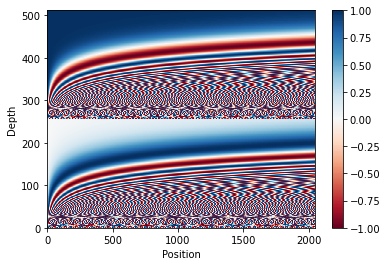

In [268]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [269]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len,
                 maximum_position_encoding, 
                 rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_seq_len, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [270]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_seq_len,
                 maximum_position_encoding, 
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_seq_len, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [514]:
class HiD_EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, time_steps, known_reg_inputs, 
                 static_inputs,hls=64,cat_inputs=None):
        
        super(HiD_EmbeddingLayer,self).__init__()
        
        #self.inputs = inputs
        self.time_steps = time_steps
        self.known_locs = known_reg_inputs
#         self.future_locs = future_inputs
        self.static_locs = static_inputs
        #self.target_loc = target
        if cat_inputs:
            self.cat = cat_inputs
            
        self.hls = hls
            
    def convert_to_real(self,x):
        return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hls))(x)
        
    def call(self, inputs):
        
        '''
        Not set up for categorical inputs currently - therefore regular inputs = inputs
        
        First trial we will ignore the targets
        '''
        regular_inputs = inputs[0]
        _,times, feature = regular_inputs.get_shape().as_list()
        
        
        static_inputs = [tf.keras.layers.Dense(self.hls)(regular_inputs[:,0,i:i+1]) \
                         for i in range(feature) if i in self.static_locs]
        
        static_inputs = tf.stack(static_inputs,axis=1)
        
        # Target Embedding - how to do this?
        
        #target_output = tf.stack([convert_to_real(regular_inputs[Ellipsis, i:i+1]) for i in self.target],axis=-1)
        
        # A prior known
        known_inputs = [self.convert_to_real(regular_inputs[Ellipsis, i:i+1]) \
                        for i in self.known_locs if i not in self.static_locs]
        
        known_combined_inputs = tf.stack(known_inputs, axis=-1)
        
        return known_combined_inputs, static_inputs#target_output, static_inputs
        

In [681]:
class LinearLayer(tf.keras.layers.Layer):
    
    def __init__(self, size, use_time_distributed, use_bias=True,activation=None):
        
        super(LinearLayer,self).__init__()
        
        self.size = size
        self.use_time_distributed = use_time_distributed
        self.use_bias = use_bias
        self.activation = activation
        
    def call(self, inputs):
        
        linear = tf.keras.layers.Dense(self.size,activation=self.activation,
                                      use_bias =self.use_bias)(inputs)
        if self.use_time_distributed:
            linear = tf.keras.layers.TimeDistributed(linear)
            
        return linear
        

In [682]:
class GLU(tf.keras.layers.Layer):
    
    def __init__(self, hls,use_time_distributed=True,dropout_rate=None,activation=None):
        
        super(GLU,self).__init__()
        
        self.hls = hls
        self.use_time_distributed = use_time_distributed
        self.dropout_rate=dropout_rate
        self.activation=activation
            
    def call(self, inputs):
        
        if self.dropout_rate:
            inputs = tf.keras.layers.Dropout(self.dropout_rate)(inputs)
        
        if self.use_time_distributed:
            activation_layer = tf.keras.layers.TimeDistributed\
            (tf.keras.layers.Dense(self.hls,activation=self.activation))(inputs)
            
            gate_layer = tf.keras.layers.TimeDistributed\
            (tf.keras.layers.Dense(self.hls, activation='sigmoid'))(inputs)
            
        else:
            activation_layer = tf.keras.layers.Dense(self.hls, activation=self.activation)(inputs)          
            gate_layer = tf.keras.layers.Dense(self.hls, activation='sigmoid')
            
        return tf.keras.layers.Multiply()([activation_layer,gate_layer]), gate_layer

In [683]:
class GatedResidualNetwork(tf.keras.layers.Layer):
    
    def __init__(self, hls=64, output_size=None,
                 dropout_rate=None, additional_context=None,
                 use_time_distributed=True, return_gate=False):
        
        super(GatedResidualNetwork,self).__init__()
        self.hls = hls
        self.use_time_distributed = use_time_distributed
        self.return_gate = return_gate
        
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.additional_context = additional_context
        
        
        self.linear = LinearLayer(hls, activation=None,
                             use_time_distributed=self.use_time_distributed)
        
        self.gate_layer = GLU(hls=self.hls,dropout_rate=self.dropout_rate,
                             use_time_distributed=self.use_time_distributed,activation=None)
        
        
    def add_and_norm(inputs):
        
        tmp = tf.keras.layers.add(inputs)
        tmp = tf.keras.layers.LayerNormalization()(tmp)
        return tmp
    
    def call(self, inputs):
        
        if not self.output_size:
            output_size = self.hls
            skip = inputs
        else:
            linear = tf.keras.layers.Dense(self.output_size)
            if self.use_time_distributed:
                linear = tf.keras.layers.TimeDistributed(linear)
            skip = linear(inputs)
        
        print('self.linaer')
        print(self.linear)
        hidden = self.linear(inputs)
        print('hidden')
        print(hidden)
        
        if self.additional_context:
            
            hidden = hidden + LinearLayer(self.hls, activation=None,
                                         use_time_distributed=self.use_time_distributed,
                                         use_bias=False)(self.additional_context)
        print(hidden)
        hidden = tf.keras.layers.Activation('elu')(hidden)
        hidden = LinearLayer(self.hls, activation=None,
                            use_time_distributed=self.use_time_distributed)(hidden)
        
        gating_layer, gate = self.gate_layer(hidden)
        
        if self.return_gate:
            return add_and_norm([skip, gating_layer]), gate
        else:
            return add_and_norm([skip, gating_layer])
        
        
        
                
        
        

In [684]:
def static_VSN(embedding,hls=64,dropout_rate=.1):
    
    _, num_static, _ = embedding.get_shape().as_list()
    flatten = tf.keras.layers.Flatten()(embedding)
    
    mlp_outputs = GatedResidualNetwork(hls, output_size=num_static,
                                      dropout_rate=dropout_rate,
                                      use_time_distributed=False,
                                      additional_context=None)(flatten)
    
    sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)

    sparse_weights = tf.expand_dims(sparse_weights, axis=-1)
    
    trans_emb_list = []
    for i in range(num_static):
        e = GatedResidualNetwork(embedding[:,i:i+1,:],
                                hls,
                                dropout_rate=dropout_rate,
                                use_time_distributed=False)
        trans_emb_list.append(e)
        
    transformed_embedding = tf.concat(trans_emb_list,axis=1)
    
    combined = tf.keras.layers.Multiply()([sparse_weights,
                                           transformed_embedding])
    
    static_vec = tf.math.reduce_sum(combined, axis=1)
    
    return static_vec, sparse_weights
    

In [685]:
class HiDTransformer(tf.keras.Model):
    
    def __init__(self, num_layers, d_model,
                 num_heads, dff, input_seq_len,
                 target_seq_len,pe_input, pe_output, 
                 known_reg_inputs, static_inputs,
                 hls=64,cat_inputs=None,
                 rate=.1):
        super().__init__()
        
        self.hls = hls
        self.dropout_rate = rate
        
        self.known = known_reg_inputs
        self.static = static_inputs
        
        self.input_seq_len = input_seq_len
        self.target_seq_len = target_seq_len
        
        self.embedding = HiD_EmbeddingLayer(time_steps=target_seq_len + input_seq_len,
                                           known_reg_inputs=known_reg_inputs,
                                           static_inputs = static_inputs)
        
        
        # Static GRNs - to edit if neccessayr 
        # 1 = static_context_variable_selection
        # 2 = static_context_enrichment
        # 3 = static_context_state_h
        # 4 = static_context_state_c
        
        # next step would be lstm_combine_and_mask
        
        self.static_grn1 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn2 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn3 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn4 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_seq_len,pe_input,rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_seq_len,pe_output,rate)
        
    def call(self, inputs, training):
        
        inp,tar = inputs
        
        known_emb, static_emb = self.embedding(inputs)
        
        future_inputs = known_emb[:, self.input_seq_len:,:]
        
        static_encoder, static_weights = static_VSN(static_emb,self.hls,
                                                   self.dropout_rate)
        
        static_context_variable_selection = self.static_grn1(static_encoder)
        static_context_enrichment = self.static_grn2(static_encoder)
        static_context_state_h = self.static_grn3(static_encoder)
        static_context_state_c = self.static_grn4(static_encoder)
        
        # skipping this step
        '''
        historical_features, historical_flags, _ = lstm_combine_and_mask(
        historical_inputs)
        future_features, future_flags, _ = lstm_combine_and_mask(future_inputs)
        '''
        
        expanded_static_context = tf.expand_dims(static_context_enrichment,
                                                axis=1)
        
        
        
        
        

In [686]:
features.head()

2 Age Distribution  3 Air Pollution  4 Comorbidities  5 Health Disparities  \
0            0.482809         0.806122         0.456746              0.463941   
1            0.482809         0.806122         0.456746              0.463941   
2            0.482809         0.806122         0.456746              0.463941   
3            0.482809         0.806122         0.456746              0.463941   
4            0.482809         0.806122         0.456746              0.463941   

   6 Mobility  7 Residential Density  8 Disease Spread  9 Social Distancing  \
0     0.64972               0.163959               0.0                  1.0   
1     0.64972               0.163959               0.0                  1.0   
2     0.64972               0.163959               0.0                  1.0   
3     0.64972               0.163959               0.0                  1.0   
4     0.64972               0.163959               0.0                  1.0   

   10 Testing  11 Transmissible Cases  12 VaccinationOneDose  13 Vaccination  \
0       0.000                     0.0                    0.0             0.0   
1       0.000                     0.0                    0.0             0.0   
2       0.000                     0.0                    0.0             0.0   
3       0.000                     0.0                    0.0             0.0   
4       0.012                     0.0                    0.0             0.0   

   14 LinearSpace  15 Constant  16 LinearTime  17 P2-Time  18 P3-Time  \
0             0.0          0.5       0.000000    1.000000   -1.000000   
1             0.0          0.5       0.001988    0.988072   -0.976215   
2             0.0          0.5       0.003976    0.976191   -0.952666   
3             0.0          0.5       0.005964    0.964358   -0.929354   
4             0.0          0.5       0.007952    0.952572   -0.906277   

   19 P4-Time  20 CosWeekly  21 SinWeekly  
0    1.000000     -0.222521     -0.974928  
1    0.960515      0.623490     -0.781832  
2    0.921738      1.000000      0.000000  
3    0.883663      0.623490      0.781832  
4    0.846281     -0.222521      0.974928

In [687]:
model = HiDTransformer(num_layers=4, d_model=128,
                 num_heads=8, dff=512, input_seq_len=13,
                 pe_input=1000,pe_output=1000,
                 target_seq_len=15,
                 known_reg_inputs=known, static_inputs=static,
                 hls=64,cat_inputs=None,
                 rate=.1)

In [688]:
# add loss
loss = tf.keras.losses.MeanSquaredError()

In [689]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [690]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [691]:
checkpoint_path = './COVIDJuly2020/checkpoints/CovidA21-TFT2Extended-JulyCutoff-TFTJupyterdir/'

In [692]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [693]:
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [694]:
EPOCHS = 20

In [695]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None,None,  None), dtype=tf.int64),
]


@tf.function()#input_signature=train_step_signature)
def train_step(inp, tar):
  print(inp)
  print(tar)
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  print(tar_inp)
  print(tar_real)
  with tf.GradientTape() as tape:
    predictions, _ = model([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [696]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [697]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    # train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_batches):
        print(inp.shape)
        print(tar.shape)
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()

(64, 28, 20)
(64, 15, 1)
Tensor("inp:0", shape=(64, 28, 20), dtype=float32)
Tensor("tar:0", shape=(64, 15, 1), dtype=float32)
Tensor("strided_slice:0", shape=(64, 14, 1), dtype=float32)
Tensor("strided_slice_1:0", shape=(64, 14, 1), dtype=float32)
self.linaer
hidden
Tensor("hi_d_transformer_29/gated_residual_network/linear_layer/dense_15/BiasAdd:0", shape=(64, 64), dtype=float32)
Tensor("hi_d_transformer_29/gated_residual_network/linear_layer/dense_15/BiasAdd:0", shape=(64, 64), dtype=float32)


2022-02-10 16:18:58.331539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: in user code:

    File "/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2919310302.py", line 16, in train_step  *
        predictions, _ = model([inp, tar_inp],
    File "/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "hi_d_transformer_29" (type HiDTransformer).
    
    in user code:
    
        File "/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/2385135625.py", line 59, in call  *
            static_encoder, static_weights = static_VSN(static_emb,self.hls,
        File "/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/643140118.py", line 6, in static_VSN  *
            mlp_outputs = GatedResidualNetwork(hls, output_size=num_static,
        File "/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "gated_residual_network" (type GatedResidualNetwork).
        
        in user code:
        
            File "/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/3680611516.py", line 57, in call  *
                gating_layer, gate = self.gate_layer(hidden)
            File "/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
        
            TypeError: Exception encountered when calling layer "glu" (type GLU).
            
            in user code:
            
                File "/var/folders/nq/ydw8sbmd0492r2npkdsbqqvc0000gn/T/ipykernel_87725/4049450532.py", line 26, in call  *
                    return tf.keras.layers.Multiply()([activation_layer,gate_layer]), gate_layer
                File "/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/layers/merge.py", line 87, in build
                    if not isinstance(input_shape[0], tuple):
            
                TypeError: 'NoneType' object is not subscriptable
            
            
            Call arguments received:
              • inputs=tf.Tensor(shape=(64, 64), dtype=float32)
        
        
        Call arguments received:
          • inputs=tf.Tensor(shape=(64, 384), dtype=float32)
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(64, 28, 20), dtype=float32)', 'tf.Tensor(shape=(64, 14, 1), dtype=float32)']
      • training=True


## Extract Weights for Feature Importance

In [57]:
class AttentionWeights():

  def __init__(self, flagMatrix, numLoc, totTimeSteps, columnDefinition,inpSize, predSize, quantiles):

    self.input_size = inpSize
    self.prediction_size = predSize
    self.total_sequence_length = inpSize + predSize
    self.weights = flagMatrix
    self.locations = numLoc 
    self.timesteps = totTimeSteps

    self.quantiles = quantiles

    self.full_length = totTimeSteps - 1 + inpSize + predSize

    self.sequences = flagMatrix['static_flags'].shape[0]
    
    self.static_features = flagMatrix['static_flags'].shape[1]

    self.decoder_attention = flagMatrix['decoder_self_attn']

    self.column_definition = columnDefinition

    self.identifiers = flagMatrix['identifiers']
    self.timeID = flagMatrix['time']

    self.known = None
    self.observed = None
    self.historical = None
    self.static = None
    self.unknown = None
    self.target = None
  
    self.setKnown()
    self.setObserved()
    self.setStatic()
    self.setTarget()

    self.setUnknown()
    self.setHistorical()
    #historical_inputs = unknown + known + observed ---> unknown features in TFT should be removed?

  def setKnown(self):

    KnownInputs = []

    for Column in self.column_definition:
      if Column[2] == InputTypes.KNOWN_INPUT:
        KnownInputs.append(Column)

    self.known = KnownInputs

  def setObserved(self):

    ObservedInputs = []

    for Column in self.column_definition:
      if Column[2] == InputTypes.OBSERVED_INPUT:
        ObservedInputs.append(Column)
    self.observed = ObservedInputs

  def setStatic(self):

    StaticInputs = []

    for Column in self.column_definition:
      if Column[2] == InputTypes.STATIC_INPUT:
        StaticInputs.append(Column)

    self.static = StaticInputs

  def setTarget(self):

    Targets = []
    for Column in self.column_definition:
      if Column[2] == InputTypes.TARGET:
        Targets.append(Column)
    self.target = Targets


  # This function will declare the inputs that the TFT does not recognize
  def setUnknown(self):
    UnknownInputs = []

    for Column in self.column_definition:
      if Column[2] not in [InputTypes.TARGET, InputTypes.KNOWN_INPUT, InputTypes.OBSERVED_INPUT,
                        InputTypes.STATIC_INPUT]:
        UnknownInputs.append(Column)

    self.unknown = UnknownInputs
    
  def setHistorical(self):
    
    if self.unknown:
      Historical = self.unknown + self.known + self.observed
    else: 
      Historical = self.known + self.observed

    self.historical = Historical
    print(self.historical)
    


  def getStaticWeights(self):

    staticMatrix = np.zeros((self.locations, self.static_features))
    LocationCounter=0
    
    for Sequence in range(self.sequences):
      if Sequence != 0 and Sequence % self.timesteps == 0:
        LocationCounter += 1
      staticMatrix[LocationCounter] = self.weights['static_flags'][Sequence]

    SMatrix = np.zeros((self.locations, self.full_length, self.static_features))

    for idx,i in enumerate(SMatrix):
      for jdx, j in enumerate(i):
        SMatrix[idx][jdx] = staticMatrix[idx]

    return SMatrix

  def getFutureWeights(self):
    seq, times, feat = self.weights['future_flags'].shape
    #Construct new matrix to store averages 
    #   shape = (Location x TimeSteps x Features)

    futureMatrix = np.zeros((self.locations, self.timesteps+times-1, feat))
    print(futureMatrix.shape)

    locCounter=0
    TimeCounter=0

    for Sequence in range(seq):#i goes from 0 to 29964 (length = 29965)

      if Sequence != 0 and Sequence % self.timesteps == 0:
        locCounter += 1
        TimeCounter = 0

      for TimeStep in range(times):  # TimeStep goes from 0 to 14 (length = 15)
        futureMatrix[locCounter,TimeCounter+TimeStep] += self.weights['future_flags'][Sequence, TimeStep]

      TimeCounter += 1

    # Divide Matrix ---> to incorporate this into the above code
    for idx,i in enumerate(futureMatrix):
      for jdx,j in enumerate(i):
        if jdx >= times-1 and jdx <= futureMatrix.shape[1] - times:
          futureMatrix[idx,jdx] = np.divide(futureMatrix[idx,jdx], times)
        else:
          divisor = min(abs(jdx+1), abs(futureMatrix.shape[1]-jdx))
          futureMatrix[idx,jdx] = np.divide(futureMatrix[idx,jdx], divisor)

    FMatrix = np.zeros((self.locations, self.full_length,feat))
    FMatrix[:,self.input_size:,:] = futureMatrix
  
    return FMatrix

  def getHistoricalWeights(self):
    
    seq, times, feat = self.weights['historical_flags'].shape
    #Construct new matrix to store averages 
    #   shape = (Location x TimeSteps x Features)

    historicalMatrix = np.zeros((self.locations, self.timesteps+times-1, feat))
    print(historicalMatrix.shape)

    locCounter=0
    TimeCounter=0

    for Sequence in range(seq):#i goes from 0 to 29964 (length = 29965)

      if Sequence != 0 and Sequence % self.timesteps == 0:
        locCounter += 1
        TimeCounter = 0

      for TimeStep in range(times):  # TimeStep goes from 0 to 14 (length = 15)
        historicalMatrix[locCounter,TimeCounter+TimeStep] += self.weights['historical_flags'][Sequence, TimeStep]

      TimeCounter += 1

    # Divide Matrix ---> to incorporate this into the above code
    for idx,i in enumerate(historicalMatrix):
      for jdx,j in enumerate(i):
        if jdx >= times-1 and jdx <= historicalMatrix.shape[1] - times:
          historicalMatrix[idx,jdx] = np.divide(historicalMatrix[idx,jdx], times)
        else:
          divisor = min(abs(jdx+1), abs(historicalMatrix.shape[1]-jdx))
          historicalMatrix[idx,jdx] = np.divide(historicalMatrix[idx,jdx], divisor)

    HMatrix = np.zeros((self.locations, self.full_length, feat))
    HMatrix[:,:self.timesteps+times-1,:] = historicalMatrix
  
    return HMatrix

  def getTemporalImportance(self,averageAcrossHeads=True):
      
    TempMatrix = self.decoder_attention
    if averageAcrossHeads:
      TempMatrix = TempMatrix.mean(axis=0).mean(axis=0)
    else:
      TempMatrix = TempMatrix.mean(axis=1)

    return TempMatrix

  def getTemporalQuantiles(self, averageAcrossHeads=True):

    TempMatrix = self.decoder_attention
    if averageAcrossHeads:
      TempMatrix = TempMatrix.mean(axis=0).mean(axis=0)

In [62]:
output_map =train(expt_name=name,
     use_gpu=use_tensorflow_with_gpu,
     model_folder=os.path.join(config.model_folder, "fixed" + RunName),
     data_csv_path=TFTdfTotal,# actually dataset NOT file location
     data_formatter=formatter,
     use_testing_mode=False)

02/08/2022, 11:41:31 UTC Start TFT  CovidA21-TFT2Extended-JulyCutoff-TFTJupyter  
              This is the TFT model fit for group number 2 in the rurality based stratification. The data is from beginning until July 2021.
              Feature importance is included in this modeling.
              
Selecting GPU ID=0
*** Training from defined parameters for FFFFWNPF ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
[('Location', 3, 4), ('Time from Start', 0, 5), ('RawLabel', 0, -1), ('0 Cases Root 2', 0, 0), ('1 Deaths Root 2', 0, 0), ('2 Age Distribution', 0, 3), ('3 Air Pollution', 0, 3), ('4 Comorbidities', 0, 3), ('5 Health Disparities', 0, 3), ('6 Mobility', 0, 3), ('7 Residential Density', 0, 3), ('8 Disease Spread', 0, 1), ('9 Social Distancing', 0, 1), ('10 Testing', 0, 1), ('11 Transmissible Cases', 0, 1), ('12 VaccinationOneDose', 0, 1), ('13 Vaccination', 0, 1), ('14 LinearSpace', 0, 2), ('15 Constant', 0, 2), ('16 Lin

2022-02-08 11:41:31.415639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-08 11:41:31.415695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-08 11:41:31.460938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-08 11:41:31.460974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:578 regular_inputs shape=(None, 28, 23)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:579 obs_inputs shape=(None, 28, 64, 2)


2022-02-08 11:41:31.830129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.835290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.844638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.849590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.853827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.866944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:31.871416: I tensorflow/core/grappler/optimizers/cust

2022-02-08 11:41:32.239304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.257101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.264913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.273751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.280855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.287685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.401594: I tensorflow/core/grappler/optimizers/cust

/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:832 unknown_inputs shape=(None, 28, 64, 7)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:833 known_combined_layer shape=(None, 28, 64, 8)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:834 obs_inputs shape=(None, 28, 64, 2)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:835 static_inputs shape=(None, 6, 64)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:898 static_inputs shape=(None, 6, 64)


2022-02-08 11:41:32.448618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.461811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.472821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.545153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.559780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.582444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:32.595640: I tensorflow/core/grappler/optimizers/cust

/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:900 static_encoder shape=(None, 64)
/Users/andrejerkelens/Desktop/HiDT/independent_study2/GPCE/TFToriginal/TFTCode/libs/tft_modelDev.py:901 static_weights shape=(None, 6, 1)


2022-02-08 11:41:33.632007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.674110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.750090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.781667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.813815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.845963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:33.879228: I tensorflow/core/grappler/optimizers/cust

2022-02-08 11:41:36.297170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.351449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.381416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.434027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.488400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.595871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:36.653706: I tensorflow/core/grappler/optimizers/cust

2022-02-08 11:41:40.028865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.106143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.141709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.216380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.291804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.416420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:40.494257: I tensorflow/core/grappler/optimizers/cust

2022-02-08 11:41:44.555419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:44.661391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:44.688539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:45.108534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:45.218174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:45.275009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:45.379167: I tensorflow/core/grappler/optimizers/cust

self.FinalLoopSize   2
Transformer_layer  (None, 28, 64, 2)


2022-02-08 11:41:47.240357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:47.376155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:47.497841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:47.621235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:47.746308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:47.879240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:41:48.000691: I tensorflow/core/grappler/optimizers/cust

outputs  (None, 15, 2)
Train samples 39737 Valid samples 39737
Getting legal sampling locations.
train max samples 39737 actual 36419
Max samples=39737 exceeds # available segments=36419
Cached data "train" updated
Getting legal sampling locations.
valid max samples 39737 actual 36419
Max samples=39737 exceeds # available segments=36419
Cached data "valid" updated


2022-02-08 11:42:09.495043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
data labels  (36419, 28, 23) (36419, 15, 2)
Train on 36419 samples, validate on 36419 samples
Epoch 1/60


2022-02-08 11:42:16.244646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:42:16.899080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:42:17.325773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36419/36419 [==============================] - ETA: 0s - loss: 0.0146

/Users/andrejerkelens/miniforge3/envs/env/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-02-08 11:46:49.306823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-08 11:47:43.714653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36419/36419 [==============================] - 329s 9ms/sample - loss: 0.0146 - val_loss: 0.0036
Epoch 2/60
14080/36419 [==========>...................] - ETA: 2:25 - loss: 0.0031

KeyboardInterrupt: 

In [ ]:
int_weights = loadT(expt_name=name,
     use_gpu=use_tensorflow_with_gpu,
     model_folder=os.path.join(config.model_folder, "fixed" + RunName),
     data_csv_path=TFTdfTotal,# actually dataset NOT file location
     data_formatter=formatter,
     use_testing_mode=False)

In [ ]:
TFTAttentionWeights = AttentionWeights(flagMatrix=int_weights,
                                       numLoc=Nloc,
                                       totTimeSteps=Num_Seq - TFTFutures + 1 ,
                                       columnDefinition=TFTcolumn_definition,
                                       inpSize=Tseq,
                                       predSize=TFTFutures,
                                       quantiles=[.3,.5,.7]
                                       )

In [ ]:
TFTWeightShapes = {}
for i in int_weights:
  TFTWeightShapes[i] = int_weights[i].shape
TFTWeightShapes

In [ ]:
test1 = np.array([[0,1,2,3],
                 [5,6,7,8]])

In [ ]:
test1.mean(axis=0)

In [ ]:
test1.sum(axis=0).sum(axis=0)

In [ ]:
int_weights['static_flags'].shape

In [ ]:
TFTAttentionWeights.static

In [ ]:
!ls /content/drive/MyDrive/independent_study2/COVIDJuly2020/CovidDecember12-2021/

In [ ]:
age_dist = pd.read_csv('/content/drive/MyDrive/independent_study2/COVIDJuly2020/CovidDecember12-2021/Age Distribution.csv')

### Equations for Attention Weights

1a. 

Decoder Self Attention raw matrix $A_{h,s,d,d}$ , <br> where h is number of self attention heads, s is the total number of sequences created from timesteps and counties, and d is the day index in each sequence.

Eqn 1a.

$Q_u$ represents quantile $u$ of all sequences s for attention $\alpha_{i,j}$ 

$\;\;\;\;\;\;$ $X_{q,d,d} = Q_u\left({\dfrac{\sum\limits_{h=1}^{n} \alpha_{h,s,d,d}}{n}}\right)$




###Save and Interpret TFT

In [ ]:
class TFTSaveandInterpret():

  def __init__(self,output_map, ReshapedPredictionsTOT):
# output_map is a dictionary pointing to dataframes
# output_map["targets"]) targets are called outputs on input
# output_map["p10"] is   p10 quantile forecast
# output_map["p50"] is   p10 quantile forecast
# output_map["p90"] is   p10 quantile forecast
#  Labelled by last real time in sequence (t-1) which starts at time Tseq-1 going up to Num_Time-1

# order of Dataframe columns is 'forecast_time', 'identifier', 
#'t+0-Obs0', 't+0-Obs1', 't+1-Obs0', 't+1-Obs1', 't+2-Obs0', 't+2-Obs1', 't+3-Obs0', 't+3-Obs1', 
#'t+4-Obs0', 't+4-Obs1', 't+5-Obs0', 't+5-Obs1', 't+6-Obs0', 't+6-Obs1', 't+7-Obs0', 't+7-Obs1', 
#'t+8-Obs0', 't+8-Obs1', 't+9-Obs0', 't+9-Obs1', 't+10-Obs0', 't+10-Obs1', 't+11-Obs0', 't+11-Obs1', 
#'t+12-Obs0', 't+12-Obs1', 't+13-Obs0', 't+13-Obs1', 't+14-Obs0', 't+14-Obs1''

# First time is FFFFWNPF Sequence # + Tseq-1
# Rows of data frame are ilocation*(Num_Seq+1) + FFFFWNPF Sequence #
# ilocation runs from 0 ... Nloc-1 in same order in both TFT and FFFFWNPF
    Sizes = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].shape
    self.Numx = Sizes[0]
    self.Numy = Sizes[1]
    self.Num_Seq1 = 1 + Num_Seq
    self.MaxTFTSeq = self.Num_Seq1-1
    expectednumx = self.Num_Seq1*Nloc
    if expectednumx != self.Numx:
      printexit(' Wrong sizes of TFT compared to FFFFWNPF ' + str(expectednumx) + ' ' + str(self.Numx))
    self.FFFFWNPFresults = np.zeros((self.Numx, NpredperseqTOT,3), dtype=np.float32)

    mapFFFFtoTFT = np.empty(Nloc, dtype = np.int32)
    TFTLoc = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]]['identifier'].unique()
    FFFFWNPFLocLookup = {}
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      FFFFWNPFLocLookup[locname] = i
    TFTLocLookup = {}
    for i,locname in enumerate(TFTLoc):
      TFTLocLookup[locname] = i
      if FFFFWNPFLocLookup[locname] is None:
        printexit('Missing TFT Location '+locname)
    for i,locname in enumerate(FFFFWNPFUniqueLabel):
      j = TFTLocLookup[locname] 
      if j is None:
        printexit('Missing FFFFWNPF Location '+ locname)
      mapFFFFtoTFT[i] = j


    indexposition = np.empty(NpredperseqTOT, dtype=int)
    output_mapcolumns = output_map[TFTQuantilenames[TFTPrimaryQuantileIndex]].columns
    numcols = len(output_mapcolumns)
    for ipred in range(0, NpredperseqTOT):
      label = PredictionTFTmapping[ipred]
      if label == ' ':
        indexposition[ipred]=ipred
      else:
        findpos = -1
        for i in range(0,numcols):
          if label == output_mapcolumns[i]:
            findpos = i
        if findpos < 0:
          printexit('Missing Output ' +str(ipred) + ' ' +label)    
        indexposition[ipred] = findpos

    for iquantile in range(0,TFTlenquantiles):
      for ilocation in range(0,Nloc):
        for seqnumber in range(0,self.Num_Seq1):
          
          for ipred in range(0,NpredperseqTOT):
            label = PredictionTFTmapping[ipred]
            if label == ' ': # NOT calculated by TFT
              if seqnumber >= Num_Seq:
                value = 0.0
              else:
                value = ReshapedPredictionsTOT[ilocation, seqnumber, ipred]

            else:
              ActualTFTSeq = seqnumber
              if ActualTFTSeq <= self.MaxTFTSeq:
                pos = indexposition[ipred]
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + ActualTFTSeq
                value = output_map[TFTQuantilenames[iquantile]].iloc[dfindex,pos] 
              else:
                dfindex = self.Num_Seq1*mapFFFFtoTFT[ilocation] + self.MaxTFTSeq
                ifuture = int(ipred/FFFFWNPFNumberTargets)
                jfuture = ActualTFTSeq - self.MaxTFTSeq + ifuture
                if jfuture <= LengthFutures:
                    jpred = ipred + (jfuture-ifuture)*FFFFWNPFNumberTargets
                    value = output_map[TFTQuantilenames[iquantile]].iloc[dfindex,indexposition[jpred]]
                else:
                  value = 0.0
            
            FFFFdfindex = self.Num_Seq1*ilocation + seqnumber
            self.FFFFWNPFresults[FFFFdfindex,ipred,iquantile] = value           

  # Default returns the median (50% quantile)
  def __call__(self, InputVector, Time= None, training = False, Quantile = None):
    lenvector = InputVector.shape[0]
    result = np.empty((lenvector,NpredperseqTOT), dtype=np.float32)
    if Quantile is None:
      Quantile = TFTPrimaryQuantileIndex
    for ivector in range(0,lenvector):
      dfindex = self.Num_Seq1*InputVector[ivector,0] + InputVector[ivector,1]
      result[ivector,:] = self.FFFFWNPFresults[dfindex, :, Quantile]

    return result




In [ ]:
tt = TFTSaveandInterpret(output_map, ReshapedPredictionsTOT)

In [ ]:
DL2 = False

In [ ]:
def getGet(output_map, TFTWeights):
  MyFFFFWNPFLink = TFTSaveandInterpret(output_map, ReshapedPredictionsTOT)
  modelflag = 2
  FitPredictions = DLprediction(ReshapedSequencesTOT, RawInputPredictionsTOT, MyFFFFWNPFLink, modelflag, TFTWeights, LabelFit ='TFT')
  return FitPredictions

In [ ]:
boom = getGet(output_map, TFTAttentionWeights)

In [ ]:
  def VisualizeTFT(output_map, TFTWeights):
    MyFFFFWNPFLink = TFTSaveandInterpret(output_map, ReshapedPredictionsTOT)
    modelflag = 2
    FitPredictions = DLprediction(ReshapedSequencesTOT, RawInputPredictionsTOT, MyFFFFWNPFLink, modelflag, TFTWeights, LabelFit ='TFT')
    if DL2:
      SensitivityAnalysis = DLprediction2F(ReshapedSequencesTOT, RawInputPredictionsTOT, MyFFFFWNPFLink, modelflag)
    # Input Predictions RawInputPredictionsTOT for DLPrediction are ordered Sequence #, Location but
    # Input Predictions ReshapedPredictionsTOT for TFTSaveandInterpret are ordered Location, Sequence#
    # Note TFT maximum Sequence # is one larger than FFFFWNPF

# View TFT Results Here

<b> Formulae: </b>



In [ ]:
SkipDL2F = True
VisualizeTFT(output_map, TFTAttentionWeights)
sys.exit(0)

### More TFT Parameters

In [ ]:

TFTnum_static = TFTScaledStaticInputs.shape[1]
if TFTCategoryCountsStaticInputs.shape[0] != TFTnum_static:
  printexit('Inconsistent static Shape)')
TFTNumDynamicVariables = TFTScaledDynamicInputs.shape[2]
if TFTCategoryCountsDynamicInputs.shape[0] != TFTNumDynamicVariables:
  printexit('Inconsistent static Shape)')
TFTNumDynamicHistoryVariables = 0
TFTNumDynamicFutureVariables = 0



TFTFutureInputLSTM = False
if TFTNumDynamicFutureVariables == 0:
  TFTFutureInputLSTM = False
else:
  TFTFutureInputLSTM = True